In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize, curve_fit
import random
random.seed(10)
import matplotlib.cm as cm

In [16]:
#parameters in vivo
K = 0.95e6 #carrying capacity, 95% of 1 million cells
x0 = 1e5 #initial population density
mu_no_drug = 0.01
dt = 0.01 #time step

In [17]:
#basic growth parameters
def growthRate(x, t, carryingCapacity, deathRate, r):
  dxdt = r * x * (carryingCapacity - x) / carryingCapacity - deathRate * x  # The population growth equation
  return dxdt

Will use the same equation as previously used for the decrease in $\mu$, only that it is now an increase in $d$ (the death rate of the immune cells).

$$d(t) = \frac{d_{(t=0)} - d_{\text{max}}}{1 + \exp\left[h \times (t - \tau)\right]} + d_{\text{max}}$$

First, I want to look at how the three different treatments changes the death rate. Finding exact numbers for $d_{max}$ is hard. Have based my parameters so far on the fact that the combination chemo is know to be hard on the immune system, azacitidine a bit more gentle and quizartinib the most gentle.

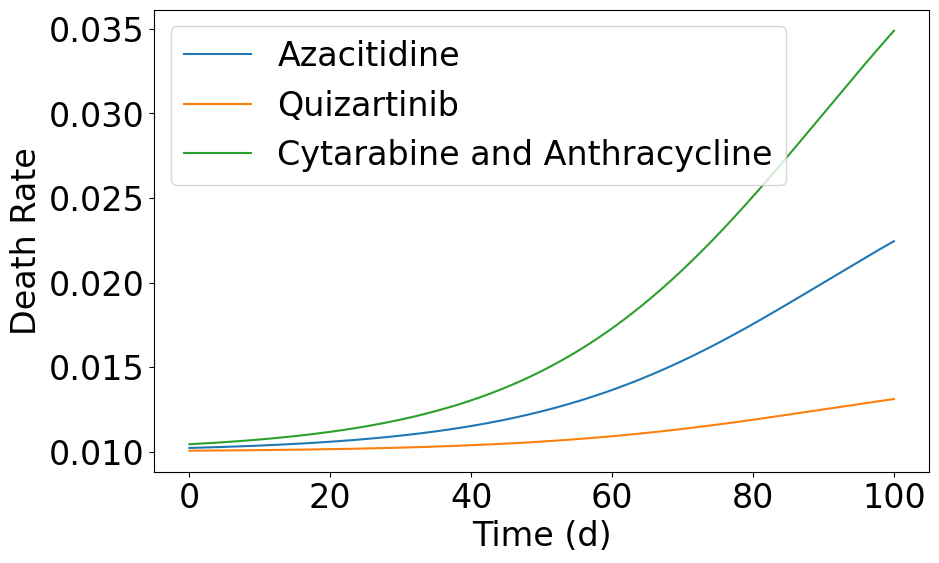

In [18]:
#death rate of immune cells, increasing as time goes
def d(t, d_t0, d_max, h, tau):
  return (d_t0 - d_max) / (1 + np.exp(h*(t-tau))) + d_max

t = np.arange(0, 100, dt)
d_t0 = 0.01
d_maxA = 0.03
d_maxQ = 0.015
d_maxCA = 0.05
h = 0.05
tau = 90

d_valuesA = d(t, d_t0, d_maxA, h, tau)
d_valuesQ = d(t, d_t0, d_maxQ, h, tau)
d_valuesCA = d(t, d_t0, d_maxCA, h, tau)

plt.figure(figsize=(10, 6))
plt.plot(t, d_valuesA, label='Azacitidine')
plt.plot(t, d_valuesQ, label='Quizartinib')
plt.plot(t, d_valuesCA, label='Cytarabine and Anthracycline')
plt.legend()
plt.xlabel('Time (d)')
plt.ylabel('Death Rate')
plt.show()

In [19]:
def growthRate_immune_toxicity(X, t, carryingCapacity, r, deathRate, h, tau, n0, c, g, m, d_t0, d_max, s):
  #collecting the tumour cell population and the immune cell population
  x, y = X
  #deathRate = (mu_t0 - mu_min)/(1 + np.exp(h * (t - tau))) + mu_min

  #the interaction coefficient is adjusted based on the relative sizes of immune cells and tumour cells
  n = n0 * np.exp(-1.2*x/y) #removed the parameter 2 here to see more of the effect

  #death rate of immune cells increasing as time goes
  d = (d_t0 - d_max) / (1 + np.exp(h*(t-tau))) + d_max

  #tumour cell growth
  dxdt = r * x * (carryingCapacity - x) / carryingCapacity - deathRate * x - n * y * x

  #immune system growth
  dydt = c * x * y / (g + x) - m * x * y  - d * y + s
  return [dxdt, dydt]

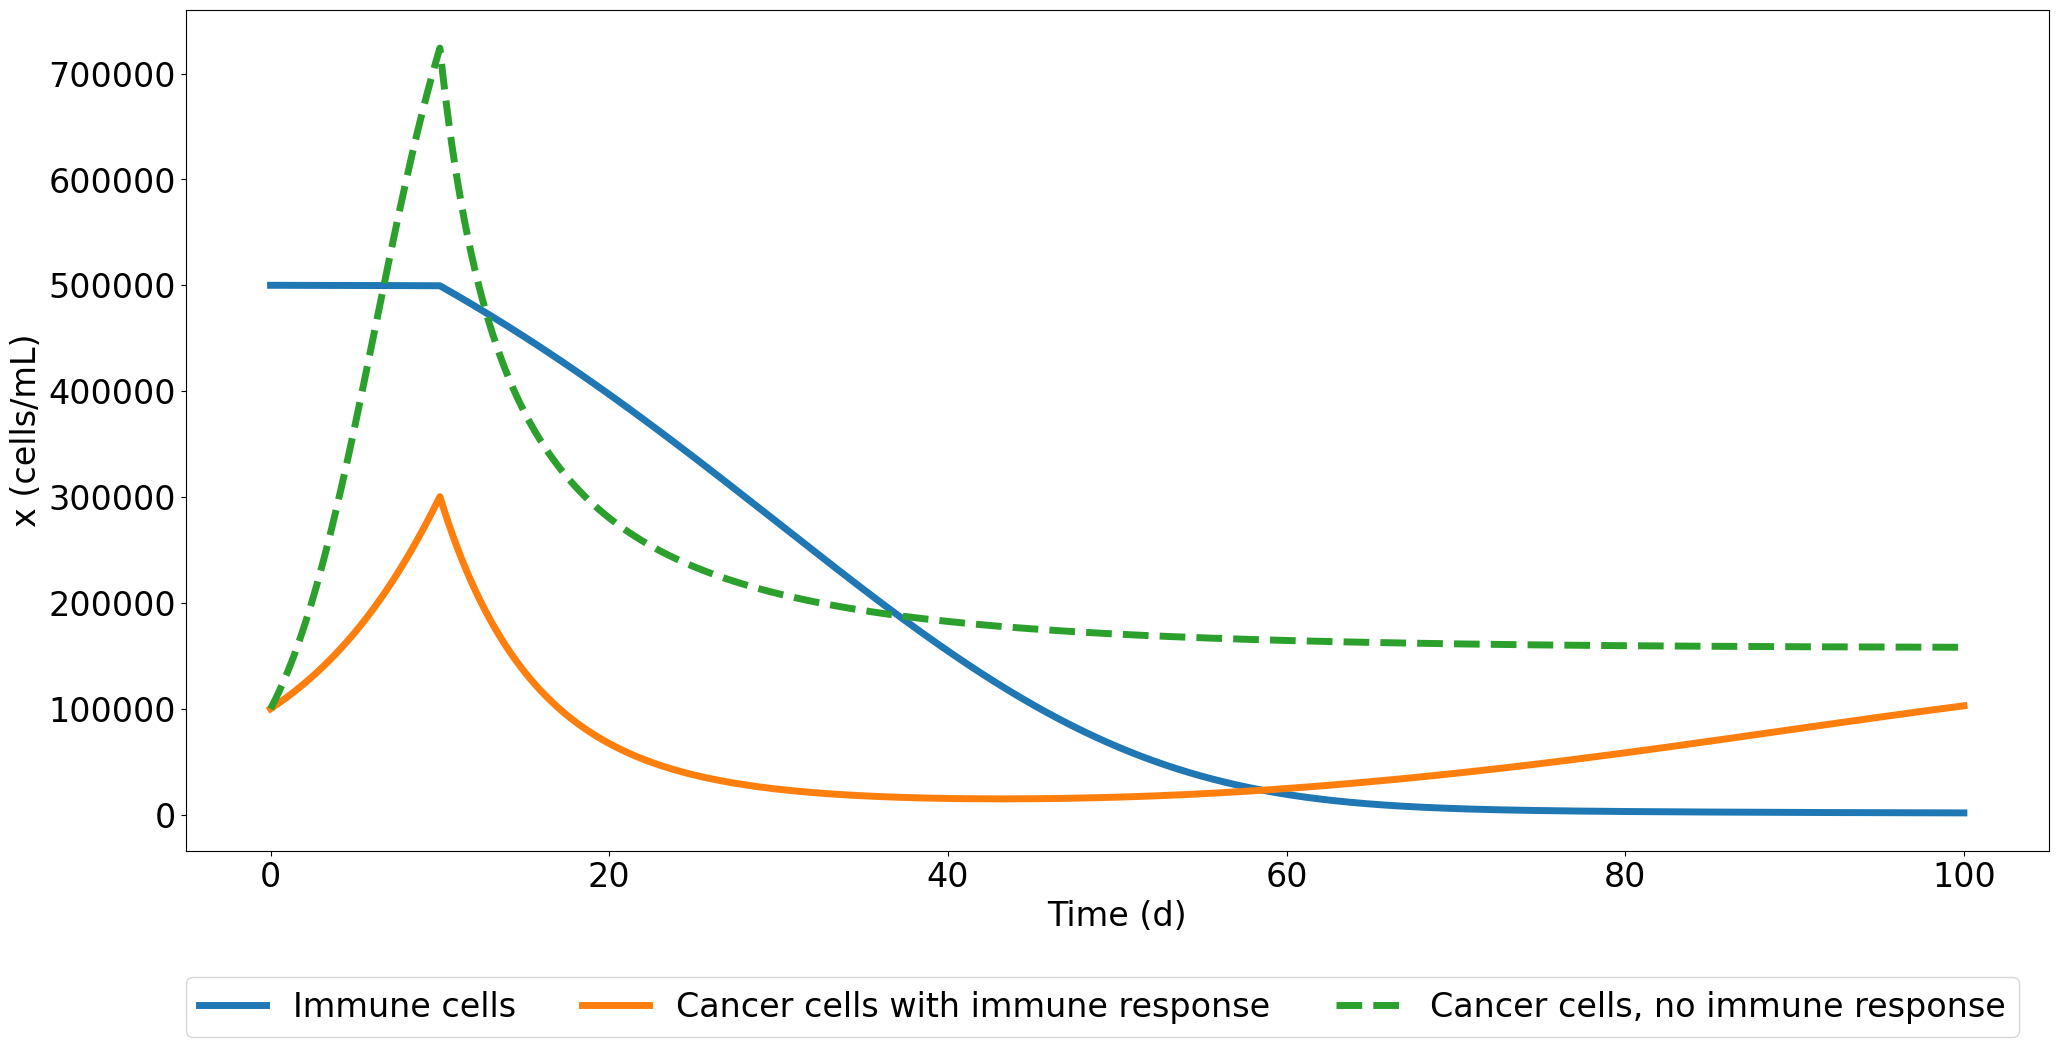

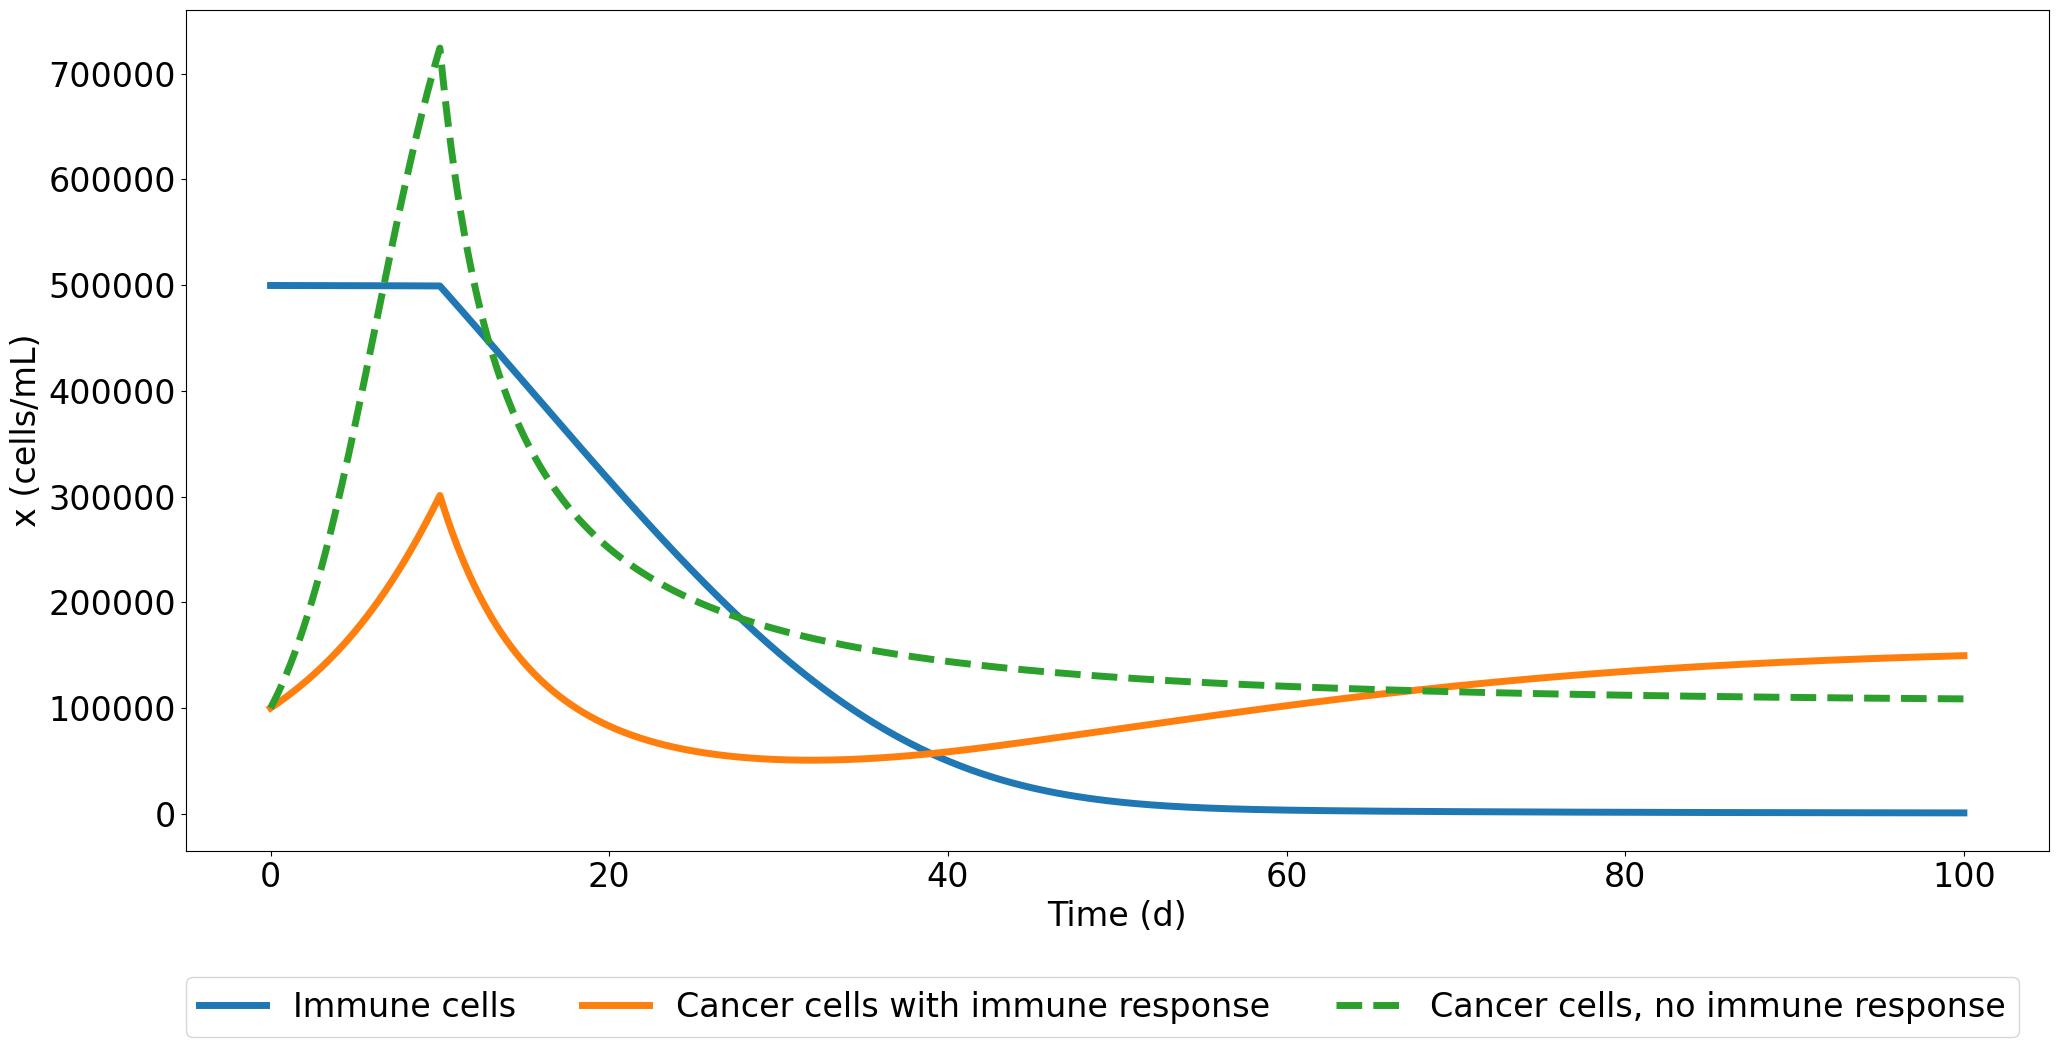

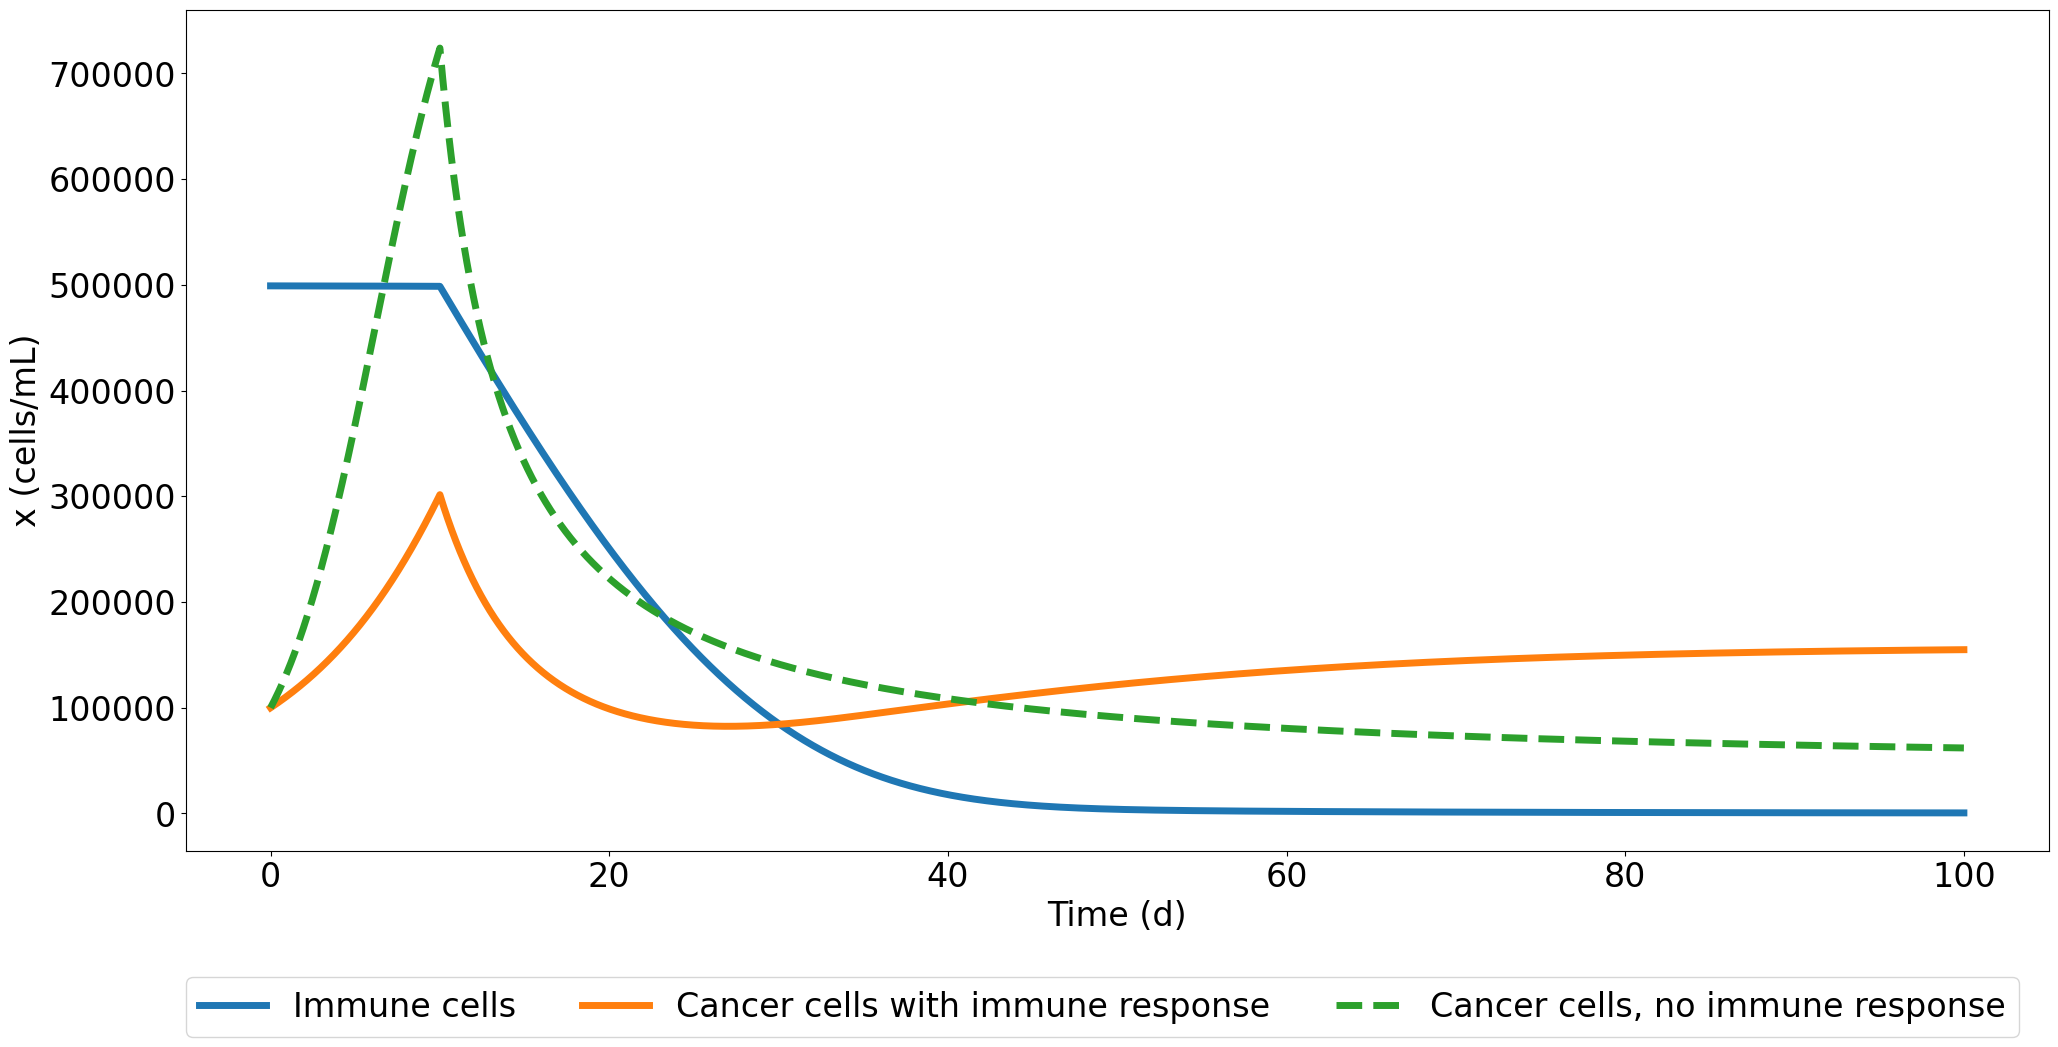

In [20]:
daysBeforeTreatment = 10
totalDays = 100

t_no_treatment = np.arange(0, daysBeforeTreatment + dt, dt)
t_treatment = np.arange(daysBeforeTreatment, totalDays+dt, dt)

h = 0.05
tau = 90

r = 0.35 #doubled in 7 days
mu_no_drug = 0.01

y0 = 5e5 #initial population of immune cells
n = 5e-7 #death rate of tumour cells due to immune cells
g = 1e5 #saturation constant
c = 1e-8 #growth rate of immune cells in response to tumour cells
m = 5e-10 #inactivation rate of immune cells due to the tumour
d = 0.002 #death rate of the immune cells
s = 1e3 #influx of new immune cells

drug_list = ['Azacitidine', 'Quizartinib', 'Cytarabine & anthracycline']
mu_list =  [0.292, 0.311, 0.331]
d_max_list = [1, 2, 3]

for i in range(len(mu_list)): #lag listen videre
  x0 = 1e5
  popDensity_noImmune_no_treatment = odeint(growthRate, x0, t_no_treatment, args=(K, mu_no_drug, r)) #solving the equation

  popDensity_immune_x_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,0]
  popDensity_immune_y_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,1]

  x0 = popDensity_immune_x_no_treatment[-1]
  y0 = popDensity_immune_y_no_treatment[-1]
  x0_noimmune = popDensity_noImmune_no_treatment[-1]

  popDensity_noImmune = odeint(growthRate, x0_noimmune, t_treatment, args=(K, mu_list[i], r))

  popDensity_immune_x = odeint(growthRate_immune_toxicity, [x0,y0], t_treatment, args =(K, r, mu_list[0], h, tau, n, c, g, m, d, d_max_list[i], s))[:,0]
  popDensity_immune_y = odeint(growthRate_immune_toxicity, [x0,y0], t_treatment, args =(K, r, mu_list[0], h, tau, n, c, g, m, d, d_max_list[i], s))[:,1]

  t = np.concatenate((t_no_treatment, t_treatment))
  popDensity_immune_x = np.concatenate((popDensity_immune_x_no_treatment, popDensity_immune_x))
  popDensity_immune_y = np.concatenate((popDensity_immune_y_no_treatment, popDensity_immune_y))
  popDensity_noImmune = np.concatenate((popDensity_noImmune_no_treatment, popDensity_noImmune))

  plt.figure(figsize=(22, 11))
  plt.plot(t, popDensity_immune_y, label = f'Immune cells', linewidth=5.0)
  plt.plot(t, popDensity_immune_x, label = f'Cancer cells with immune response', linewidth=5.0)
  plt.plot(t, popDensity_noImmune, label = f'Cancer cells, no immune response', linewidth=5.0, linestyle='dashed')
  plt.rcParams.update({'font.size': 24})
  plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0, fontsize=24)
  plt.tight_layout()
  plt.xlabel('Time (d)')
  plt.ylabel('x (cells/mL)')
  plt.savefig('Toxicity_ITT_3.pdf', format='pdf', bbox_inches='tight')
  plt.show()

Creating figure for image

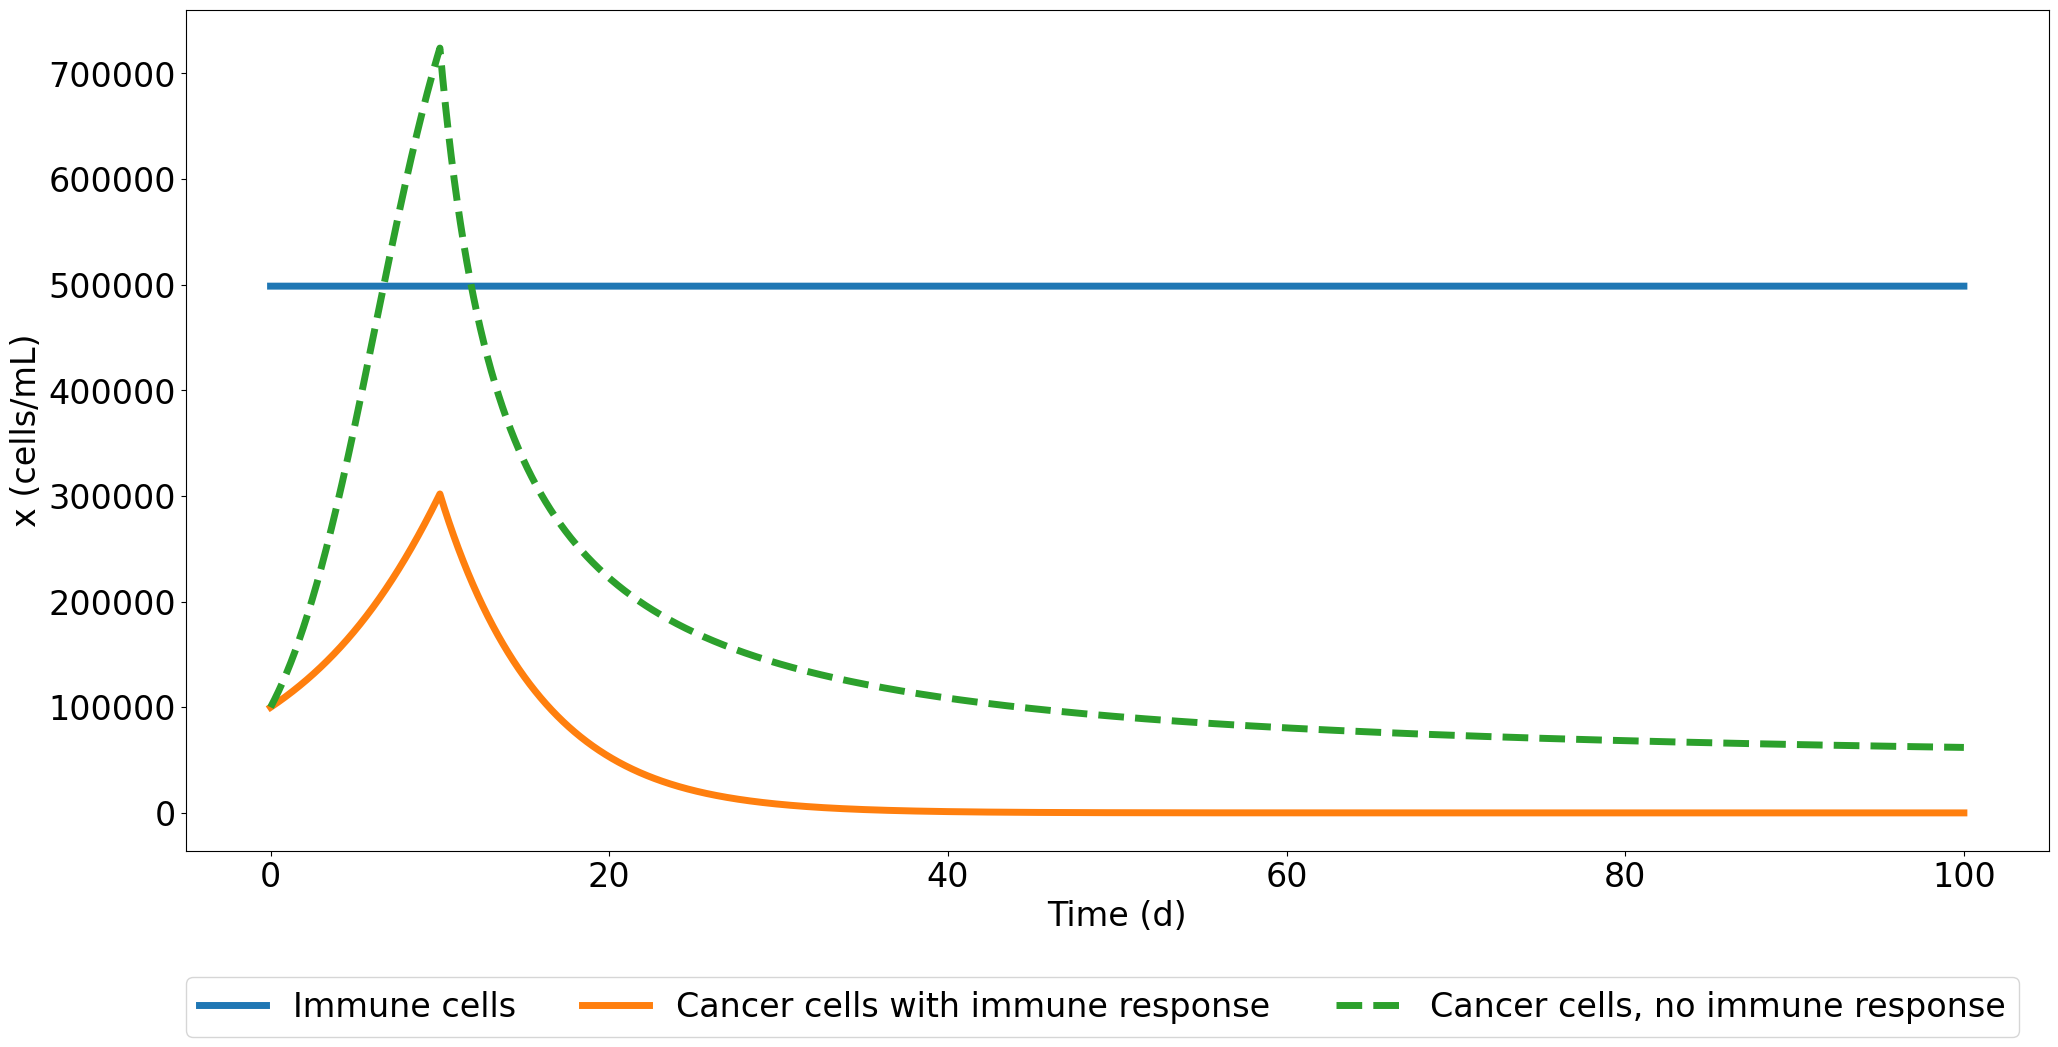

In [21]:
x0 = 1e5
popDensity_noImmune_no_treatment = odeint(growthRate, x0, t_no_treatment, args=(K, mu_no_drug, r)) #solving the equation

popDensity_immune_x_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, 0, 0, 0, 0, 0, 0))[:,0]
popDensity_immune_y_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, 0, 0, 0, 0, 0, 0))[:,1]

x0 = popDensity_immune_x_no_treatment[-1]
y0 = popDensity_immune_y_no_treatment[-1]
x0_noimmune = popDensity_noImmune_no_treatment[-1]

popDensity_noImmune = odeint(growthRate, x0_noimmune, t_treatment, args=(K, mu_list[i], r))

popDensity_immune_x = odeint(growthRate_immune_toxicity, [x0,y0], t_treatment, args =(K, r, mu_list[0], h, tau, n, 0, 0, 0, 0, 0, 0))[:,0]
popDensity_immune_y = odeint(growthRate_immune_toxicity, [x0,y0], t_treatment, args =(K, r, mu_list[0], h, tau, n, 0, 0, 0, 0, 0, 0))[:,1]

t = np.concatenate((t_no_treatment, t_treatment))
popDensity_immune_x = np.concatenate((popDensity_immune_x_no_treatment, popDensity_immune_x))
popDensity_immune_y = np.concatenate((popDensity_immune_y_no_treatment, popDensity_immune_y))
popDensity_noImmune = np.concatenate((popDensity_noImmune_no_treatment, popDensity_noImmune))

plt.figure(figsize=(22, 11))
plt.plot(t, popDensity_immune_y, label = f'Immune cells', linewidth=5.0)
plt.plot(t, popDensity_immune_x, label = f'Cancer cells with immune response', linewidth=5.0)
plt.plot(t, popDensity_noImmune, label = f'Cancer cells, no immune response', linewidth=5.0, linestyle = 'dashed')
plt.rcParams.update({'font.size': 24})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0, fontsize=24)
plt.tight_layout()
plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.savefig('NoTreatment_ITT.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Incorporating resistance

In [22]:
#Equations for the growth of S and R. Total population on the growth term since they are limited by the same resources.
def growthRate_SR(y0, t, K, L, mu, nu, r):
  S, R = y0
  dSdt = r * S * (K - (S + R)) / K - mu * S
  dRdt = r * R * (L - (S + R)) / L - nu * R
  return [dSdt, dRdt]

In [23]:
def growthRate_immune_SR(X, t, K, L, r, mu, nu, h, tau, n0, c, g, m, d_t0, d_max, s):
  #collecting the tumour cell population and the immune cell population
  S, R, y = X
  #the interaction coefficient is adjusted based on the relative sizes of immune cells and tumour cells
  n = n0 * np.exp(-1.2*(S + R)/y) #removed the parameter 2 here to see more of the effect

  #death rate of immune cells increasing as time goes
  d = (d_t0 - d_max) / (1 + np.exp(h*(t-tau))) + d_max

  #tumour cell growth
  dSdt = r * S * (K - (S + R)) / K - mu * S - n * y * S
  dRdt = r * R * (L - (S + R)) / L - nu * R - n * y * R

  #immune system growth
  dydt = c * (S + R) * y / (g + (S + R)) - m * (S + R) * y  - d * y + s
  return [dSdt, dRdt, dydt]

In [24]:
def resistance(p_drug, nResistant, nSensitive, nImmune, t_treatment, L, nu, K, mu, r, n0, c, g, m, d_t0, d_max, s, halftime, notreatment=False):
  nTotal_treatment = []
  sensitiveList = []
  resistantList = []
  immuneList = []
  mu_list = []
  d_list = []
  nImmune_upper = 5e5

  if nImmune == 0:
    y0 = [nSensitive, nResistant]
  else:
    y0 = [nSensitive, nResistant, nImmune]

  # Simulate the treatment phase with resistance evolution
  for t_point in t_treatment:
    #only looking at a small time interval
    time_interval = [t_point-dt,t_point]

    if nImmune == 0:
      y = odeint(growthRate_SR, y0, time_interval, args=(K, L, mu, nu, r))
      nSensitive = y[-1][0]
      nResistant = y[-1][1]
    else:
      y = odeint(growthRate_immune_SR, y0, time_interval, args=(K, L, r, mu, nu, h, tau, n0, c, g, m, d_t0, d_max, s))
      nSensitive = y[-1][0]
      nResistant = y[-1][1]
      if notreatment == False:
        nImmune = y[-1][2]
      elif notreatment == True and nImmune < nImmune_upper: 
        #sigmoid function to have gradual increase of the immune cell population
        #nImmune = (nImmune_upper - nImmune_lower) * 1/(1 + np.exp(-0.005 * (t_i - len(t_treatment)/2))) + nImmune_lower
        growth = 0.1
        nImmune += growth * (1 - nImmune / nImmune_upper) * nImmune * dt

      if halftime != 0:
        #letting the death rate decrease according to the half time
        k = -np.log(2)/halftime
        mu_t = mu * np.exp(k * (t_point-t_treatment[0]))
        #d_t0 = d_t0 * np.exp(k*(t_point-t_treatment[0]))
        y = odeint(growthRate_immune_SR, y0, time_interval, args=(K, L, r, mu_t, nu, h, tau, n0, c, g, m, d_t0, d_max, s))
        nSensitive = y[-1][0]
        nResistant = y[-1][1]

        if notreatment == False:
          nImmune = y[-1][2]
          
        mu_list.append(mu_t)

    #finding the number of newly born sensitive cells on each time step, multiply this with the total mLs of blood in a human body
    newSensitive = r * nSensitive * (K - (nSensitive+nResistant))/ K * dt 
    #newSensitive_tot =  r * nSensitive * (K - (nSensitive+nResistant))/ K * dt * 7000

    #mutations = newSensitive * 1e-7 #finding expected  number of mutated cells out of the new sensitive cells
    #p_resistance = p_drug * mutations #probability for getting resistant depends on the probability for the given drug times mutations

    #find the number of new mutated cells from a binomial distribution
    #newResistant = np.random.binomial(int(newSensitive), p_drug)
    #newResistant = np.random.binomial(int(newSensitive_tot), p_drug) / 7000

    #finding the expected value of a binomial distribution
    newResistant = newSensitive * p_drug

    #the new resistant cells are added to the resistant population
    nResistant += newResistant
    #subtracting the new restitant cells from the population
    nSensitive -= newResistant

    nTotal = nSensitive + nResistant

    if nImmune == 0:
      y0 = [nSensitive, nResistant]
    else:
      y0 = [nSensitive, nResistant, nImmune]

    nTotal_treatment.append(nTotal)
    sensitiveList.append(nSensitive)
    resistantList.append(nResistant)
    immuneList.append(nImmune)

  return nTotal_treatment, sensitiveList, resistantList, immuneList, mu_list, d_list

### Showing b

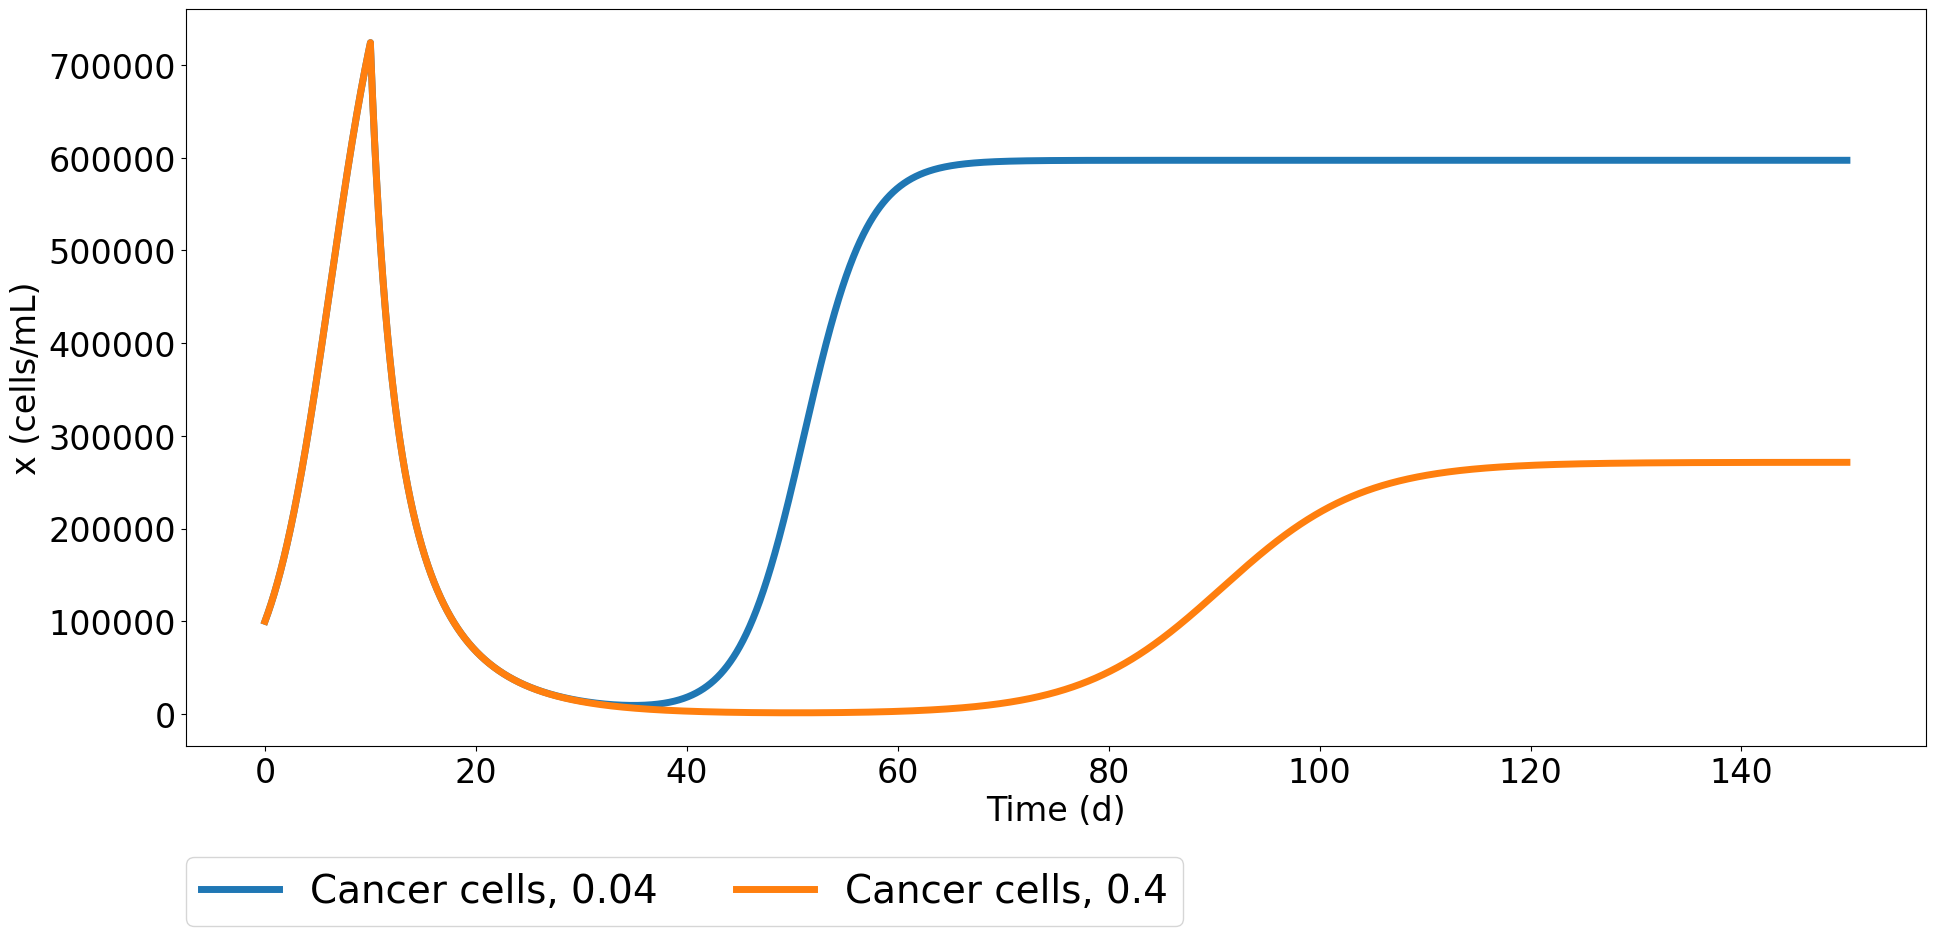

In [25]:
daysBeforeTreatment = 10
totalDays = 150

t_no_treatment = np.arange(0, daysBeforeTreatment + dt, dt)
t_treatment = np.arange(daysBeforeTreatment, totalDays+dt, dt)

h = 0.05
tau = 90

r = 0.35 #doubled in 7 days
mu =  0.5
d_max = 0.01
p_drug = 1e-5
b_list = [0.04, 0.4]  

y0 = 5e5 #initial population of immune cells
n = 5e-7 #death rate of tumour cells due to immune cells
g = 1e5 #saturation constant
c = 1e-8 #growth rate of immune cells in response to tumour cells
m = 5e-10 #inactivation rate of immune cells due to the tumour
d = 1e-4 #death rate of the immune cells
s = 1e3 #influx of new immune cells

plt.figure(figsize=(20, 10))
for i in range(len(b_list)):
  x0 = 1e5

  popDensity_noImmune_no_treatment = odeint(growthRate, x0, t_no_treatment, args=(K, mu_no_drug, r)) #solving the equation
  x0_noimmune = popDensity_noImmune_no_treatment.flatten()[-1]

  nTotal_treatment_noImmune, sensitiveList_noImmune, resistantList_noImmune, immuneList_noImmune, muList, dList = resistance(p_drug, 0, x0_noimmune, 0, t_treatment, K*2/3, b_list[i]*mu, K, mu, r, 0, 0, 0, 0, 0, 0, 0, 0)

  t = np.concatenate((t_no_treatment, t_treatment))
  density_noImmune = np.concatenate((popDensity_noImmune_no_treatment.flatten(), nTotal_treatment_noImmune))

  plt.plot(t, density_noImmune, label = f'Cancer cells, {b_list[i]}', linewidth=5.0)
  plt.rcParams.update({'font.size': 28})
  plt.xlabel('Time (d)')
  plt.ylabel('x (cells/mL)')
  plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
  plt.tight_layout()
  plt.savefig('bVals.pdf', format='pdf', bbox_inches='tight')
plt.show()

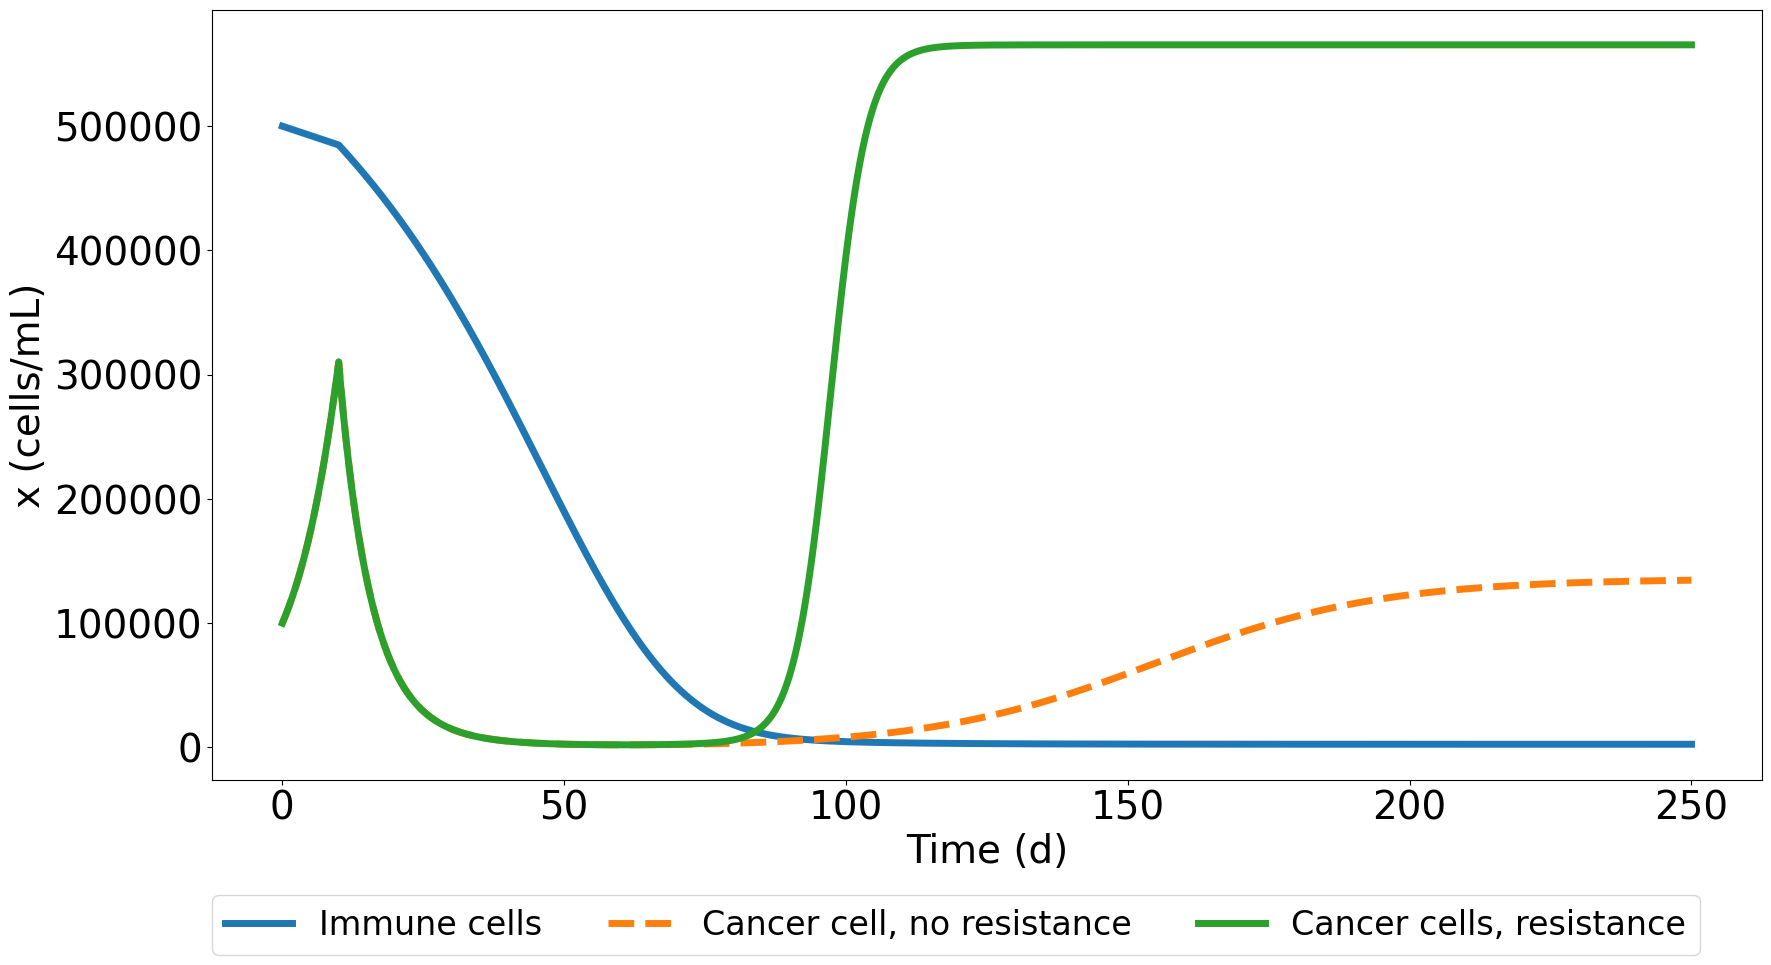

In [26]:
daysBeforeTreatment = 10
totalDays = 250

t_no_treatment = np.arange(0, daysBeforeTreatment + dt, dt)
t_treatment = np.arange(daysBeforeTreatment, totalDays+dt, dt)

h = 0.05
tau = 90

r = 0.35 #doubled in 7 days
mu_list =  [0.3, 0.3]
d_max_list = [0.4, 0.1]
p_drug_list = [1e-8, 1e-16] 
b_list = [0.125, 0.3]  

y0 = 5e5 #initial population of immune cells
n = 5e-7 #death rate of tumour cells due to immune cells
g = 1e5 #saturation constant
c = 1e-8 #growth rate of immune cells in response to tumour cells
m = 5e-10 #inactivation rate of immune cells due to the tumour
d = 0.005 #death rate of the immune cells
s = 1e3 #influx of new immune cells

x0 = 1e5

i = 0

popDensity_immune_x_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,0]
popDensity_immune_y_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,1]

nSensitive = popDensity_immune_x_no_treatment[-1]
nResistant = 0
nImmune = popDensity_immune_y_no_treatment[-1]

nTotal_treatment, sensitiveList, resistantList, immuneList, muList, dList = resistance(p_drug_list[i], nResistant, nSensitive, nImmune, t_treatment, K*2/3, b_list[i]*mu_list[i], K, mu_list[i], r, n, c, g, m, d, d_max_list[i], s, 0)

popDensity_immune_x = odeint(growthRate_immune_toxicity, [nSensitive, nImmune], t_treatment, args =(K, r, mu_list[i], h, tau, n, c, g, m, d, d_max_list[i], s))[:,0]

popDensity_noResponse = odeint(growthRate, x0_noimmune, t_treatment, args=(K, mu_list[i], r))

t = np.concatenate((t_no_treatment, t_treatment))
density = np.concatenate((popDensity_immune_x_no_treatment.flatten(), nTotal_treatment))
immune = np.concatenate((popDensity_immune_y_no_treatment.flatten(), immuneList))

density_noRes = np.concatenate((popDensity_immune_x_no_treatment, popDensity_immune_x))

density_noResponse = np.concatenate((popDensity_noImmune_no_treatment, popDensity_noResponse))

plt.figure(figsize=(20, 10))
#plt.plot(t_treatment, sensitiveList, label = f'sensitive population, {drug_list[i]}')
#plt.plot(t_treatment, sensitiveList_noImmune, label = f'sensitive population, no immune response, {drug_list[i]}')
#plt.plot(t_treatment, resistantList, label = f'resistant population, {drug_list[i]}')
#plt.plot(t_treatment, resistantList_noImmune, label = f'resistant population, no immune response, {drug_list[i]}')
plt.plot(t, immune, label = f'Immune cells', linewidth=5.0)
plt.plot(t, density_noRes, label = f'Cancer cell, no resistance', linewidth=5.0, linestyle='dashed')
#plt.plot(t, density_noImmune, label = f'Cancer cells, resistance, no immune response')
#plt.plot(t, density_noResponse, label = f'cancer cell population, no resistance, no immune response')
plt.plot(t, density, label = f'Cancer cells, resistance', linewidth=5.0)
plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 24})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3, borderaxespad=0, fontsize=24)
#plt.tight_layout()
plt.savefig('RITT.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Combination of Quizartinib and Cytarabine

https://www.cancer.org/cancer/types/acute-myeloid-leukemia/treating/typical-treatment-of-aml.html 
For people whose leukemia cells have an FLT3 gene mutation, quizartinib might be given along with chemo in the induction phase. In the consolidation phase, cycles of high-dose cytarabine is typically given. For those who were given quizartinib in the induction phase, this typically continues in the consolidation phase. 


Start by finding the combined death rate when both therapies are given. Look at their combined survival.

In [27]:
#defining death rates for the different treatments0
mu_combination = 0.33
mu_cytarabine = 0.325
mu_quizartinib = 0.27


In [28]:
mu_caq = 0.413
mu_cq = 0.409

t = np.arange(0, 10 + dt, dt)
t_drug = np.arange(0, 7+dt,dt)

popDensity_noDrug = odeint(growthRate, x0, t_drug, args=(K, mu_no_drug, r))
popDensity_quizartinib = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_quizartinib, r))
popDensity_combination = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_combination, r))
popDensity_cytarabine = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_cytarabine, r))

popDensity_caq = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_caq, r))
popDensity_cq = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_cq, r))

print(f'survival after quizartinib: {((popDensity_quizartinib[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after cytarabine+anthracycline: {((popDensity_combination[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival cytarabine: {((popDensity_cytarabine[-1] / popDensity_noDrug[-1])[0]):.3f}')

print('-------------------')
print(f'survival after cytarabine+anthracycline + quizartinib, multiplication: {((popDensity_combination[-1] / popDensity_noDrug[-1])[0]) * ((popDensity_quizartinib[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after cytarabine+anthracycline + quizartinib, new death rate: {((popDensity_caq[-1] / popDensity_noDrug[-1])[0]):.3f}')

print('-------------------')
print(f'survival after cytarabine + quizartinib, multiplication: {((popDensity_cytarabine[-1] / popDensity_noDrug[-1])[0]) * ((popDensity_quizartinib[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after cytarabine + quizartinib, new death rate: {((popDensity_cq[-1] / popDensity_noDrug[-1])[0]):.3f}')

survival after quizartinib: 0.562
survival after cytarabine+anthracycline: 0.389
survival cytarabine: 0.402
-------------------
survival after cytarabine+anthracycline + quizartinib, multiplication: 0.219
survival after cytarabine+anthracycline + quizartinib, new death rate: 0.219
-------------------
survival after cytarabine + quizartinib, multiplication: 0.226
survival after cytarabine + quizartinib, new death rate: 0.226


Anthracycline only given for three days. Neglect this resistance. Create new functions that also considers resistance towards different drugs. 

In [29]:
def growthRate_immune_SR_comb(X, t, K, L_A, L_V, L_Q, L_C, r, mu, nu_A, nu_V, nu_Q, nu_C, h, tau, n0, c, g, m, d_t0, d_max, s, treatment):
  #collecting the tumour cell population and the immune cell population
  S, R_A, R_V, R_Q, R_C, y = X
  #the interaction coefficient is adjusted based on the relative sizes of immune cells and tumour cells
  n = n0 * np.exp(-1.2*(S + R_A + R_V + R_Q + R_C)/y) #removed the parameter 2 here to see more of the effect

  #death rate of immune cells increasing as time goes
  d = (d_t0 - d_max) / (1 + np.exp(h*(t-tau))) + d_max

  #tumour cell growth, excluding the treatment term
  dSdt = r * S * (K - (S + R_A + R_V + R_Q + R_C)) / K - n * y * S 
  dR_Adt = r * R_A * (L_A - (S + R_A + R_V + R_Q + R_C)) / L_A - n * y * R_A
  dR_Vdt = r * R_V * (L_A - (S + R_A + R_V + R_Q + R_C)) / L_V - n * y * R_V
  dR_Qdt = r * R_Q * (L_Q - (S + R_A + R_V + R_Q + R_C)) / L_Q - n * y * R_Q
  dR_Cdt = r * R_C * (L_C - (S + R_A + R_V + R_Q + R_C)) / L_C - n * y * R_C
  if 'A' in treatment: #treatment term if azacitidine is part of the treatment 
    dSdt -= mu * S 
    dR_Adt -= nu_A * R_A
    dR_Vdt -= mu * R_V
    dR_Qdt -= mu * R_Q
    dR_Cdt -= mu * R_C
  if 'V' in treatment: #treatment term if azacitidine is part of the treatment 
    dSdt -= mu * S 
    dR_Adt -= mu * R_A
    dR_Vdt -= nu_V * R_V
    dR_Qdt -= mu * R_Q
    dR_Cdt -= mu * R_C
  if 'Q' in treatment: #treatment term if quizartinib is part of the treatment
    dSdt -= mu * S 
    dR_Adt -= mu * R_A
    dR_Vdt -= mu * R_V
    dR_Qdt -= nu_Q * R_Q
    dR_Cdt -= mu * R_C
  if 'C' in treatment: #treatment term if cytarabine is part of the treatment term
    dSdt -= mu * S 
    dR_Adt -= mu * R_A
    dR_Vdt -= mu * R_V
    dR_Qdt -= mu * R_Q
    dR_Cdt -= nu_C * R_C
  #immune system growth
  dydt = c * (S + R_A + R_V + R_Q + R_C) * y / (g + (S + R_A + R_V + R_Q + R_C)) - m * (S + R_A + R_V + R_Q + R_C) * y  - d * y + s
  return [dSdt, dR_Adt, dR_Vdt, dR_Qdt, dR_Cdt, dydt]

In [30]:
def dynamics_combination(p_drug_A, p_drug_V, p_drug_Q, p_drug_C, nR_A, nR_V, nR_Q, nR_C, nSensitive, nImmune, nImmune_upper, t_treatment, L, nu_A, nu_V, nu_Q, nu_C, K, mu, r, n0, c, g, m, d_t0, d_max, s, halftime, treatment, notreatment=False):
  nTotal_treatment = []
  sensitiveList = []
  resistantList_A = []
  resistantList_V = []
  resistantList_Q = []
  resistantList_C = []
  immuneList = []
  mu_list = []
  d_list = []
  L_A = L
  L_V = L
  L_Q = L
  L_C = L

  y0 = [nSensitive, nR_A, nR_V, nR_Q, nR_C, nImmune]

  # Simulate the treatment phase with resistance evolution
  for t_point in t_treatment:
    #only looking at a small time interval
    time_interval = [t_point-dt,t_point]

    y = odeint(growthRate_immune_SR_comb, y0, time_interval, args=(K, L_A, L_V, L_Q, L_C, r, mu, nu_A, nu_V, nu_Q, nu_C, h, tau, n0, c, g, m, d_t0, d_max, s, treatment))
    nSensitive = y[-1][0]
    nR_A = y[-1][1]
    nR_V = y[-1][2]
    nR_Q = y[-1][3]
    nR_C = y[-1][4]
    if notreatment == False:
      nImmune = y[-1][5]
    elif notreatment == True: 
      #sigmoid function to have gradual increase of the immune cell population
      #nImmune = (nImmune_upper - nImmune_lower) * 1/(1 + np.exp(-0.005 * (t_i - len(t_treatment)/2))) + nImmune_lower
      if nImmune_upper > 0:
        growth = 0.1
        nImmune += growth * (1 - nImmune / nImmune_upper) * nImmune * dt

    if halftime != 0:
      #letting the death rate decrease according to the half time
      k = -np.log(2)/halftime
      mu_t = mu * np.exp(k * (t_point-t_treatment[0]))
      #d_t0 = d_t0 * np.exp(k*(t_point-t_treatment[0]))
      y = odeint(growthRate_immune_SR_comb, y0, time_interval, args=(K, L_A, L_V, L_Q, L_C, r, mu_t, nu_A, nu_V, nu_Q, nu_C, h, tau, n0, c, g, m, d_t0, d_max, s, treatment))
      nSensitive = y[-1][0]
      nR_A = y[-1][1]
      nR_V = y[-1][2]
      nR_Q = y[-1][3]
      nR_C = y[-1][4]

      if notreatment == False:
        nImmune = y[-1][5]
        
      mu_list.append(mu_t)
  
    if 'A' in treatment:
      #finding the number of newly born sensitive cells on each time step with a possibility of turning resistant to each drug
      newPossible = r * (nSensitive + nR_V + nR_Q + nR_C) * (K - (nSensitive + nR_A + nR_V + nR_Q + nR_C))/ K * dt 
      newResistant_A = newPossible * p_drug_A
      #newResistant_A = np.random.poisson(newPossible * p_drug_A)
      nR_A += newResistant_A
    else:
        newResistant_A = 0
  
    if 'V' in treatment:
      #finding the number of newly born sensitive cells on each time step with a possibility of turning resistant to each drug
      newPossible = r * (nSensitive + nR_A + nR_Q + nR_C) * (K - (nSensitive + nR_A + nR_V + nR_Q + nR_C))/ K * dt 
      newResistant_V = newPossible * p_drug_V
      #newResistant_V = np.random.poisson(newPossible * p_drug_V)
      nR_V += newResistant_V
    else:
        newResistant_V = 0

    if 'Q' in treatment:
        #finding the number of newly born sensitive cells on each time step with a possibility of turning resistant to each drug
        newPossible = r * (nSensitive + nR_A + nR_V + nR_C) * (K - (nSensitive + nR_A + nR_V + nR_Q + nR_C))/ K * dt 
        newResistant_Q = newPossible * p_drug_Q
        #newResistant_Q = np.random.poisson(newPossible * p_drug_Q)
        nR_Q += newResistant_Q
    else:
        newResistant_Q = 0

    if 'C' in treatment:
        #finding the number of newly born sensitive cells on each time step with a possibility of turning resistant to each drug
        newPossible = r * (nSensitive + nR_A + nR_V + nR_Q) * (K - (nSensitive + nR_A + nR_V + nR_Q + nR_C))/ K * dt 
        newResistant_C = newPossible * p_drug_C
        #newResistant_C = np.random.poisson(newPossible * p_drug_C)
        nR_C += newResistant_C
    else:
        newResistant_C = 0
    #subtracting the new restitant cells from the population
    #total_resistant = newResistant_A + newResistant_V + newResistant_Q + newResistant_C
    #nSensitive = max(nSensitive - total_resistant, 0)

    nTotal = nSensitive + nR_A + nR_V + nR_Q + nR_C

    y0 = [nSensitive, nR_A, nR_V, nR_Q, nR_C, nImmune]

    nTotal_treatment.append(nTotal)
    sensitiveList.append(nSensitive)
    resistantList_A.append(nR_A)
    resistantList_V.append(nR_V)
    resistantList_Q.append(nR_Q)
    resistantList_C.append(nR_C)
    immuneList.append(nImmune)

  return nTotal_treatment, sensitiveList, resistantList_A, resistantList_V, resistantList_Q, resistantList_C, immuneList, mu_list, d_list

In [31]:
def simulate_treatment(treatment_phases, daysBeforeTreatment, parameters):
    K, x0, r, n, y0, nImmune_upper, g, c, m, d, s, mu_Q, mu_C, mu_A, mu_V, a, b_Q, b_C, b_A, b_V, p_Q, p_C, p_A, p_V, tau, h = parameters
    t_no_treatment = np.arange(0, daysBeforeTreatment + dt, dt)
    popDensity_immune_x_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,0]
    popDensity_immune_y_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,1]

    # Define initial conditions
    nSensitive = popDensity_immune_x_no_treatment[-1]
    nR_A, nR_V, nR_Q, nR_C = 0, 0, 0, 0
    nImmune = popDensity_immune_y_no_treatment[-1]

    # Lists to store results
    t_values = [t_no_treatment]
    density_values = [popDensity_immune_x_no_treatment.flatten()]
    immune_values = [popDensity_immune_y_no_treatment.flatten()]
    sensitive_values, resistant_A_values, resistant_V_values, resistant_Q_values, resistant_C_values = [], [], [], [], []

    # Loop through treatment phases
    t_start = daysBeforeTreatment
    for _, duration, mu, d_max, halftime, drug_type, notreatment in treatment_phases:
        t_phase = np.arange(t_start, t_start + duration + dt, dt)
        t_values.append(t_phase)

        # Run simulation for this treatment phase
        nTotal, sensitiveList, resistantList_A, resistantList_V, resistantList_Q, resistantList_C, immuneList, mu_list, _ = dynamics_combination(
            p_A, p_V, p_Q, p_C, nR_A, nR_V, nR_Q, nR_C, nSensitive, nImmune, nImmune_upper, t_phase, K*a, 
            b_A*mu_A, b_V*mu_V, b_Q*mu_Q, b_C*mu_C, K, mu, r, n, c, g, m, d_t0, d_max, s, halftime, drug_type, notreatment)
        

        # Update populations for next iteration
        nSensitive, nR_A, nR_V, nR_Q, nR_C, nImmune = sensitiveList[-1], resistantList_A[-1], resistantList_V[-1], resistantList_Q[-1], resistantList_C[-1], immuneList[-1]

        # Store results
        density_values.append(nTotal)
        immune_values.append(immuneList)
        sensitive_values.append(sensitiveList)
        resistant_A_values.append(resistantList_A)
        resistant_V_values.append(resistantList_V)
        resistant_Q_values.append(resistantList_Q)
        resistant_C_values.append(resistantList_C)

        # Update time for next phase
        t_start += duration

    # Concatenate results
    t = np.concatenate(t_values)
    t_after_treatment = np.concatenate(t_values[1:])  # Exclude the no-treatment phase
    density = np.concatenate(density_values)
    immune = np.concatenate(immune_values)
    sensitive = np.concatenate(sensitive_values)
    resistant_A = np.concatenate(resistant_A_values) 
    resistant_V = np.concatenate(resistant_V_values) 
    resistant_Q = np.concatenate(resistant_Q_values)
    resistant_C = np.concatenate(resistant_C_values)

    return t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values

### QuANTUM-FIRST trial

https://www.sciencedirect.com/science/article/pii/S0140673623004646#ecomp10
Combines the 7+3 regimen with quizartinib. Tested on patients aged 18-75. 


**Induction:** 
- Standard 7+3 regimen. On day 8 quizartinib or placebo (can also test the effect without quizartinib) once per dau for 14 days. People with CR after this went on to consolidation.
- Patients with persistent leukeamia got a second cycle of the 7+3 (or 5+2) + quizartinib (or placebo). 

**Consolidation:**
- High dose cytarabine every 12h on days 1, 3 and 5 for a total of six doses. 
- Quizartinib every day for 14 days from day 6 to day 19. 
- Each consolidation cycle could last up to 60 days to allow blood count recovery. 

**Maintenance:** 
- Quizartinib given every day for up to 3 years.


#### Complete remission after one induction cycle

In [32]:
h = 0.05
tau = 90

mu_Q = 0.25
mu_C = 0.325
mu_A = 0.19
mu_V = 0.16
mu_CA = 0.33
mu_CAQ = 0.413
mu_CQ = 0.409
mu_AV = 0.193

r = 0.35 #doubled in 7 days
K = 0.95e6
mu_no_drug = 0.01
d_max_CA = 0.25
d_max_CAQ = 0.27
d_max_C = 0.18
d_max_Q = 0.03
d_max_CQ = 0.23
p_Q = 1e-15
p_C = 2e-16
p_A = 1e-15
p_V = 1e-15
a = 2/3
b_Q = 0.05
b_C = 0.33
b_A = 0.125
b_V = 0.08  

y0 = 5e5 #initial population of immune cells
nImmune_upper = y0 #setting the carrying capacity for the immune cells
n = 5e-7 #death rate of tumour cells due to immune cells
g = 1e5 #saturation constant
c = 1e-8 #growth rate of immune cells in response to tumour cells
m = 5e-10 #inactivation rate of immune cells due to the tumour
d = 0.002 #death rate of the immune cells
s = 1e3 #influx of new immune cells
x0 = 1e5

In [33]:
parameters = [K, x0, r, n, y0, nImmune_upper, g, c, m, d, s, mu_Q, mu_C, mu_A, mu_V, a, b_Q, b_C, b_A, b_V, p_Q, p_C, p_A, p_V, tau, h]

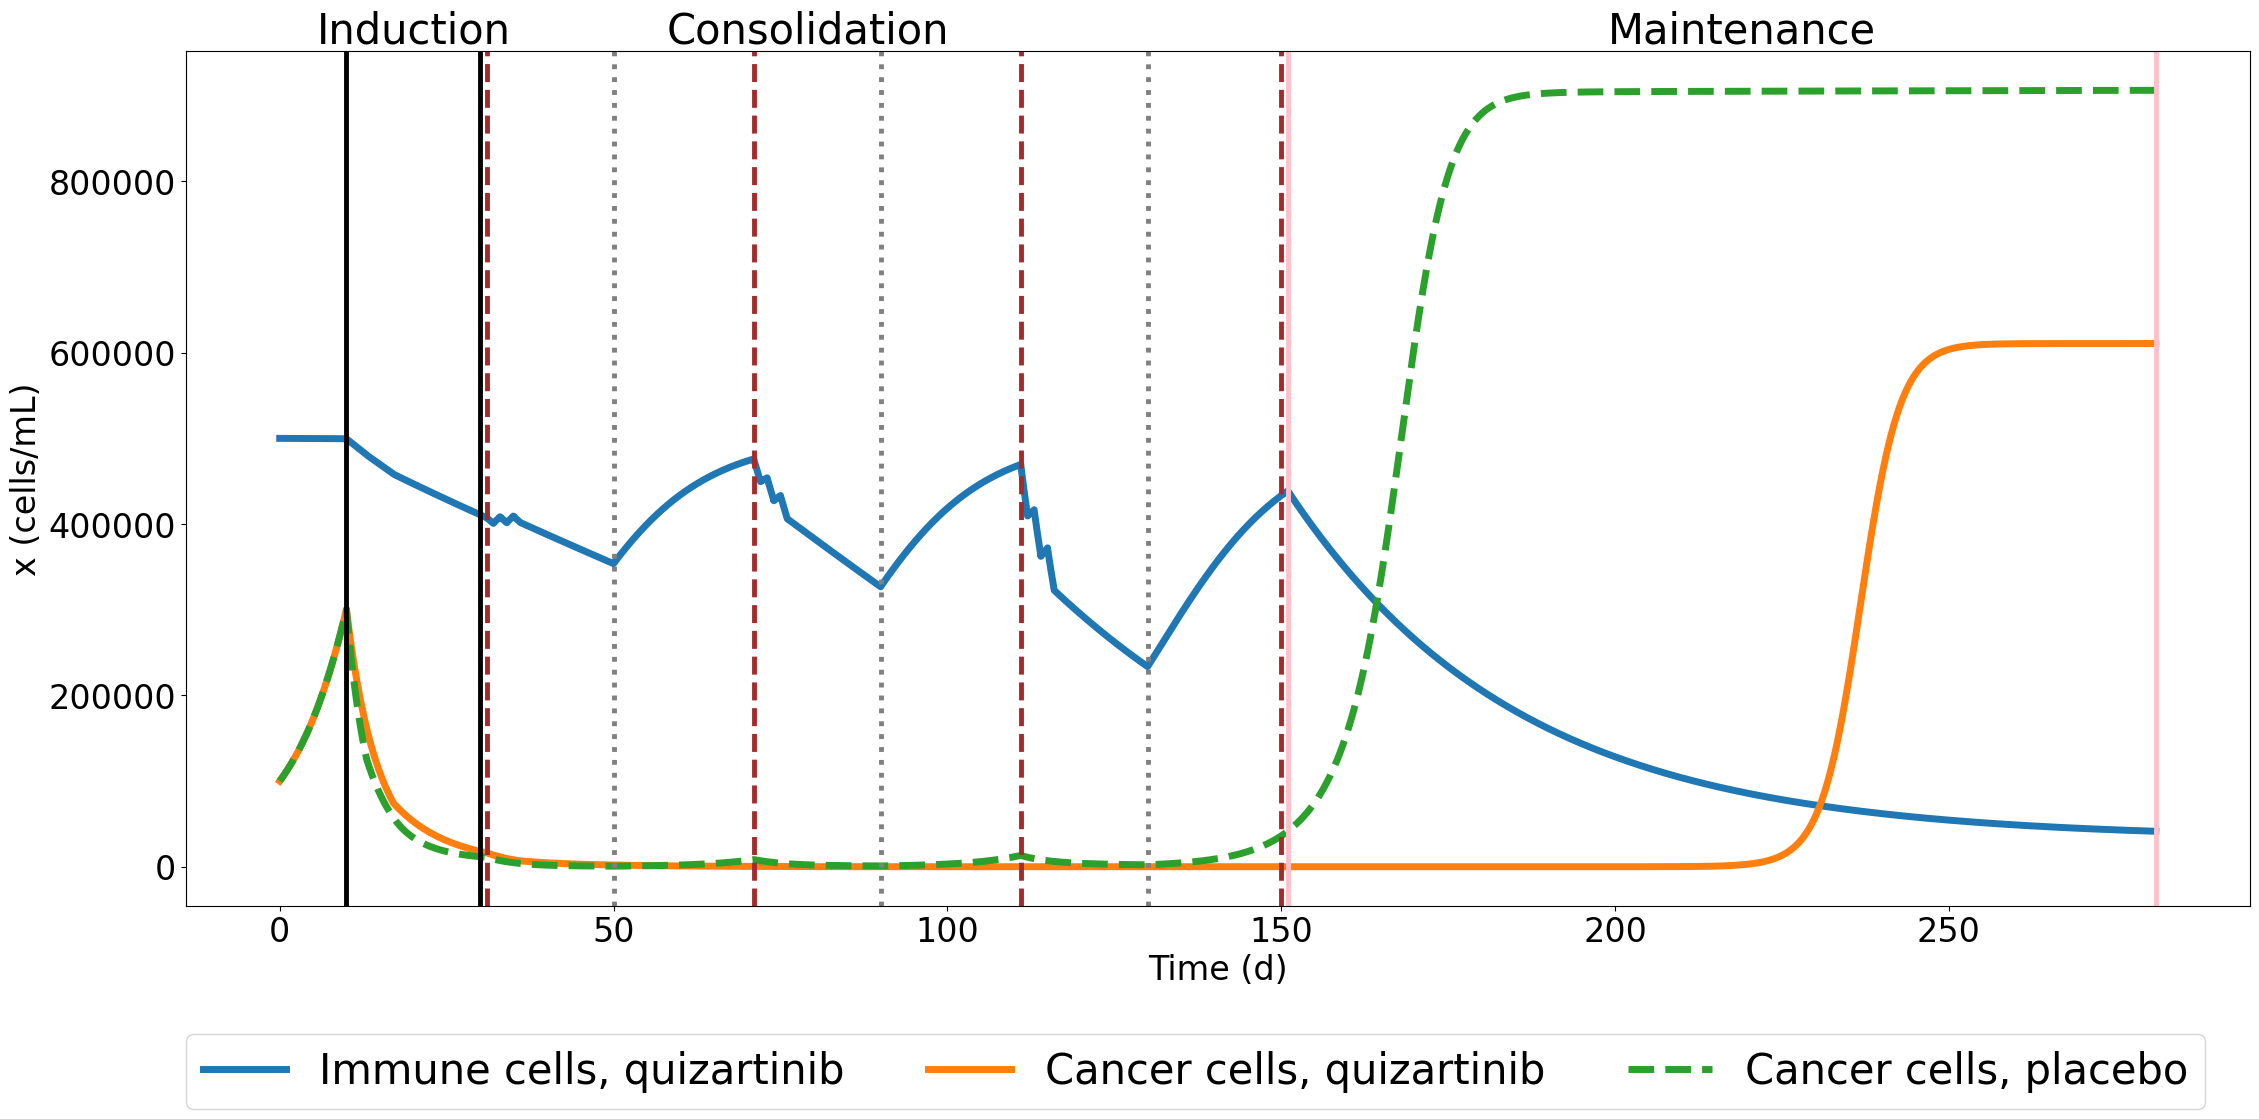

In [34]:
# Define treatment phases
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 130, mu_Q, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

treatment_phases_placebo = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CAQ, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Placebo', 14, mu_C, d, 14, 'Q', True),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Placebo', 14, mu_C, d, 14, 'C', True),
    ('Cell recovery', 21, mu_no_drug, d, 0, 'none', False),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Placebo', 14, mu_C, d, 14, 'C', True),
    ('Cell recovery', 21, mu_no_drug, d, 0, 'none', False),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Placebo', 14, mu_C, d, 14, 'C', True),
    ('Cell recovery', 21, mu_no_drug, d, 0, 'none', False),

    #Maintenance
    ('Placebo', 130, mu_no_drug, d, 0, 'none', False),
]


t_placebo, t_after_treatment_placebo, density_placebo, immune_placebo, sensitive_placebo, resistant_A_placebo, resistant_V_placebo, resistant_Q_placebo, resistant_C_placebo, t_values_placebo = simulate_treatment(treatment_phases_placebo, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(24.5, 12))
plt.plot(t, immune, label='Immune cells, quizartinib', linewidth=5.0)
#plt.plot(t_after_treatment, sensitive, label='Sensitive cells')
#plt.plot(t_after_treatment, resistant_Q, label='Resistant to Quizartinib')
#plt.plot(t_after_treatment, resistant_C, label='Resistant to Cytarabine')
plt.plot(t, density, label='Cancer cells, quizartinib', linewidth=5.0)

#plt.plot(t_placebo, immune_placebo, label='Immune cells, placebo')
plt.plot(t_placebo, density_placebo, label='Cancer cells, placebo', linewidth=5.0, linestyle='dashed')

# Annotate treatment phases 
phase_labels = ['Induction', 'Consolidation', 'Maintenance']
phase_starts = [daysBeforeTreatment - 5.5,
                daysBeforeTreatment + 47,
                daysBeforeTreatment + 188]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(density_placebo), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 20, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 21, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 61, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 80, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 101, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 120, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 140, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 271, color = 'pink', linewidth=3.5)

plt.rcParams.update({'font.size': 30})
plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('QuFirst_param.pdf', format='pdf', bbox_inches='tight')
plt.show()

Median overall survival 15.1 for placebo and 31.9 months. Is this reflected here. Grows way before this time. The difference. 

# Combining azacitidine and venetoclax

Median survival 14.1 months in venetoclax and 9.6 in the control group. 

In [35]:
mu_A = 0.19
mu_V = 0.16

mu_AV = 0.193

t = np.arange(0, 10 + dt, dt)
t_drug = np.arange(0, 7 + dt,dt)

popDensity_noDrug = odeint(growthRate, x0, t_drug, args=(K, mu_no_drug, r))
popDensity_azacitidine = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_A, r))
popDensity_venetoclax = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_V, r))

popDensity_av = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_AV, r))


print(f'survival after azacitidine: {((popDensity_azacitidine[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after venetoclax: {((popDensity_venetoclax[-1] / popDensity_noDrug[-1])[0]):.3f}')


print('-------------------')
print(f'survival after azacitidine + venetoclax, multiplication: {((popDensity_azacitidine[-1] / popDensity_noDrug[-1])[0]) * ((popDensity_venetoclax[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after azacitidine + venetoclax, new death rate: {((popDensity_av[-1] / popDensity_noDrug[-1])[0]):.3f}')

survival after azacitidine: 0.859
survival after venetoclax: 0.987
-------------------
survival after azacitidine + venetoclax, multiplication: 0.847
survival after azacitidine + venetoclax, new death rate: 0.846


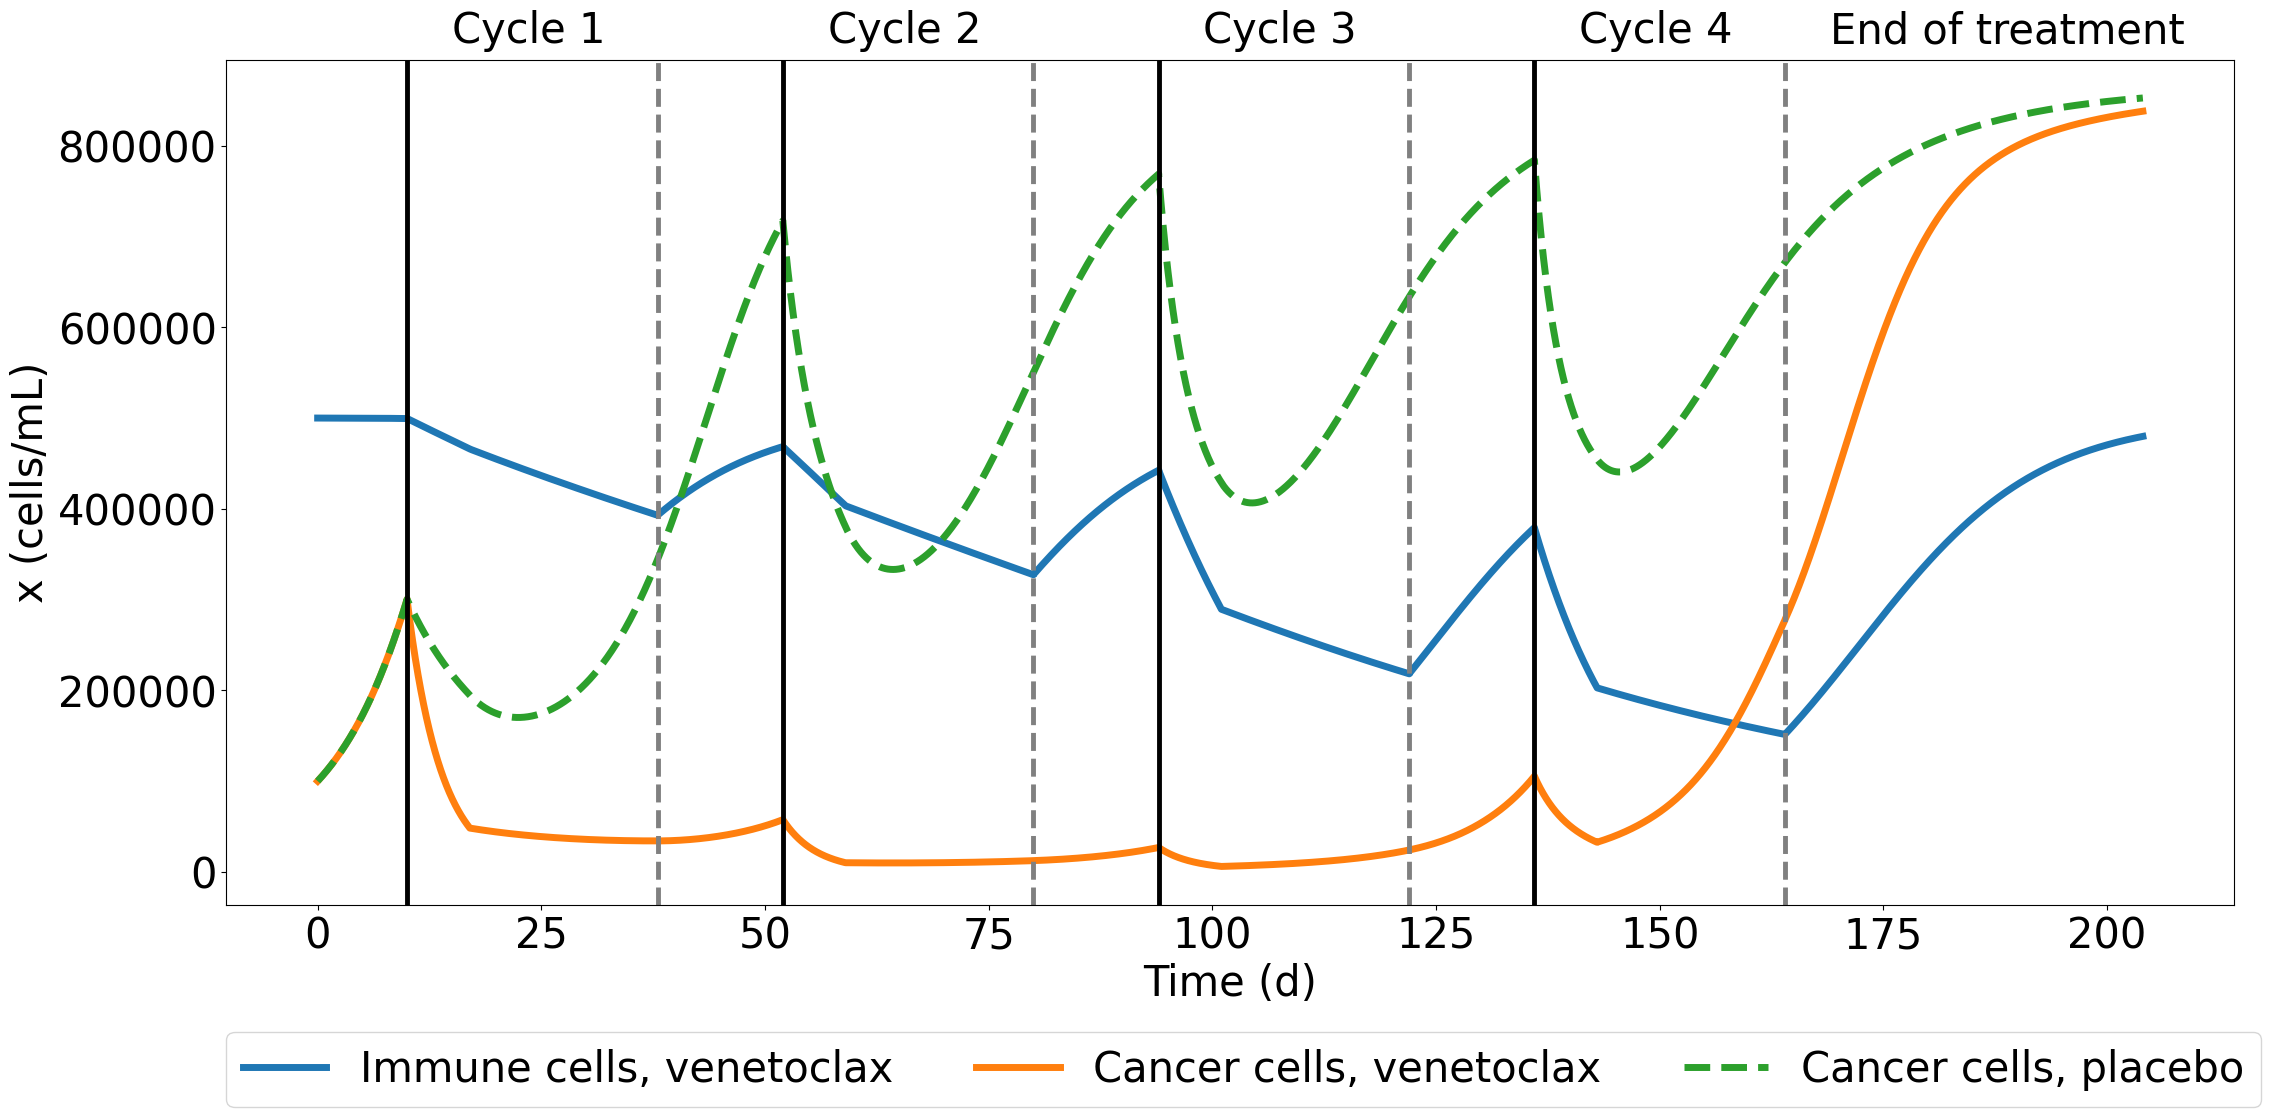

In [36]:
# Define treatment phases
d_max_V = 0.02 #Low impact on the immune system
d_max_A = 0.09
d_max_AV = 0.1

treatment_phases = [
    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 14, mu_V, d, 10, 'V', True),

    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 14, mu_V, d, 10, 'V', True),

    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 14, mu_V, d, 10, 'V', True),

    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 40, mu_V, d, 10, 'V', True),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

treatment_phases_placebo = [
    ('Azacitidine', 7, mu_A, d_max_A, 0, 'A', False),
    ('Placebo', 35, mu_A, d, 10, 'A', True),

    ('Azacitidine', 7, mu_A, d_max_A, 0, 'A', False),
    ('Placebo', 35, mu_A, d, 10, 'A', True),

    ('Azacitidine', 7, mu_A, d_max_A, 0, 'A', False),
    ('Placebo', 35, mu_A, d, 10, 'A', True),

    ('Azacitidine', 7, mu_A, d_max_A, 0, 'A', False),
    ('Placebo', 61, mu_A, d, 10, 'A', True),
]


t_placebo, t_after_treatment_placebo, density_placebo, immune_placebo, sensitive_placebo, resistant_A_placebo, resistant_V_placebo, resistant_Q_placebo, resistant_C_placebo, t_values_placebo = simulate_treatment(treatment_phases_placebo, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(24.5, 12))
plt.plot(t, immune, label='Immune cells, venetoclax', linewidth=5.0)
#plt.plot(t_after_treatment, sensitive, label='Sensitive cells')
#plt.plot(t_after_treatment, resistant_V, label='Resistant to Venetoclax')
#plt.plot(t_after_treatment, resistant_A, label='Resistant to Azacitidine')
plt.plot(t, density, label='Cancer cells, venetoclax', linewidth=5.0)

#plt.plot(t_placebo, immune_placebo, label='Immune cells, placebo')
plt.plot(t_placebo, density_placebo, label='Cancer cells, placebo', linewidth=5.0, linestyle='dashed')

# Annotate treatment cycles right after each begins
cycle_labels = ['Cycle 1', 'Cycle 2', 'Cycle 3', 'Cycle 4', 'End of treatment']
cycle_starts = [
    daysBeforeTreatment + 4,
    daysBeforeTreatment + 46,
    daysBeforeTreatment + 88,
    daysBeforeTreatment + 130,
    daysBeforeTreatment + 158
]

y_pos = max(max(density), max(density_placebo), max(immune)) * 1.06  # small offset above max y

for label, xpos in zip(cycle_labels, cycle_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 28, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 42, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 70, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 84, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 112, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 126, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 154, color = 'gray', linewidth=3.5, linestyle='dashed')


plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('AzacitidineVenetoclax_param.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Two induction cycles - QuANTUM - First


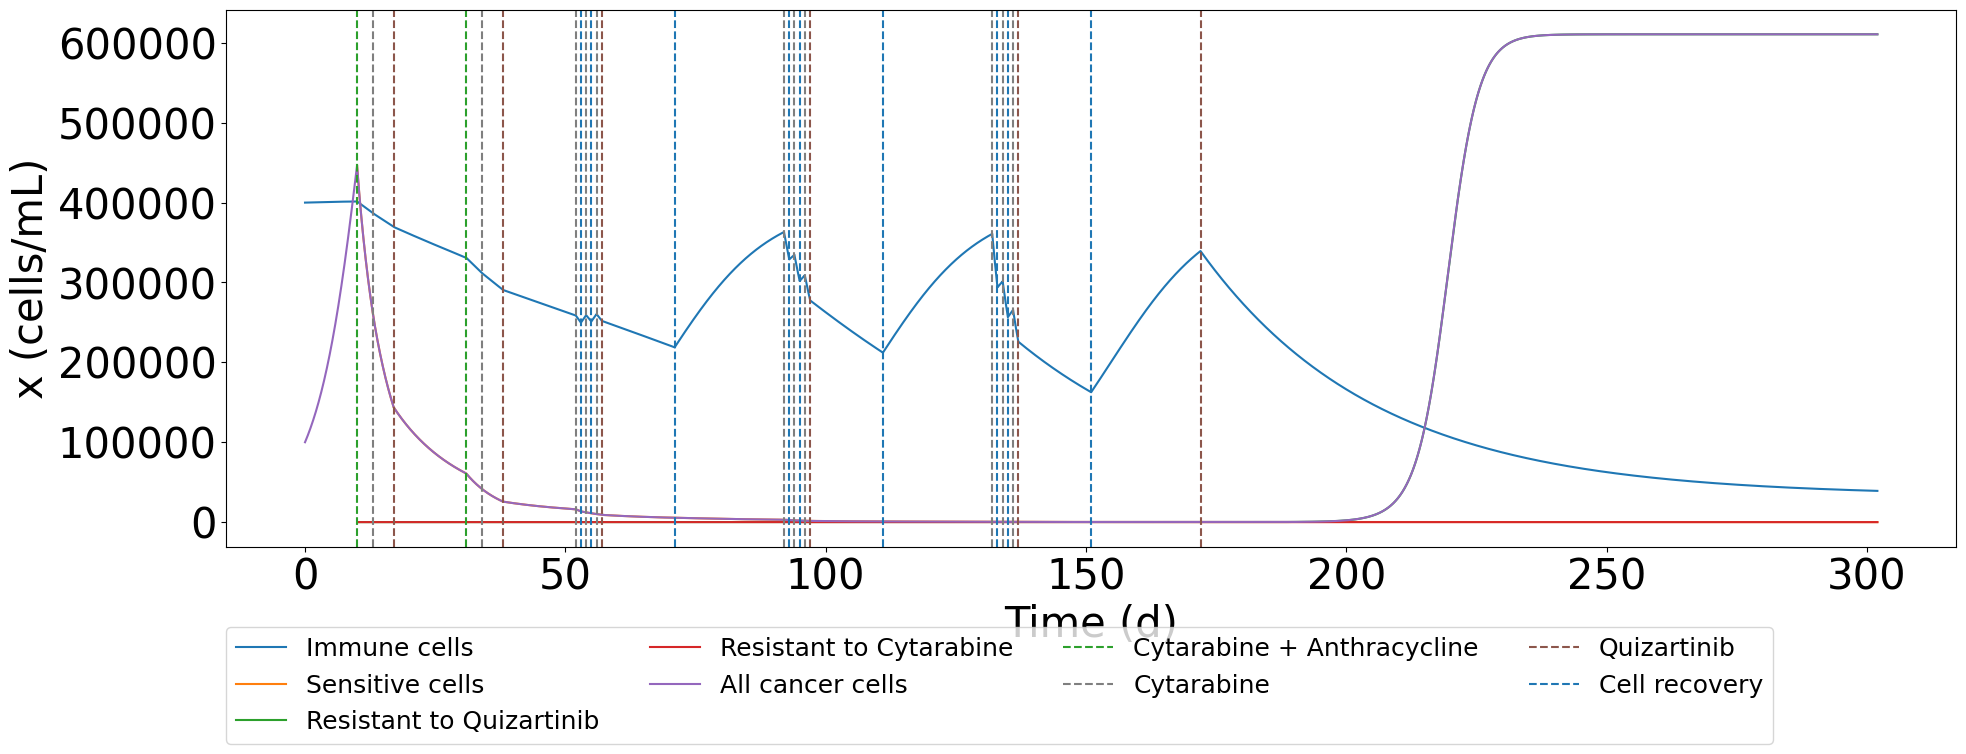

In [37]:
y0_lowerImmune = 4e5
nImmune_upper_lowerImmune = y0_lowerImmune

parameters_lowerImmune = [K, x0, r, n, y0_lowerImmune, nImmune_upper_lowerImmune, g, c, m, d, s, mu_Q, mu_C, mu_A, mu_V, a, b_Q, b_C, b_A, b_V, p_Q, p_C, p_A, p_V, tau, h]

treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Induction phase 2
    ('Cytarabine + Anthracycline', 3, mu_C, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),

    #Consolidation
    ('Cytarabine', 1, mu_CQ, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 130, mu_quizartinib, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters_lowerImmune)

plt.figure(figsize=(20, 8))
plt.plot(t, immune, label='Immune cells')
plt.plot(t_after_treatment, sensitive, label='Sensitive cells')
plt.plot(t_after_treatment, resistant_Q, label='Resistant to Quizartinib')
plt.plot(t_after_treatment, resistant_C, label='Resistant to Cytarabine')
plt.plot(t, density, label='All cancer cells')


treatment_colors = {}  
used_labels = set()  
colormap = plt.get_cmap("tab10") 

# Create a mapping of unique treatments to colors
unique_treatments = list(set(name for name, *_ in treatment_phases))  # Get unique treatment names
color_map = {name: colormap(i / len(unique_treatments)) for i, name in enumerate(unique_treatments)}

t_marker = daysBeforeTreatment

for name, duration, _, _, _, _, _ in treatment_phases:
    color = color_map[name]  # Assign color based on treatment name
    # Only add label to legend if it hasn't been used before
    if name not in used_labels:
        plt.axvline(x=t_marker, color=color, linestyle='dashed', label=name)
        used_labels.add(name)  # Mark this label as used
    else:
        plt.axvline(x=t_marker, color=color, linestyle='dashed')

    t_marker += duration

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 18})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.show()

Weaker immune system.

### Quizartinib in combination with induction and consolidation therapy

https://pmc.ncbi.nlm.nih.gov/articles/PMC6586071/?utm_source=chatgpt.com

**Induction:**
- 7+3 regimen like normal
- Quizartinib starts on day 4, continues for 7-14 (7 days 60mg/d, 14 days 60mg/d or 14 days 40mg/d) days depending on the dose.
- Patients could recieve a second induction cycle if needed.

**Consolidation:** 
- Cytarabine on day 1, 3 and 5.
- Quizartinib for 7 or 14 days depending on induction.
- Up to four cycles

**Maintenance:**
- Continous quizartinib in 28 day-cycles. Up to 12 cycles.

#### Quizartinib for 7 days,  one induction cycle, four consolidation cycles

Here I have used a way higher d_max for cytarabine than above. This is probably not realistic, but shows that when the immune system is suppressed, there are big concequences. 

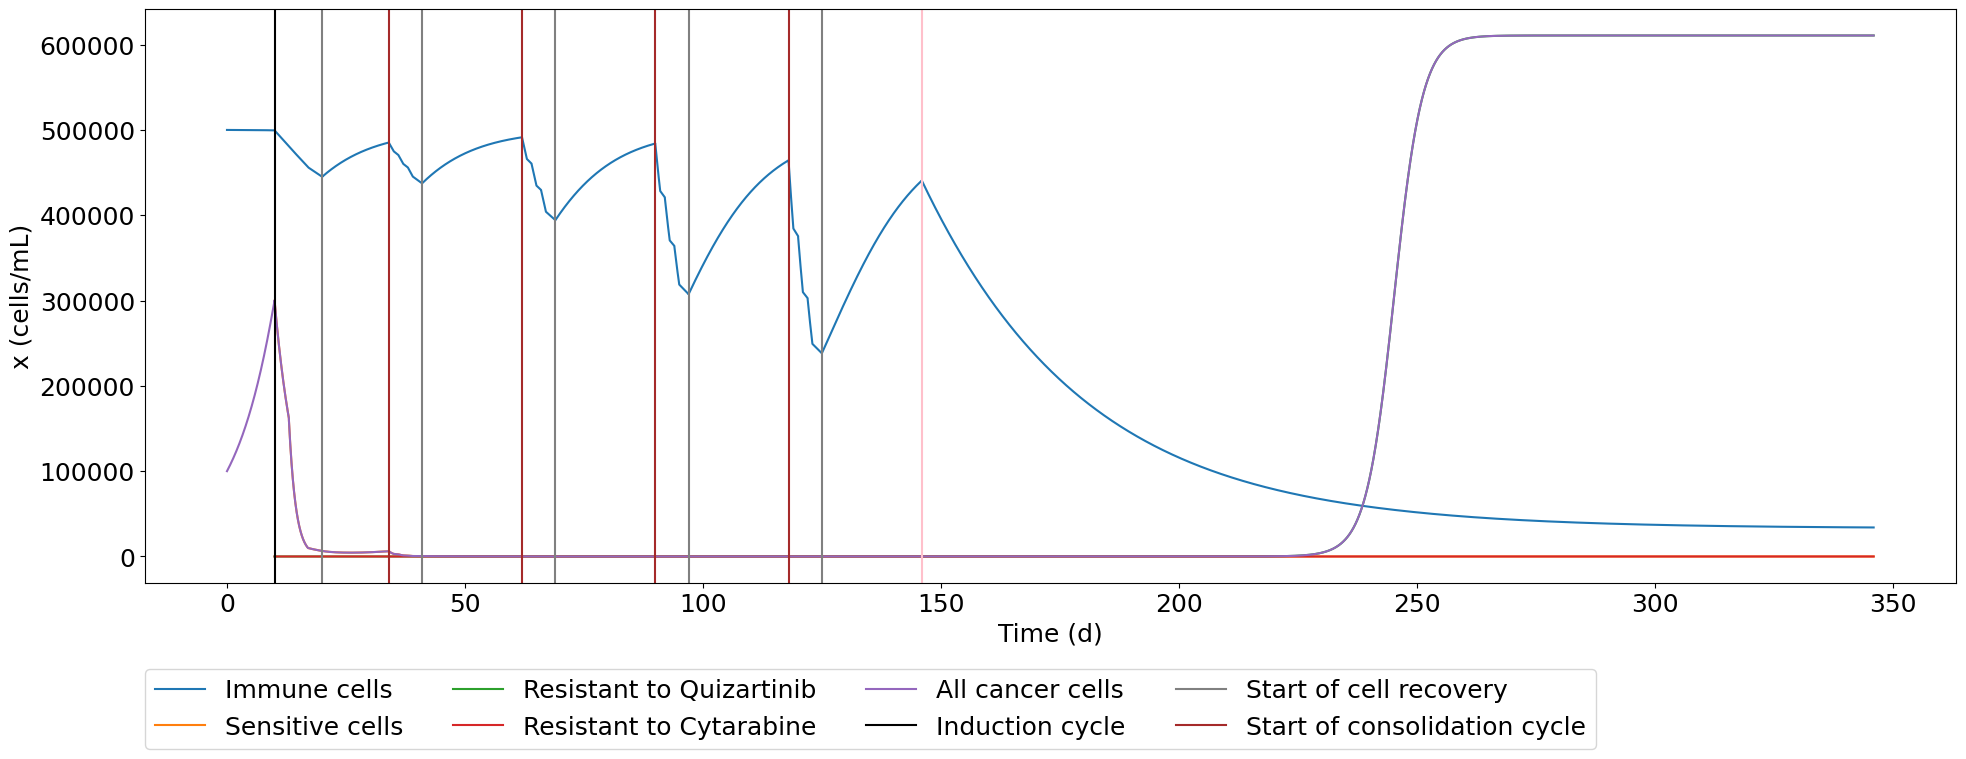

In [38]:
# Define treatment phases 
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine + Quizartinib', 4, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 3, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 5, 'Q', True),

    #Consolidation
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 2
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 3
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 4
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib Maintenance', 200, mu_quizartinib, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(20, 8))
plt.plot(t, immune, label='Immune cells')
plt.plot(t_after_treatment, sensitive, label='Sensitive cells')
plt.plot(t_after_treatment, resistant_Q, label='Resistant to Quizartinib')
plt.plot(t_after_treatment, resistant_C, label='Resistant to Cytarabine')
plt.plot(t, density, label='All cancer cells')

plt.axvline(daysBeforeTreatment, color = 'black', label = 'Induction cycle')
plt.axvline(daysBeforeTreatment + 10, color = 'gray', label = 'Start of cell recovery')
plt.axvline(daysBeforeTreatment + 24, color = 'brown', label = 'Start of consolidation cycle')
plt.axvline(daysBeforeTreatment + 31, color = 'gray')
plt.axvline(daysBeforeTreatment + 52, color = 'brown')
plt.axvline(daysBeforeTreatment + 59, color = 'gray')
plt.axvline(daysBeforeTreatment + 80, color = 'brown')
plt.axvline(daysBeforeTreatment + 87, color = 'gray')
plt.axvline(daysBeforeTreatment + 108, color = 'brown')
plt.axvline(daysBeforeTreatment + 115, color = 'gray')
plt.axvline(daysBeforeTreatment + 136, color = 'pink')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 18})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.show()

Higher toxicity leads to quicker resistance and growth of cancer cells. 

#### Quizartinib for 14 days

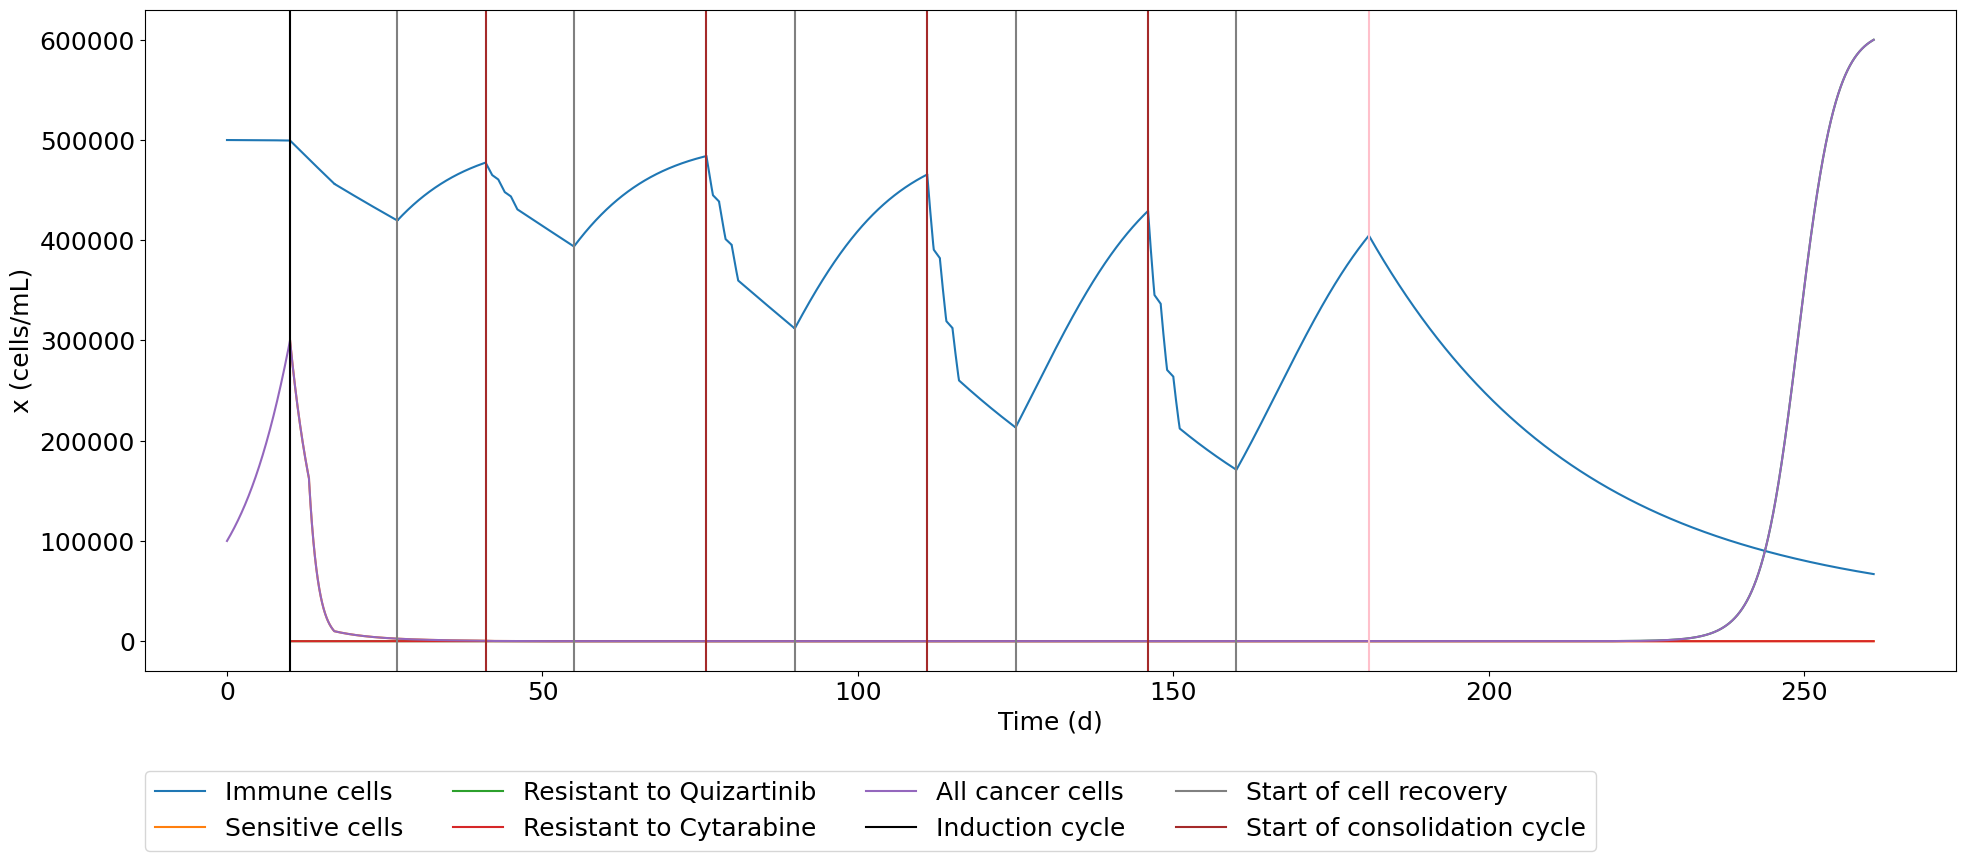

In [39]:
# Define treatment phases 
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine + Quizartinib', 4, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 10, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 9, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 2
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 9, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 3
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 9, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 4
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 9, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib Maintenance', 80, mu_quizartinib, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(20, 9))
plt.plot(t, immune, label='Immune cells')
plt.plot(t_after_treatment, sensitive, label='Sensitive cells')
plt.plot(t_after_treatment, resistant_Q, label='Resistant to Quizartinib')
plt.plot(t_after_treatment, resistant_C, label='Resistant to Cytarabine')
plt.plot(t, density, label='All cancer cells')

plt.axvline(daysBeforeTreatment, color = 'black', label = 'Induction cycle')
plt.axvline(daysBeforeTreatment + 17, color = 'gray', label = 'Start of cell recovery')
plt.axvline(daysBeforeTreatment + 31, color = 'brown', label = 'Start of consolidation cycle')
plt.axvline(daysBeforeTreatment + 45, color = 'gray')
plt.axvline(daysBeforeTreatment + 66, color = 'brown')
plt.axvline(daysBeforeTreatment + 80, color = 'gray')
plt.axvline(daysBeforeTreatment + 101, color = 'brown')
plt.axvline(daysBeforeTreatment + 115, color = 'gray')
plt.axvline(daysBeforeTreatment + 136, color = 'brown')
plt.axvline(daysBeforeTreatment + 150, color = 'gray')
plt.axvline(daysBeforeTreatment + 171, color = 'pink')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 18})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.show()

## Validation of treatment dynamics

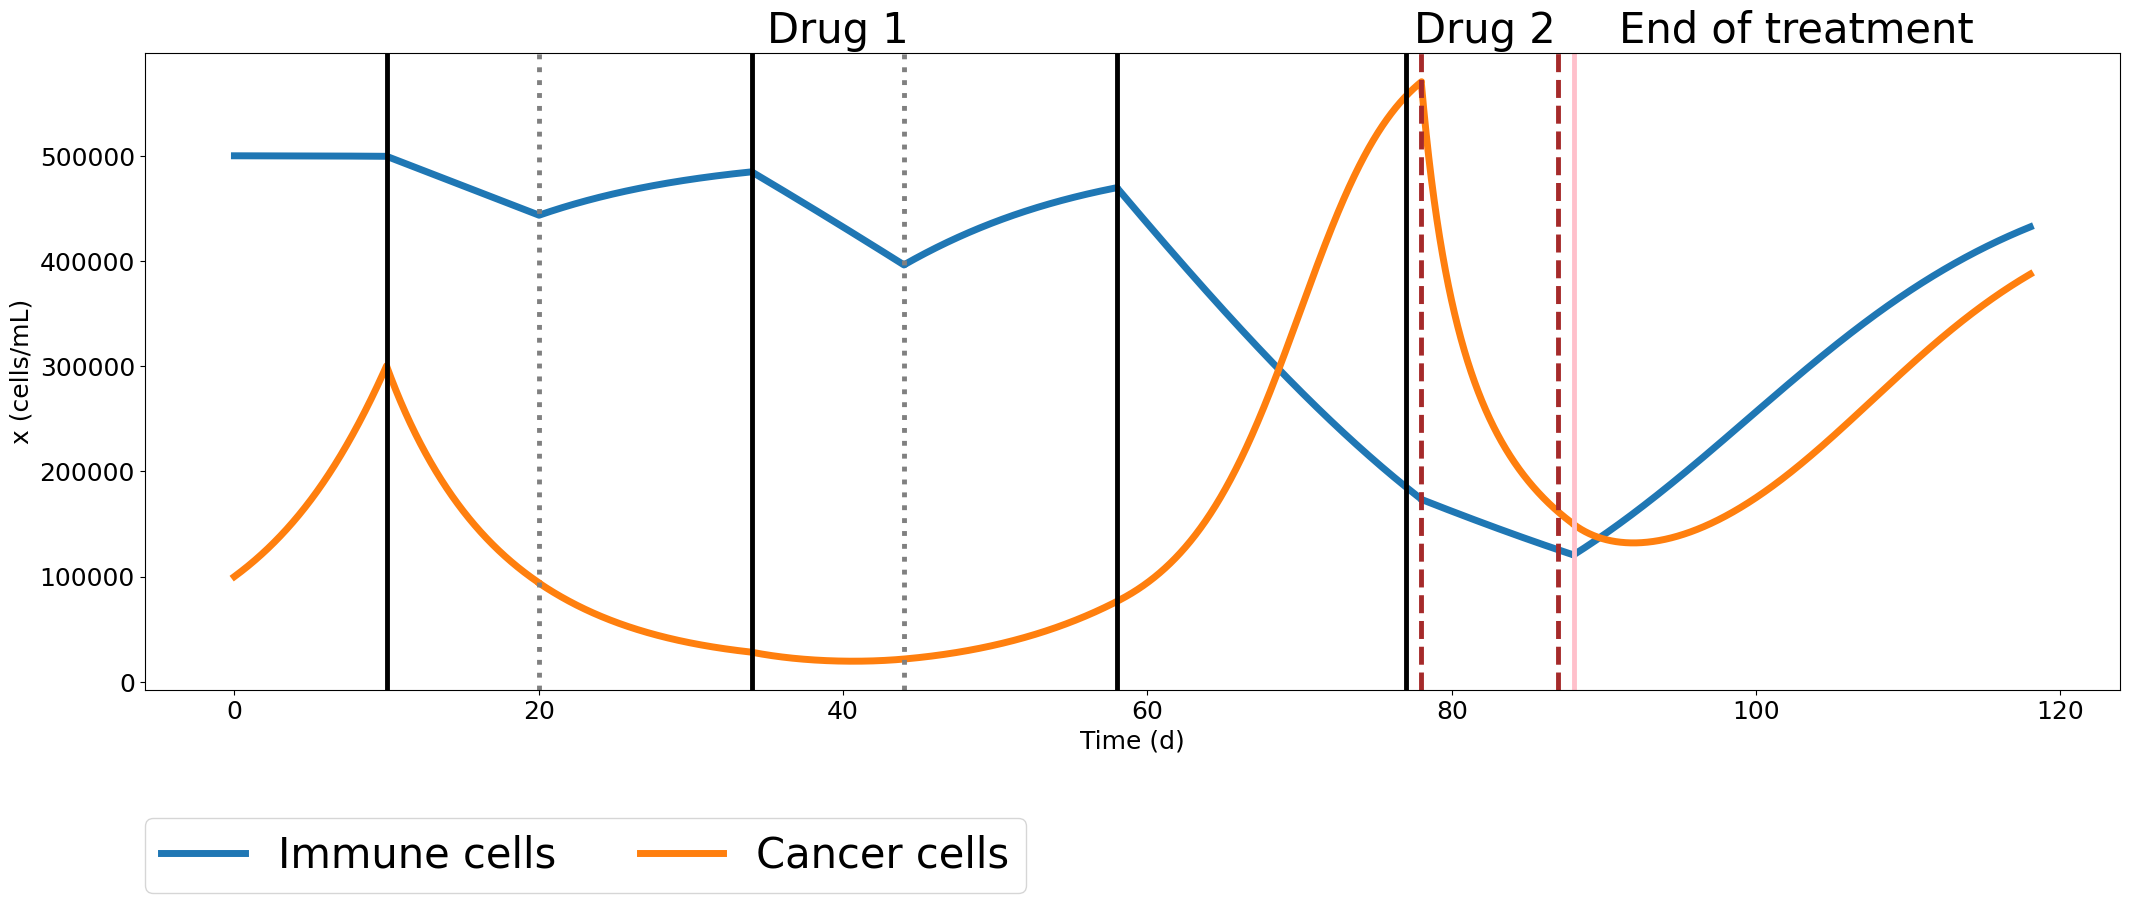

In [40]:
p_Q_validation = 1e-3 #turning up the probability to see results
parameters_validation = [K, x0, r, n, y0, nImmune_upper, g, c, m, d, s, mu_Q, mu_C, mu_A, mu_V, a, b_Q, b_C, b_A, b_V, p_Q_validation, p_C, p_A, p_V, tau, h]

treatment_phases = [
    #Induction phase
    ('Quizartinib', 10, mu_Q, d_max_C, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 10, mu_Q, d_max_C, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib Maintenance', 20, mu_Q, d_max_C, 0, 'Q', False),
    ('Cytarabine', 10, mu_C, d_max_A, 0, 'C', False),
    ('Cell recovery', 30, mu_C, d, 10, 'C', True),

]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters_validation)

# Plot results
plt.figure(figsize=(22, 10))
plt.plot(t, immune, label='Immune cells', linewidth=5.0)
plt.plot(t, density, label='Cancer cells', linewidth=5.0)

phase_labels = ['Drug 1', 'Drug 2', 'End of treatment']
phase_starts = [daysBeforeTreatment + 24,
                daysBeforeTreatment + 66.5,
                daysBeforeTreatment + 80]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 10, color='gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 24, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 34, color='gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 48, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 67, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 68, color='brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 77, color='brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 78, color='pink', linewidth=3.5)



plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('ValidationTreatment.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Testing other things

### QuANTUM-First with and without immune response

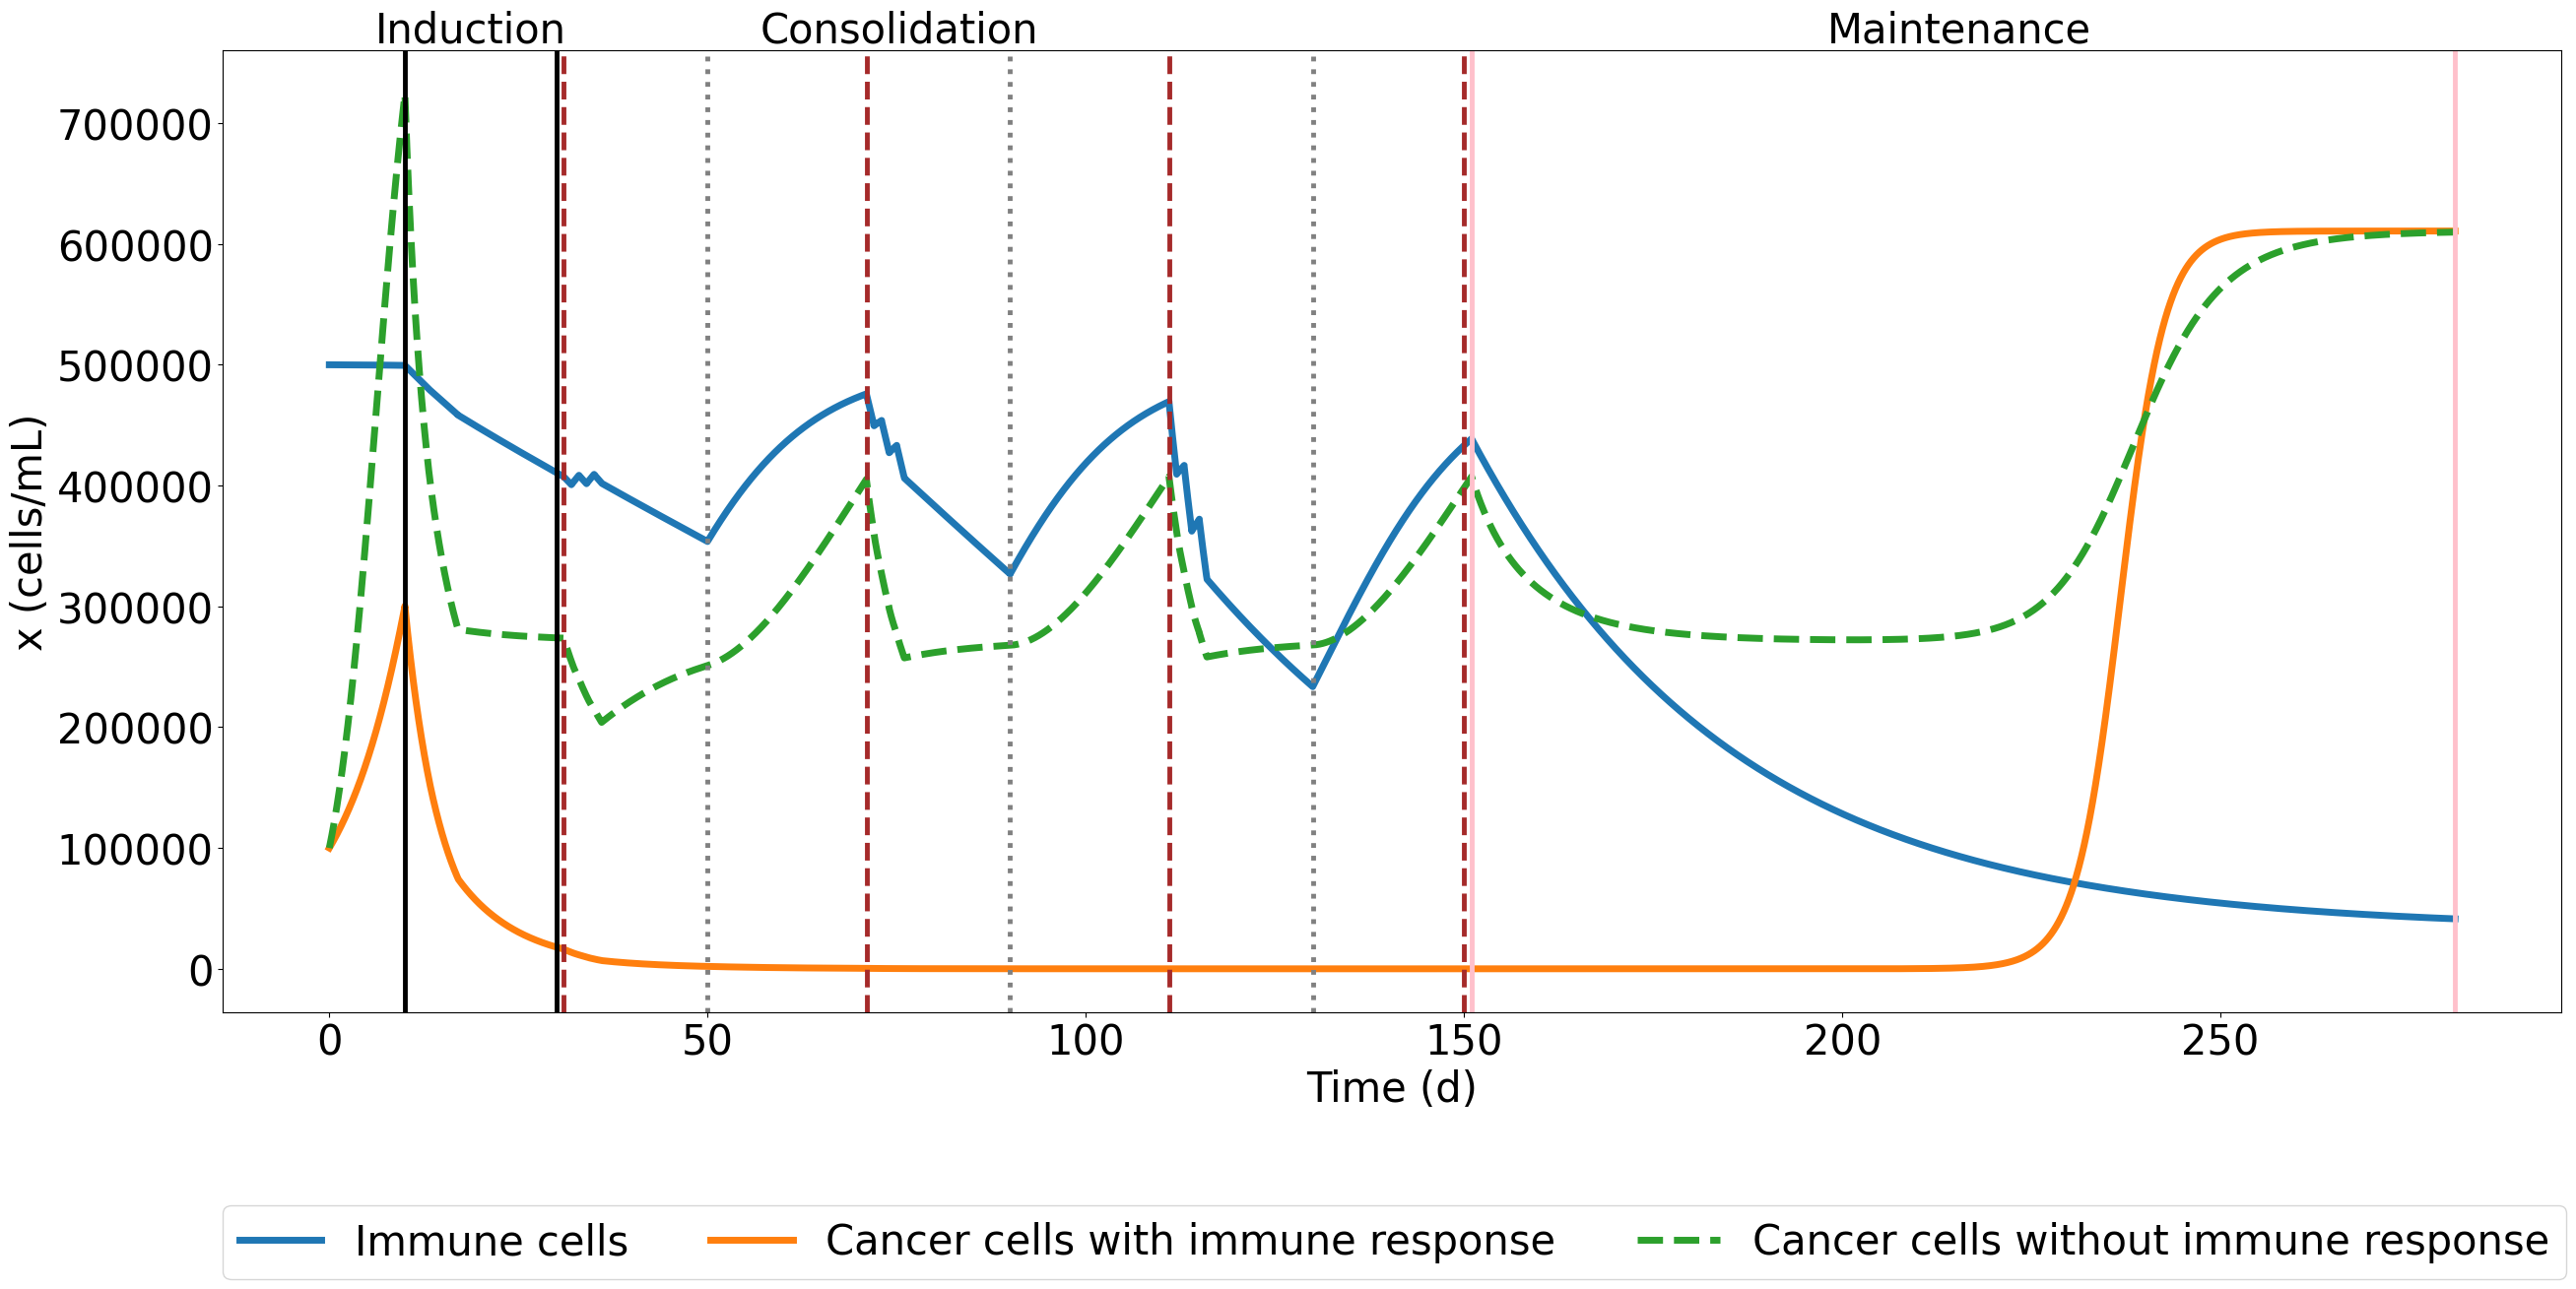

In [41]:
parameters_noImmune = [K, x0, r, n, 1, 0, 0, 0, 0, 0, 0, mu_Q, mu_C, mu_A, mu_V, a, b_Q, b_C, b_A, b_V, p_Q, p_C, p_A, p_V, tau, h]

treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 130, mu_Q, d_max_Q, 0, 'Q', False),
]

_, _, density_noImmune, _, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters_noImmune)
t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(28.5, 14))
plt.plot(t, immune, label='Immune cells', linewidth=5.0)
plt.plot(t, density, label='Cancer cells with immune response', linewidth=5.0)
plt.plot(t, density_noImmune, label = 'Cancer cells without immune response', linewidth=5.0, linestyle='dashed')

# Annotate treatment phases 
phase_labels = ['Induction', 'Consolidation', 'Maintenance']
phase_starts = [daysBeforeTreatment - 5,
                daysBeforeTreatment + 46,
                daysBeforeTreatment + 187]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(density_noImmune), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 20, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 21, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 61, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 80, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 101, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 120, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 140, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 271, color = 'pink', linewidth=3.5)

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncol=3, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('QuANTUM-First_immuneandnot.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Occurence of resistant cells in maintenance period

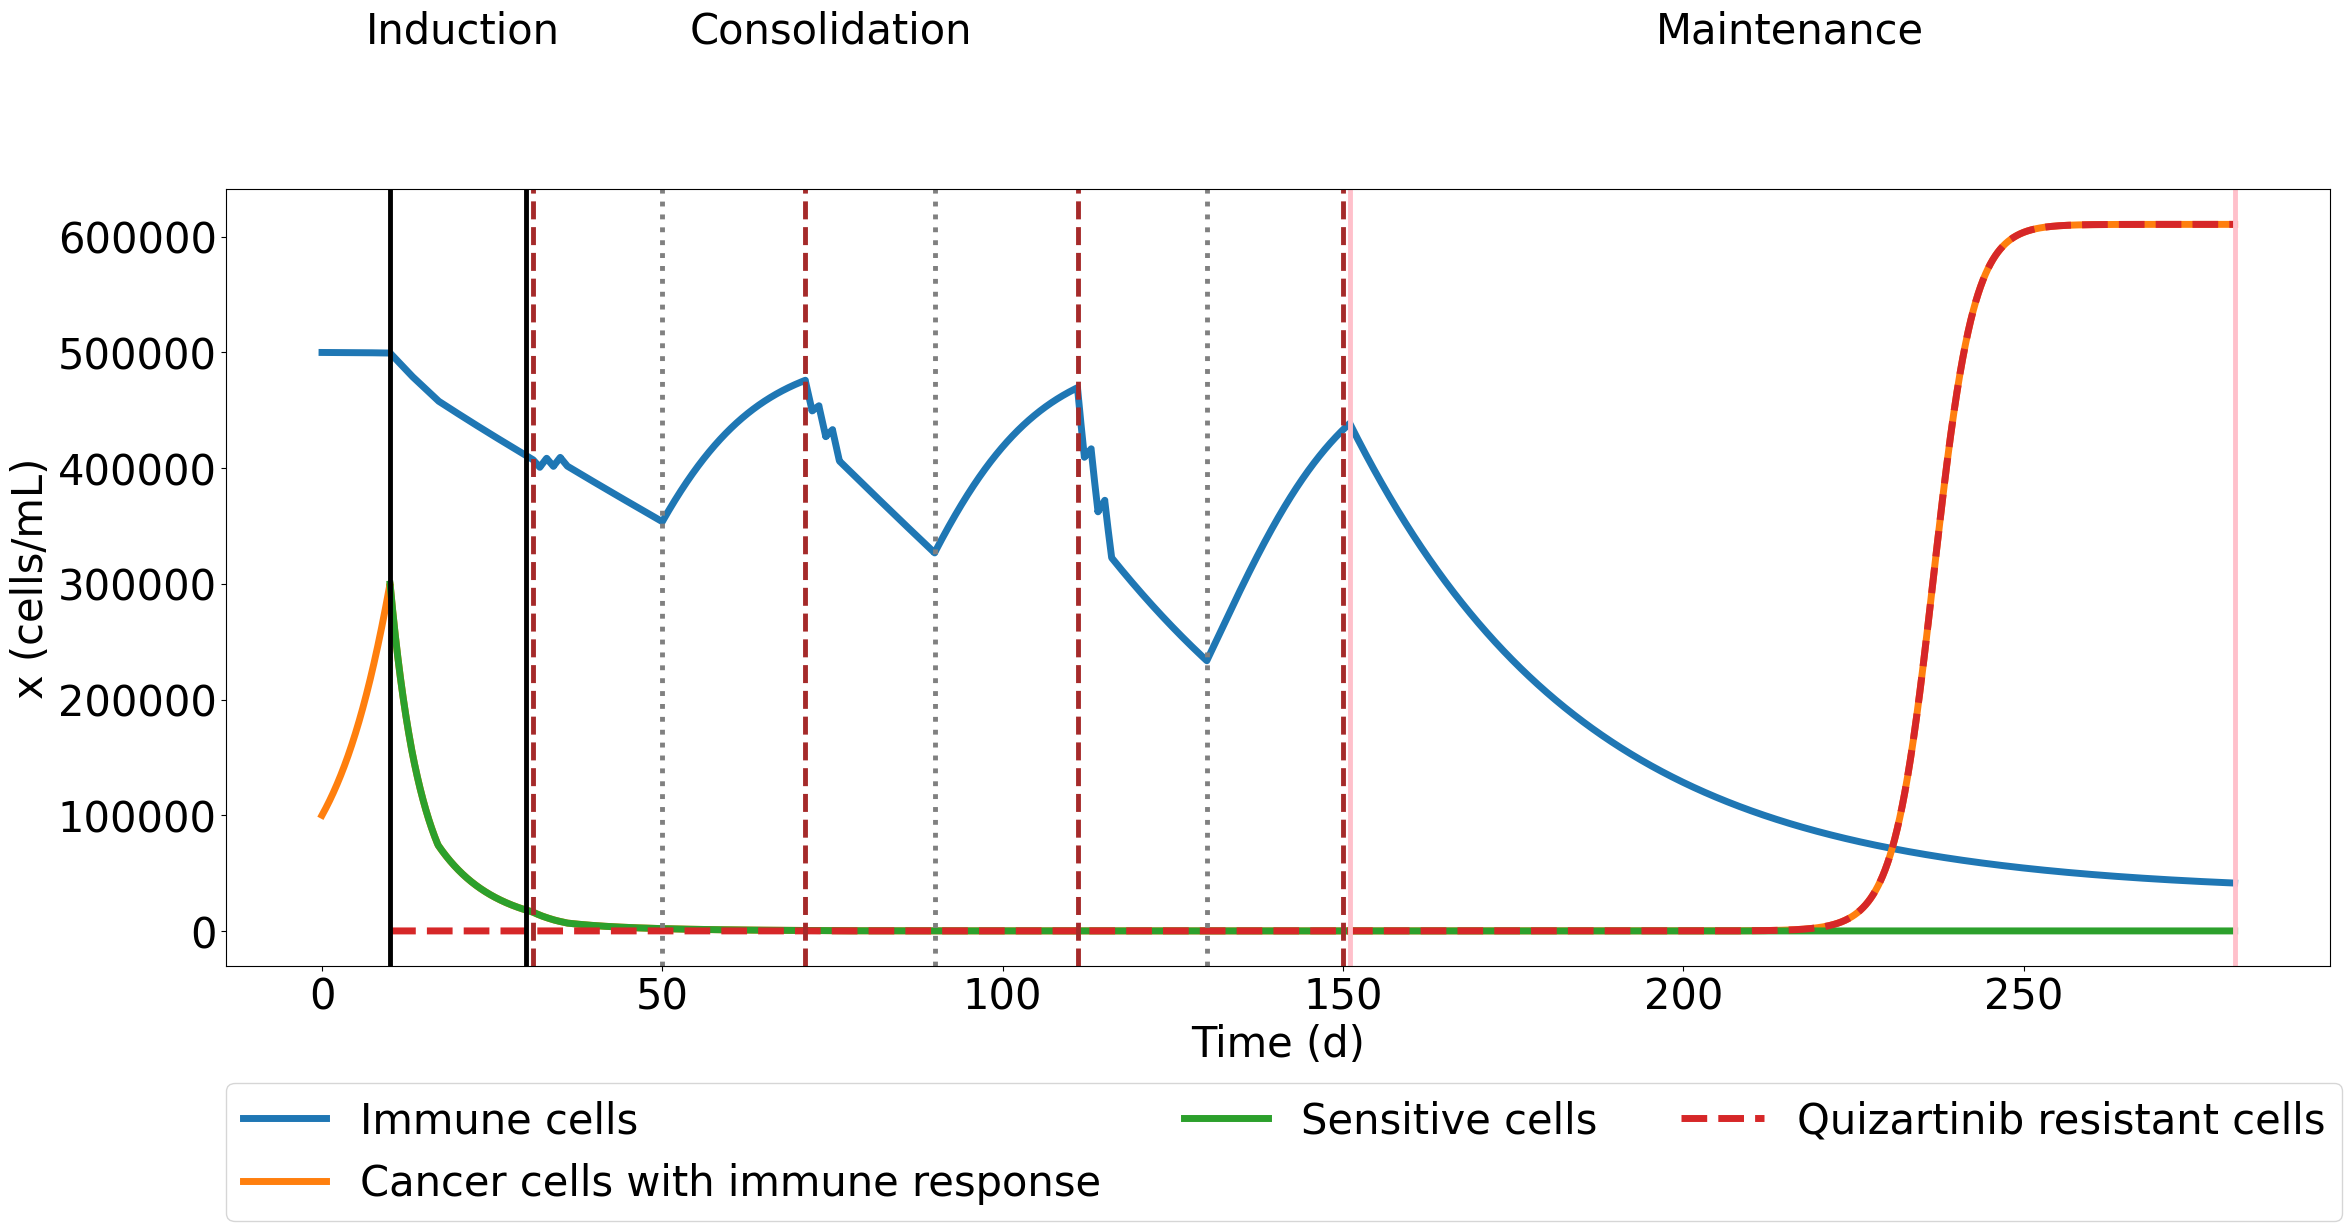

In [42]:
parameters_noImmune = [K, x0, r, n, 1, 0, 0, 0, 0, 0, 0, mu_Q, mu_C, mu_A, mu_V, a, b_Q, b_C, b_A, b_V, p_Q, p_C, p_A, p_V, tau, h]
p_Q_2 = 0
parameters_noresQ = [K, x0, r, n, y0, nImmune_upper, g, c, m, d, s, mu_Q, mu_C, mu_A, mu_V, a, b_Q, b_C, b_A, b_V, p_Q_2, p_C, p_A, p_V, tau, h]

treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 130, mu_Q, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(25.5, 14))
plt.plot(t, immune, label='Immune cells', linewidth=5.0)
plt.plot(t, density, label='Cancer cells with immune response', linewidth=5.0)
plt.plot(t_after_treatment, sensitive, label = 'Sensitive cells', linewidth=5.0)
plt.plot(t_after_treatment, resistant_Q, label='Quizartinib resistant cells', linewidth=5.0, linestyle='dashed')
#plt.plot(t_after_treatment, resistant_C, label='Cytarabine resistant cells')

# Annotate treatment phases 
phase_labels = ['Induction', 'Consolidation', 'Maintenance']
phase_starts = [daysBeforeTreatment - 4.5,
                daysBeforeTreatment + 43,
                daysBeforeTreatment + 185]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(density_noImmune), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 20, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 21, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 61, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 80, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 101, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 120, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 140, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 271, color = 'pink', linewidth=3.5)

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('QuANTUM-First_Res.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Investigating resistance properties

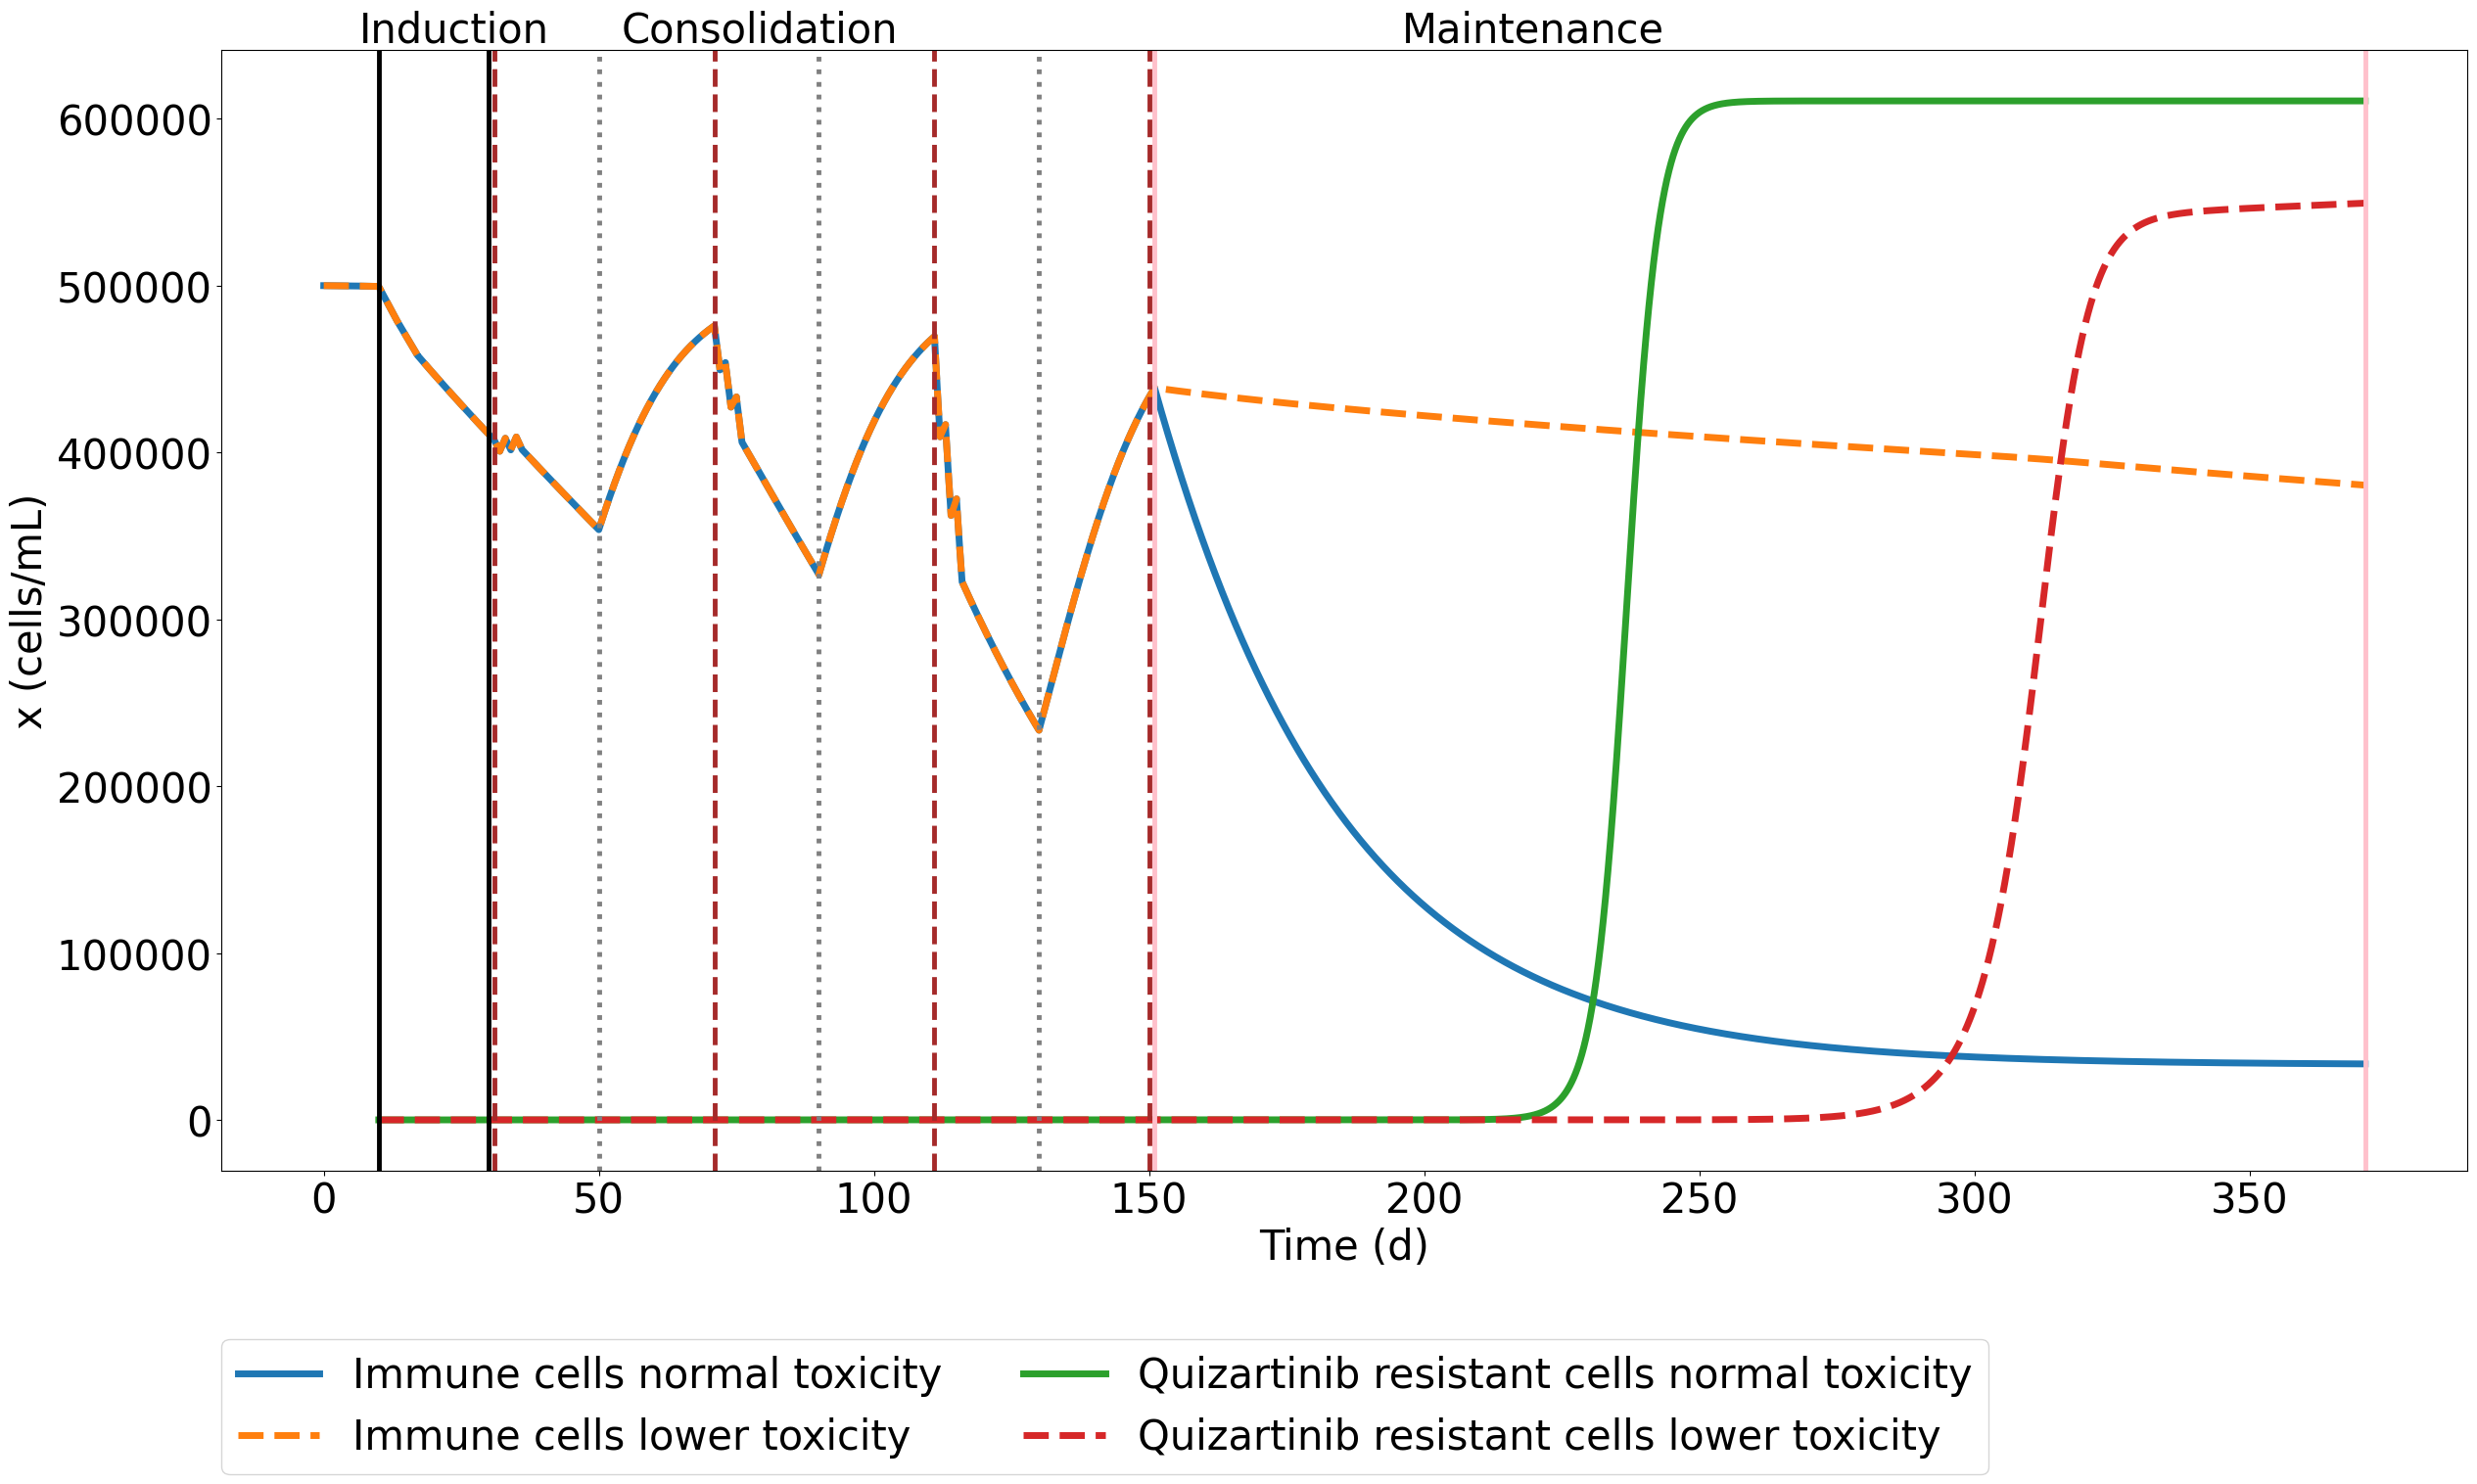

In [43]:
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 220, mu_Q, d_max_Q, 0, 'Q', False),
]
treatment_phases_lowTox = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 220, mu_Q, 1/10*d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)
_, _, _, immune_lowTox, _, _, _, resQ_lowTox, _, _, = simulate_treatment(treatment_phases_lowTox, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(26, 16))
plt.plot(t, immune, label='Immune cells normal toxicity', linewidth=5.0)
plt.plot(t, immune_lowTox, label='Immune cells lower toxicity', linewidth=5.0, linestyle='dashed')
plt.plot(t_after_treatment, resistant_Q, label='Quizartinib resistant cells normal toxicity', linewidth=5.0)
plt.plot(t_after_treatment, resQ_lowTox, label='Quizartinib resistant cells lower toxicity', linewidth=5.0, linestyle='dashed')

# Annotate treatment phases 
phase_labels = ['Induction', 'Consolidation', 'Maintenance']
phase_starts = [daysBeforeTreatment - 4.5,
                daysBeforeTreatment + 43,
                daysBeforeTreatment + 185]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(immune_lowTox), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 20, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 21, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 61, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 80, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 101, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 120, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 140, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 361, color = 'pink', linewidth=3.5)

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('QuANTUM-First_Res_lowTox.pdf', format='pdf', bbox_inches='tight')
plt.show()

### VIALE-A with and without immune response

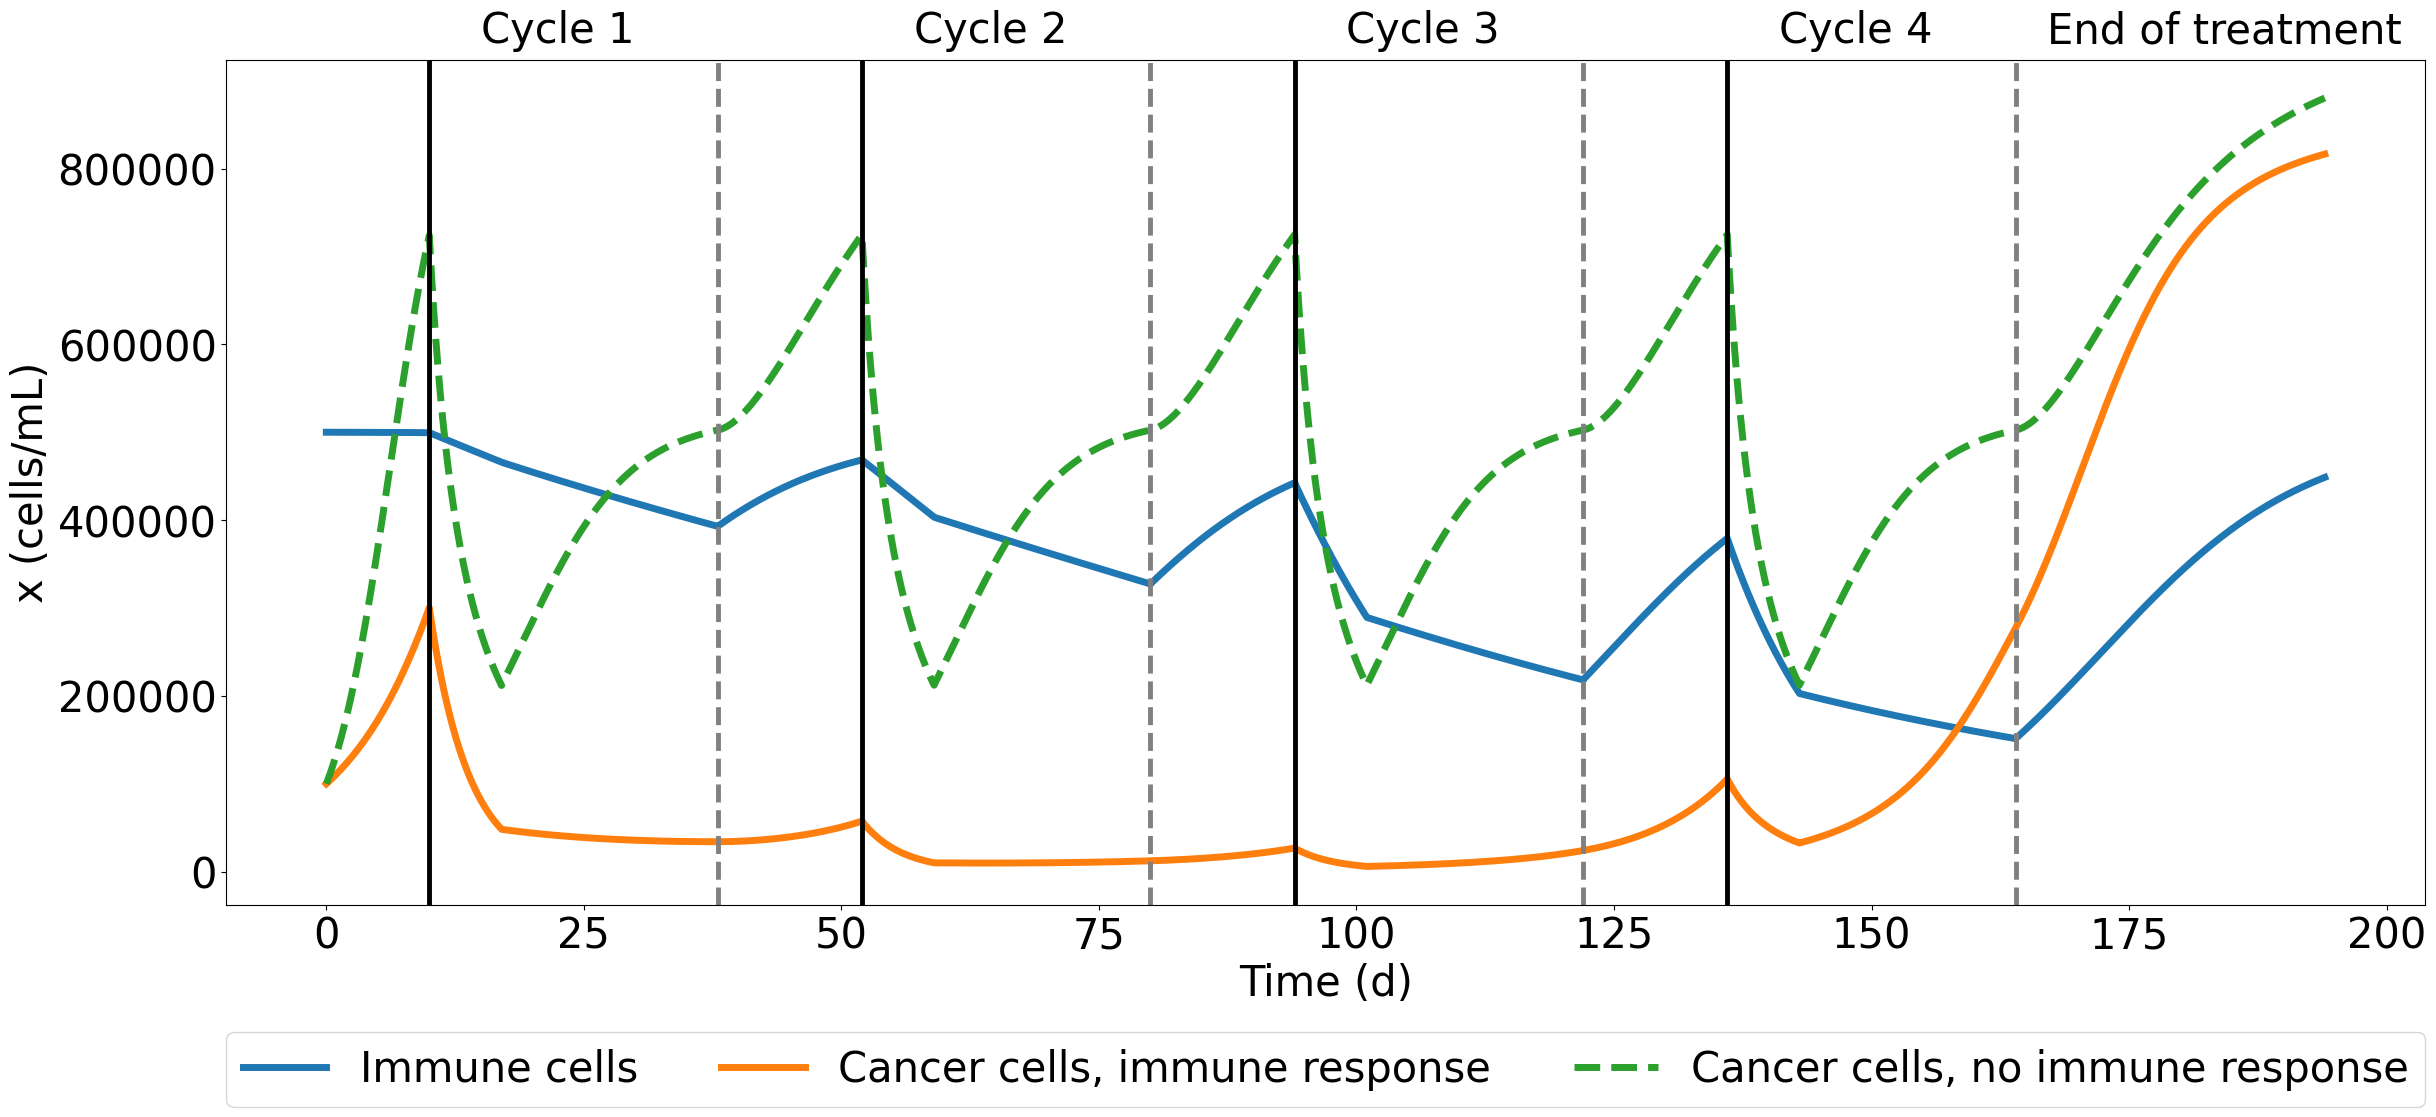

In [44]:
treatment_phases = [
    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 14, mu_V, d, 10, 'V', True),

    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 14, mu_V, d, 10, 'V', True),

    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 14, mu_V, d, 10, 'V', True),

    ('Azacitidine + Venetoclax', 7, mu_AV, d_max_AV, 0, 'AV', False),
    ('Venetoclax', 21, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 30, mu_V, d, 10, 'V', True),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)
_, _, density_noImmune, _, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters_noImmune)

# Plot results
plt.figure(figsize=(26.5, 12))
plt.plot(t, immune, label='Immune cells', linewidth=5.0)
plt.plot(t, density, label='Cancer cells, immune response', linewidth=5.0)
plt.plot(t, density_noImmune, label = 'Cancer cells, no immune response', linewidth=5.0, linestyle='dashed')

# Annotate treatment cycles right after each begins
cycle_labels = ['Cycle 1', 'Cycle 2', 'Cycle 3', 'Cycle 4', 'End of treatment']
cycle_starts = [
    daysBeforeTreatment + 4,
    daysBeforeTreatment + 46,
    daysBeforeTreatment + 88,
    daysBeforeTreatment + 130,
    daysBeforeTreatment + 156
]

y_pos = max(max(density), max(density_noImmune), max(immune)) * 1.06  # small offset above max y

for label, xpos in zip(cycle_labels, cycle_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 28, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 42, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 70, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 84, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 112, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 126, color = 'black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 154, color = 'gray', linewidth=3.5, linestyle='dashed')


plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('VIALEA.pdf', format='pdf', bbox_inches='tight')
plt.show()

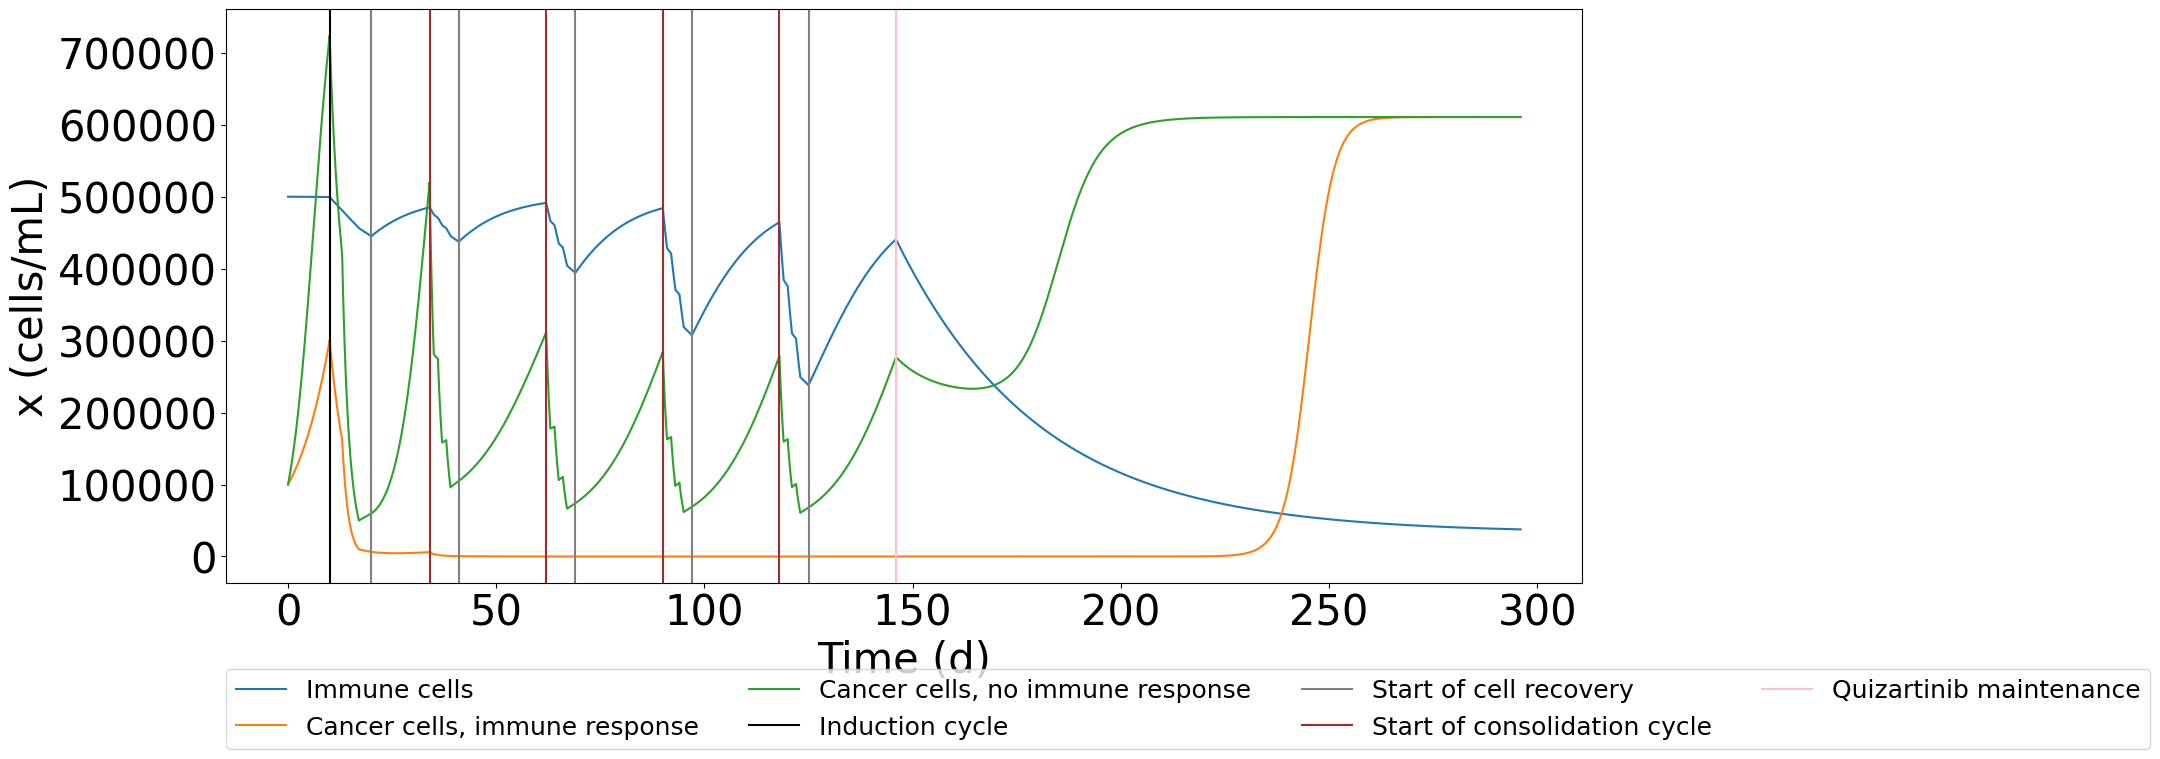

In [45]:
# Define treatment phases 
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine + Quizartinib', 4, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 3, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 5, 'Q', True),

    #Consolidation
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 2
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 3
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Consolidation cycle 4
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_cq, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 2, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib Maintenance', 150, mu_quizartinib, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)
_, _, density_noImmune, _, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters_noImmune)

# Plot results
plt.figure(figsize=(20, 8))
plt.plot(t, immune, label='Immune cells')
plt.plot(t, density, label='Cancer cells, immune response')
plt.plot(t, density_noImmune, label = 'Cancer cells, no immune response')

plt.axvline(daysBeforeTreatment, color = 'black', label = 'Induction cycle')
plt.axvline(daysBeforeTreatment + 10, color = 'gray', label = 'Start of cell recovery')
plt.axvline(daysBeforeTreatment + 24, color = 'brown', label = 'Start of consolidation cycle')
plt.axvline(daysBeforeTreatment + 31, color = 'gray')
plt.axvline(daysBeforeTreatment + 52, color = 'brown')
plt.axvline(daysBeforeTreatment + 59, color = 'gray')
plt.axvline(daysBeforeTreatment + 80, color = 'brown')
plt.axvline(daysBeforeTreatment + 87, color = 'gray')
plt.axvline(daysBeforeTreatment + 108, color = 'brown')
plt.axvline(daysBeforeTreatment + 115, color = 'gray')
plt.axvline(daysBeforeTreatment + 136, color = 'pink', label='Quizartinib maintenance')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 18})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.show()

In all three cases it is evident that the immune system is important, it keeps the cell population down for a while. However, we see that in our cases where we use quizartinib maintenance therapy, that will kill of the immune system so that it no longer has an effect. Maybe not too realistic that it looks like this?

### QuANTUM-First trial, cell recovery within quizartinib maintenance

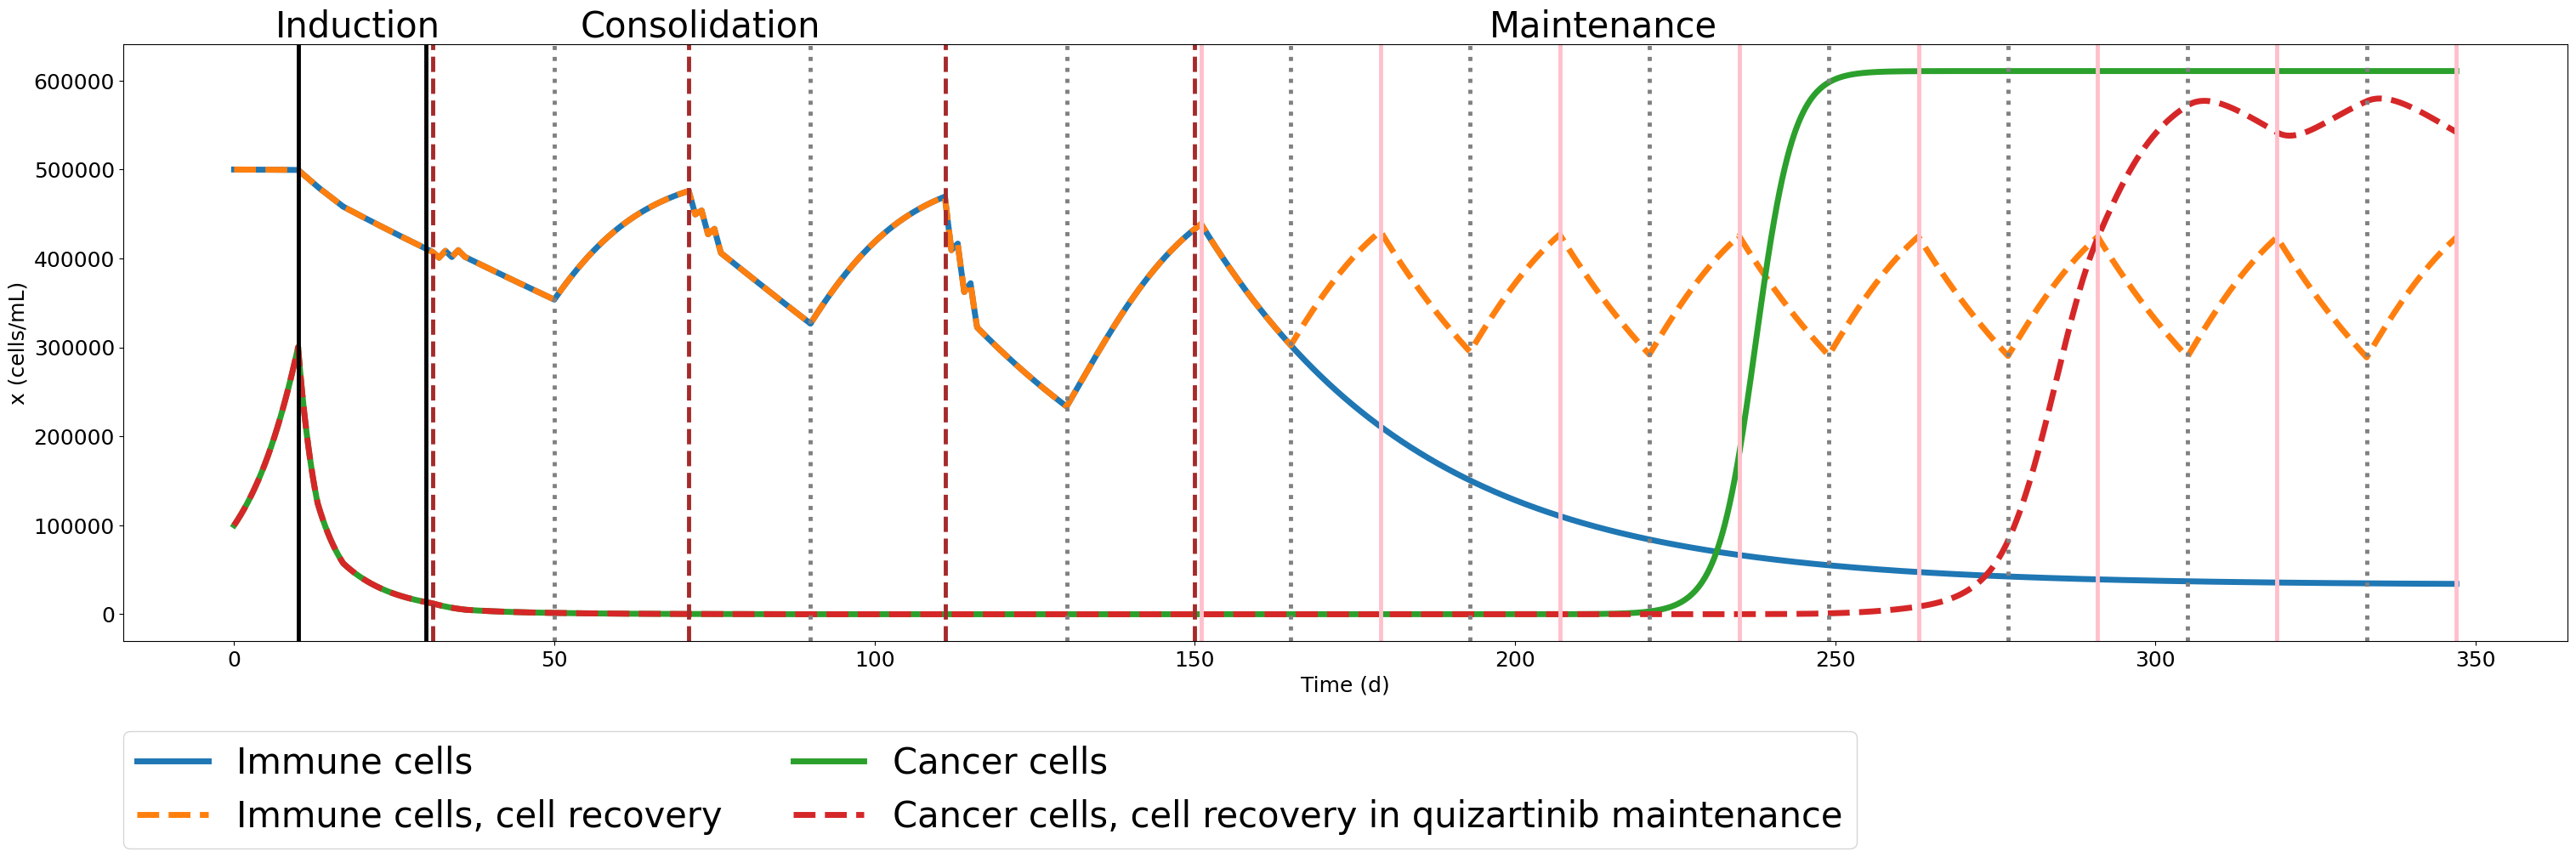

In [46]:
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CAQ, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 196, mu_Q, d_max_Q, 0, 'Q', False),
]

treatment_phases_cellRecovery = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CAQ, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
]
t_q, _, popDensity_quizartinibChange, immune_q, _, _, _, _, _, _ = simulate_treatment(treatment_phases_cellRecovery, daysBeforeTreatment, parameters)
t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)


# Plot results
plt.figure(figsize=(31, 11))
plt.plot(t, immune, label='Immune cells', linewidth=5.0)
plt.plot(t_q, immune_q, label='Immune cells, cell recovery', linewidth=5.0, linestyle='dashed')
plt.plot(t, density, label='Cancer cells', linewidth=5.0)
plt.plot(t_q, popDensity_quizartinibChange, label='Cancer cells, cell recovery in quizartinib maintenance', linewidth=5.0, linestyle='dashed')

# Annotate treatment phases 
phase_labels = ['Induction', 'Consolidation', 'Maintenance']
phase_starts = [daysBeforeTreatment - 4.5,
                daysBeforeTreatment + 43,
                daysBeforeTreatment + 185]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(immune_q), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)


plt.axvline(daysBeforeTreatment, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 20, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 21, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 61, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 80, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 101, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 120, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 140, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 155, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 169, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 183, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 197, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 211, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 225, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 239, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 253, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 267, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 281, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 295, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 309, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 323, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 337, color = 'pink', linewidth=3.5)

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('QuzRecovery_14_low.pdf', format='pdf', bbox_inches='tight')
plt.show()

When the immune cell population is allowed to recover, they are able to keep the population of cancer cells down for a longer period. 

We try to turn down the length of the periods of quizartinib.

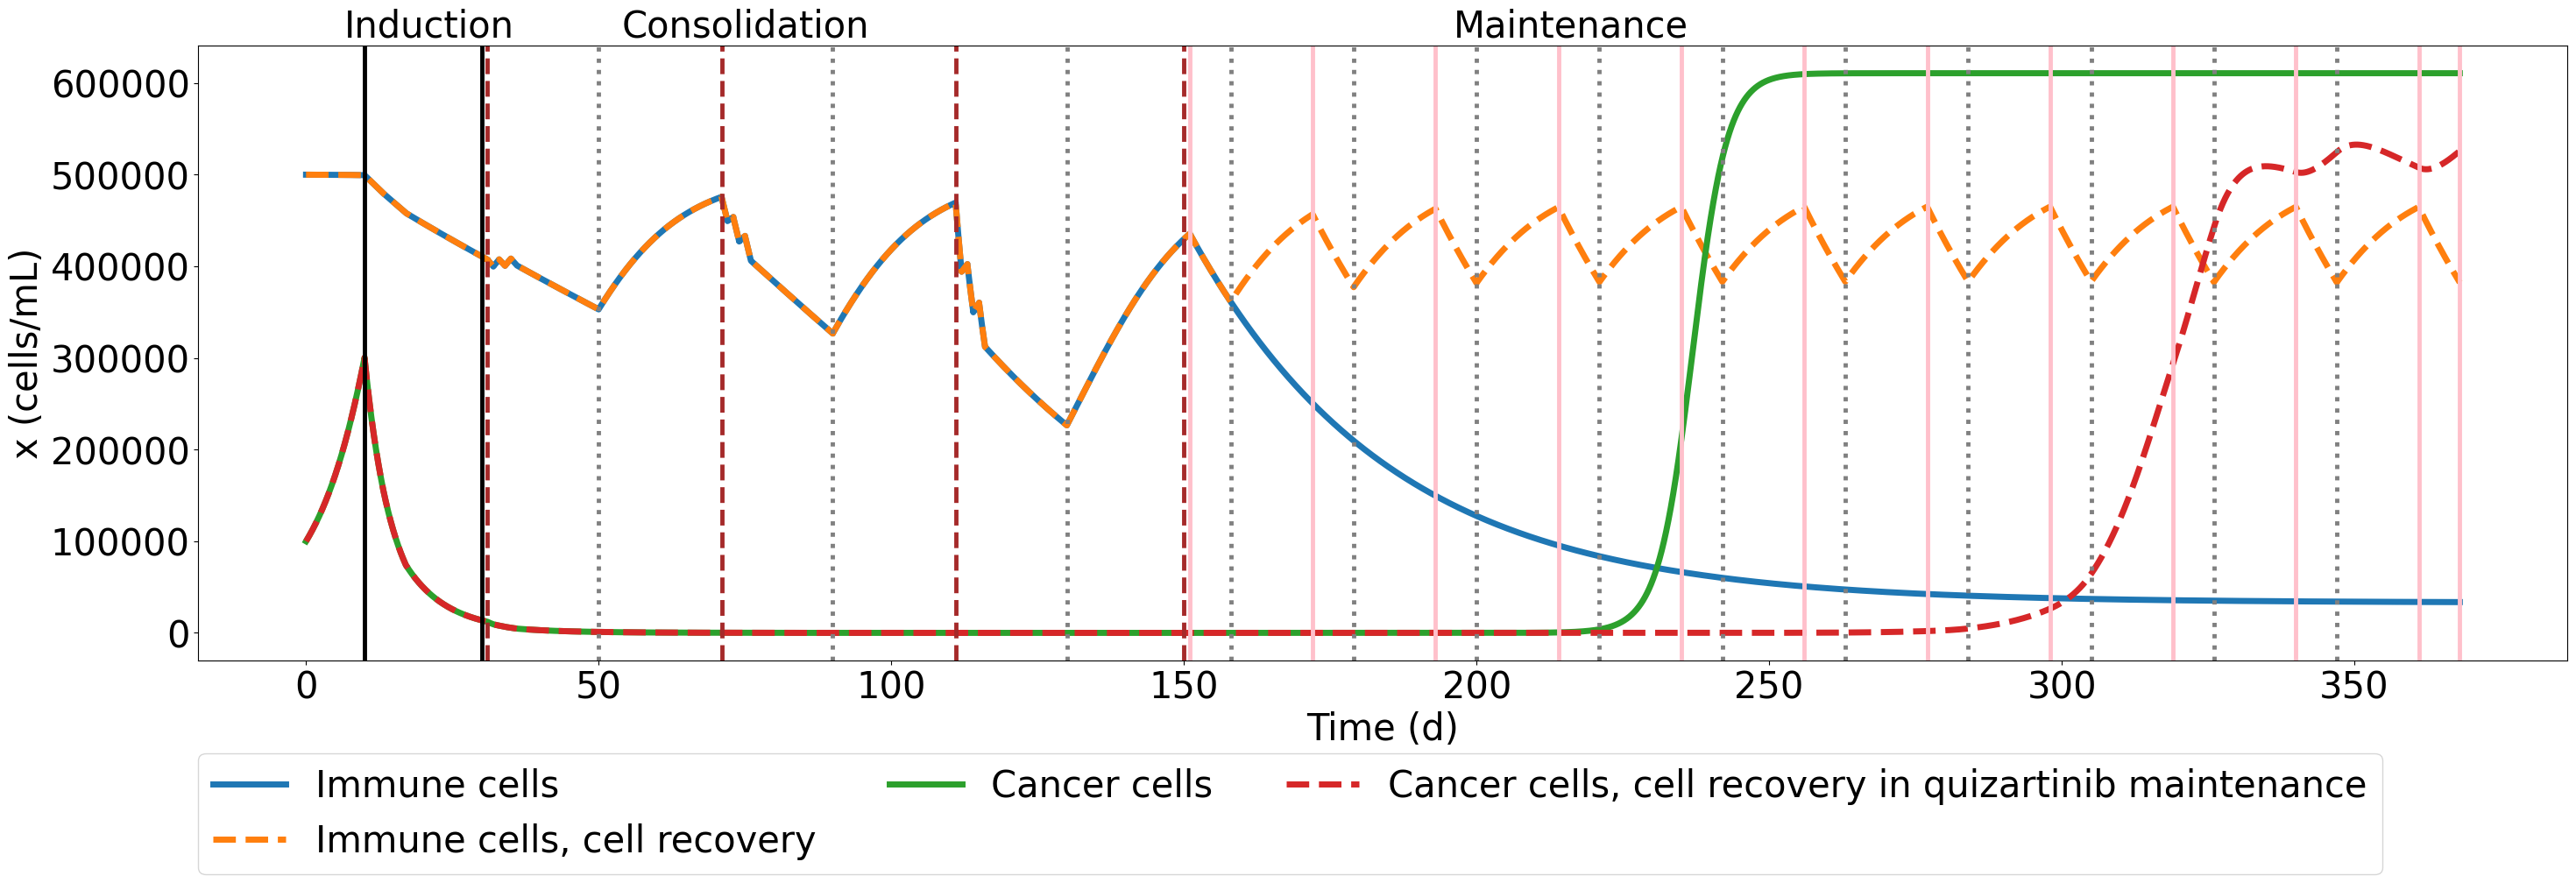

In [47]:
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 217, mu_quizartinib, d_max_Q, 0, 'Q', False),
]

treatment_phases_cellRecovery = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_quizartinib, d, 42, 'Q', True),
    ('Quizartinib', 7, mu_quizartinib, d_max_Q, 0, 'Q', False),
]
t_q, _, popDensity_quizartinibChange, immune_q, _, _, _, _, _, _ = simulate_treatment(treatment_phases_cellRecovery, daysBeforeTreatment, parameters)
t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(31, 11))
plt.plot(t, immune, label='Immune cells', linewidth=5.0)
plt.plot(t_q, immune_q, label='Immune cells, cell recovery', linewidth=5.0, linestyle='dashed')
plt.plot(t, density, label='Cancer cells', linewidth=5.0)
plt.plot(t_q, popDensity_quizartinibChange, label='Cancer cells, cell recovery in quizartinib maintenance', linewidth=5.0, linestyle='dashed')

# Annotate treatment phases 
phase_labels = ['Induction', 'Consolidation', 'Maintenance']
phase_starts = [daysBeforeTreatment - 4.5,
                daysBeforeTreatment + 43,
                daysBeforeTreatment + 185]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(immune_q), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 20, color='black', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 21, color = 'brown',  linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 40, color = 'gray',  linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 61, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 80, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 101, color = 'brown', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 120, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 140, color = 'brown',  linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 148, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 162, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 169, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 183, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 190, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 204, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 211, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 225, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 232, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 246, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 253, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 267, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 274, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 288, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 295, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 309, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 316, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 330, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 337, color = 'gray', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 351, color = 'pink', linewidth=3.5)
plt.axvline(daysBeforeTreatment + 358, color = 'pink', linewidth=3.5)

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('QuzRecovery_7_low.pdf', format='pdf', bbox_inches='tight')
plt.show()

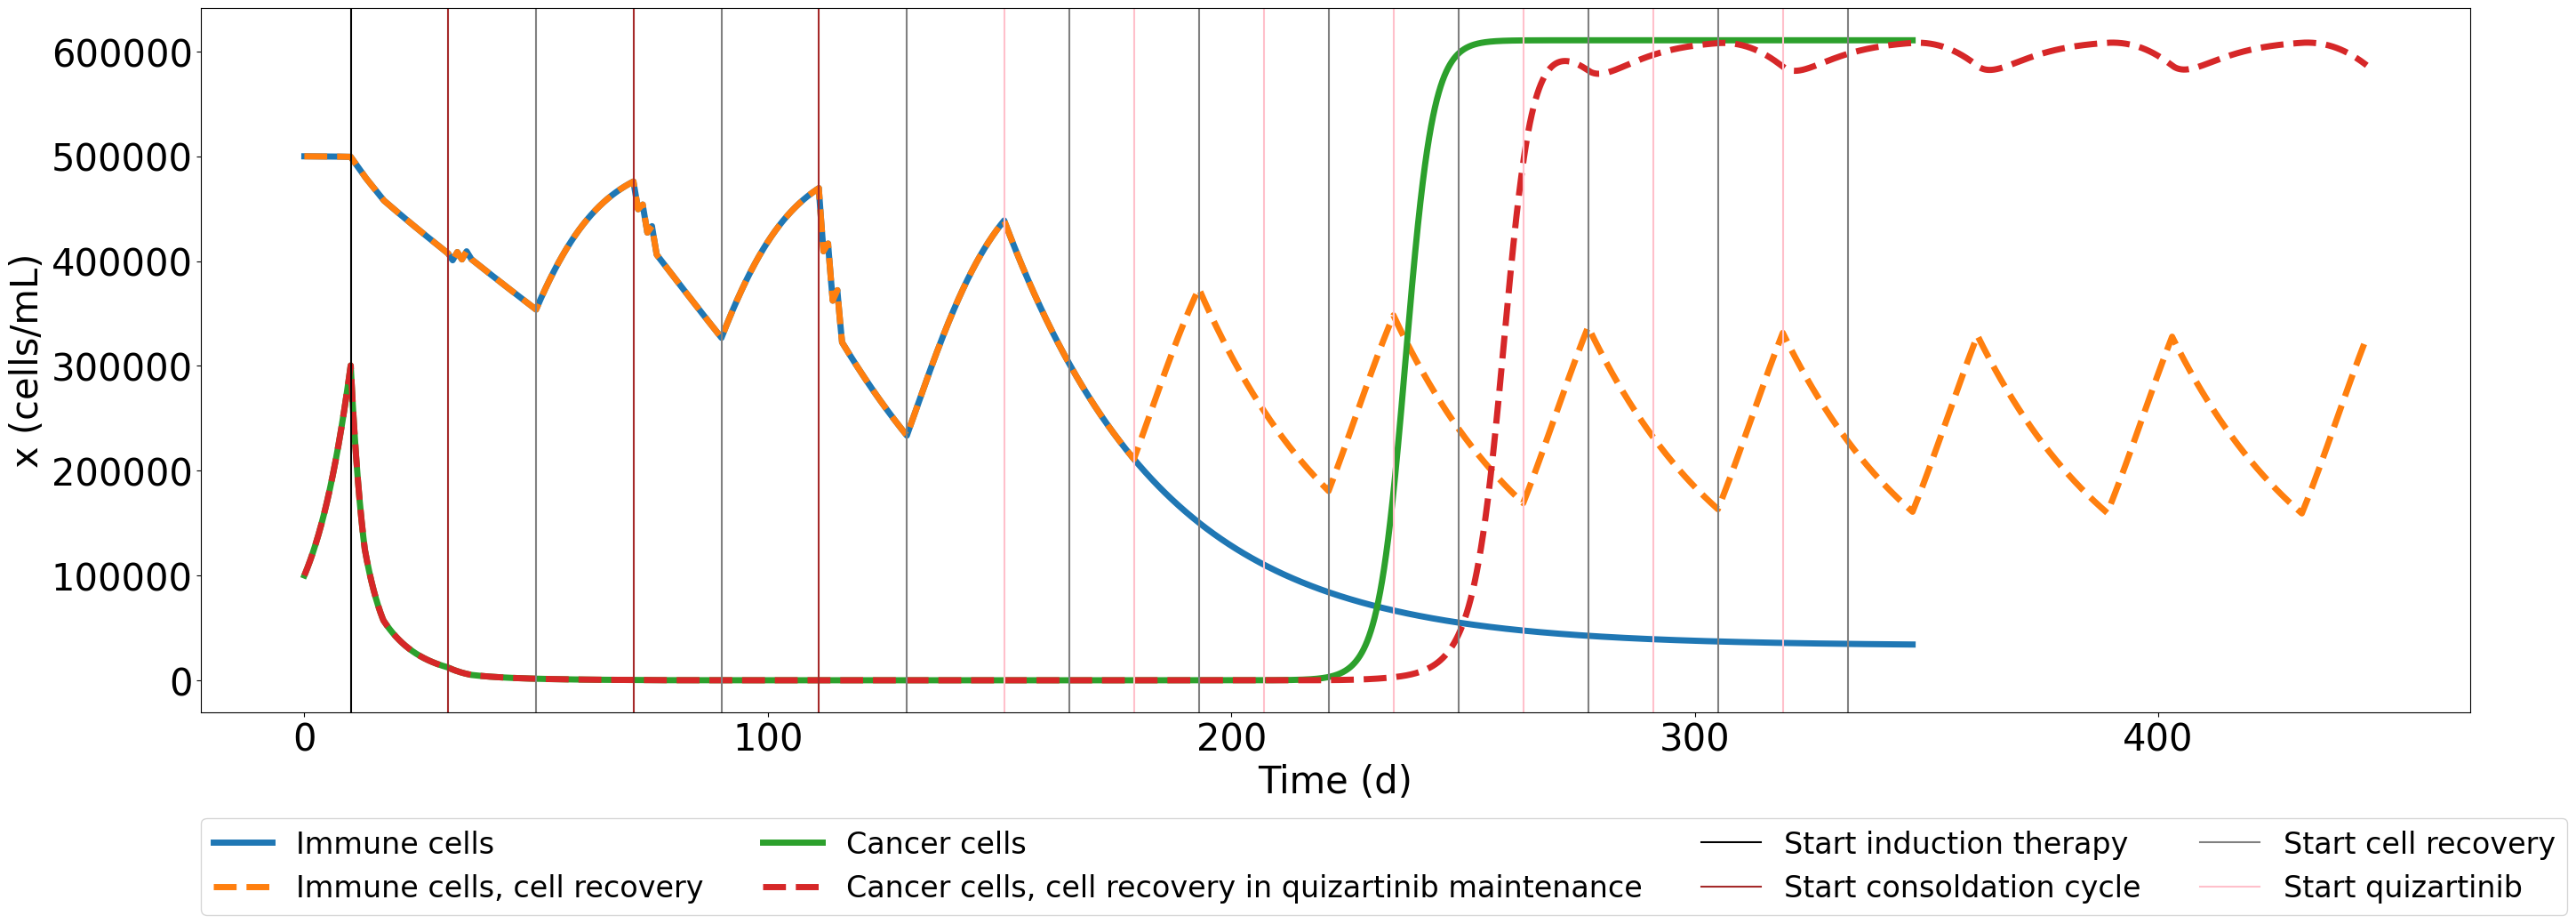

In [48]:
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CAQ, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 196, mu_Q, d_max_Q, 0, 'Q', False),
]

treatment_phases_cellRecovery = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CAQ, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 28, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 28, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 28, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 28, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 28, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 28, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
    ('Quizartinib', 28, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 14, mu_Q, d, 42, 'Q', True),
]
t_q, _, popDensity_quizartinibChange, immune_q, _, _, _, _, _, _ = simulate_treatment(treatment_phases_cellRecovery, daysBeforeTreatment, parameters)
t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)


# Plot results
plt.figure(figsize=(31, 11))
plt.plot(t, immune, label='Immune cells', linewidth=5.0)
plt.plot(t_q, immune_q, label='Immune cells, cell recovery', linewidth=5.0, linestyle='dashed')
plt.plot(t, density, label='Cancer cells', linewidth=5.0)
plt.plot(t_q, popDensity_quizartinibChange, label='Cancer cells, cell recovery in quizartinib maintenance', linewidth=5.0, linestyle='dashed')

plt.axvline(daysBeforeTreatment, color='black', label = 'Start induction therapy')
plt.axvline(daysBeforeTreatment + 21, color = 'brown', label = 'Start consoldation cycle')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', label = 'Start cell recovery')
plt.axvline(daysBeforeTreatment + 61, color = 'brown')
plt.axvline(daysBeforeTreatment + 80, color = 'gray')
plt.axvline(daysBeforeTreatment + 101, color = 'brown')
plt.axvline(daysBeforeTreatment + 120, color = 'gray')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', label = 'Start quizartinib')
plt.axvline(daysBeforeTreatment + 155, color = 'gray')
plt.axvline(daysBeforeTreatment + 169, color = 'pink')
plt.axvline(daysBeforeTreatment + 183, color = 'gray')
plt.axvline(daysBeforeTreatment + 197, color = 'pink')
plt.axvline(daysBeforeTreatment + 211, color = 'gray')
plt.axvline(daysBeforeTreatment + 225, color = 'pink')
plt.axvline(daysBeforeTreatment + 239, color = 'gray')
plt.axvline(daysBeforeTreatment + 253, color = 'pink')
plt.axvline(daysBeforeTreatment + 267, color = 'gray')
plt.axvline(daysBeforeTreatment + 281, color = 'pink')
plt.axvline(daysBeforeTreatment + 295, color = 'gray')
plt.axvline(daysBeforeTreatment + 309, color = 'pink')
plt.axvline(daysBeforeTreatment + 323, color = 'gray')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 24})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.savefig('QuzRecovery_28.pdf', format='pdf', bbox_inches='tight')
plt.show()

Now it is even better.

### Testing cytarabine with the toxicity of venetoclax

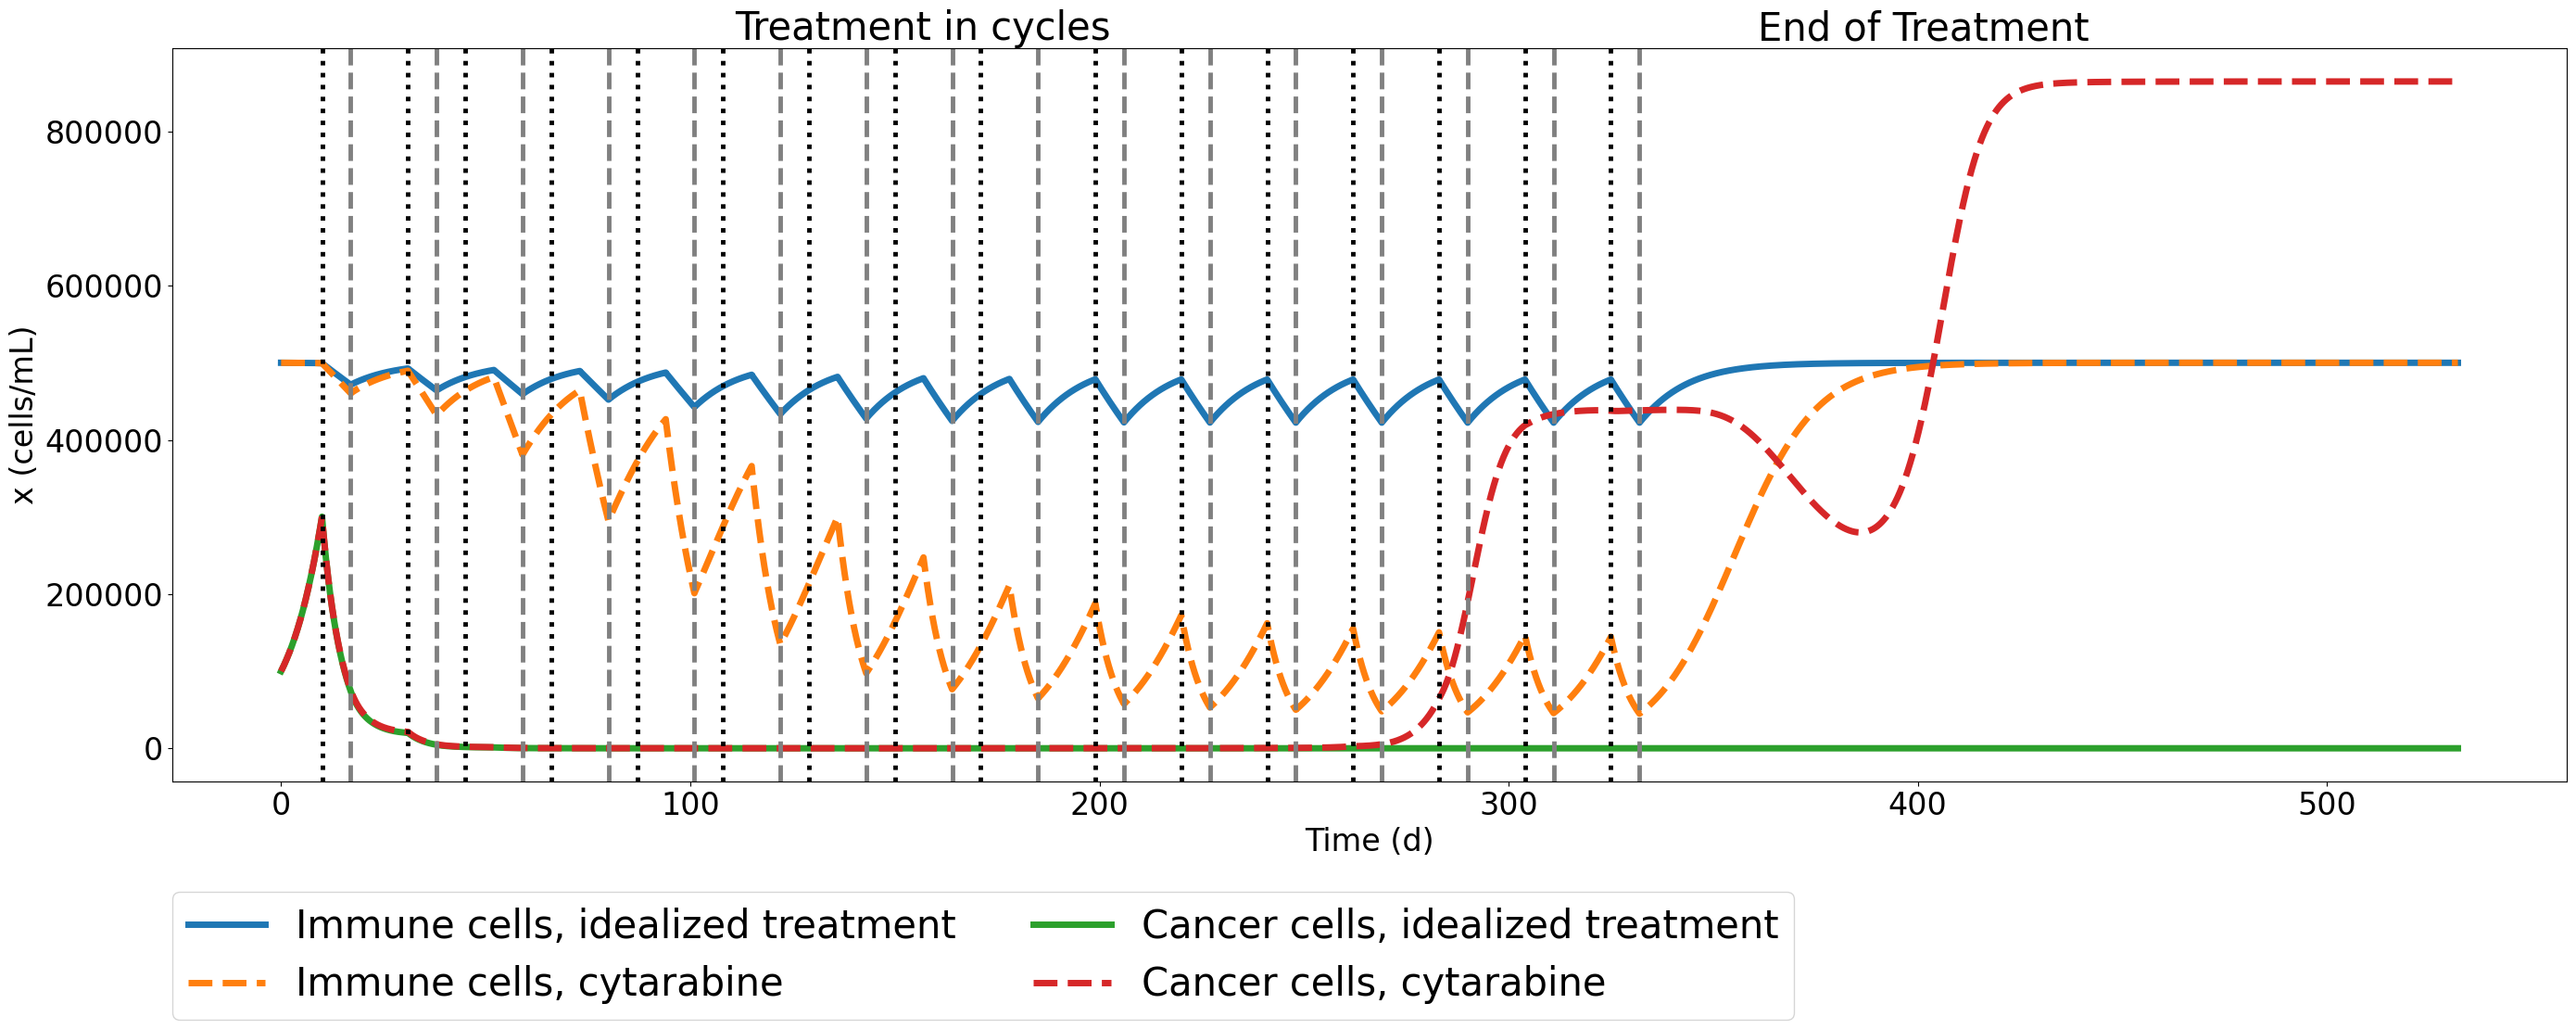

In [49]:
treatment_phases_opt = [
    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),
    
    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),
    
    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_V, 0, 'C', False),
    ('Cell recovery', 200, mu_C, d, 10, 'C', True),
]

treatment_phases = [
    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),
    
    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),
    
    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 14, mu_C, d, 10, 'C', True),

    ('Drug', 7, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 200, mu_C, d, 10, 'C', True),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases_opt, daysBeforeTreatment, parameters)
t_real, _, density_real, immune_real, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(28.5, 12))
plt.plot(t, immune, label='Immune cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, immune_real, label='Immune cells, cytarabine', linewidth=5.0, linestyle='dashed')
plt.plot(t, density, label='Cancer cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, density_real, label='Cancer cells, cytarabine', linewidth=5.0, linestyle='dashed')

# Annotate treatment phases 
phase_labels = ['Treatment in cycles', 'End of Treatment']
phase_starts = [daysBeforeTreatment + 100,
                daysBeforeTreatment + 350]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(density_real), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 7, color = 'gray',  linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 21, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 28, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 35, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 49, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 56, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 70, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 77, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 91, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 98, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 112, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 119, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 133, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 140, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 154, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 161, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 175, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 189, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 196, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 210, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 217, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 231, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 238, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 252, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 259, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 273, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 280, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 294, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 301, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 315, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 322, color = 'gray', linewidth=3.5, linestyle='dashed')


plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('CytarabineVenetoclax_recovery.pdf', format='pdf', bbox_inches='tight')
plt.show()

Eliminates all the cells when there is a cell recovery.

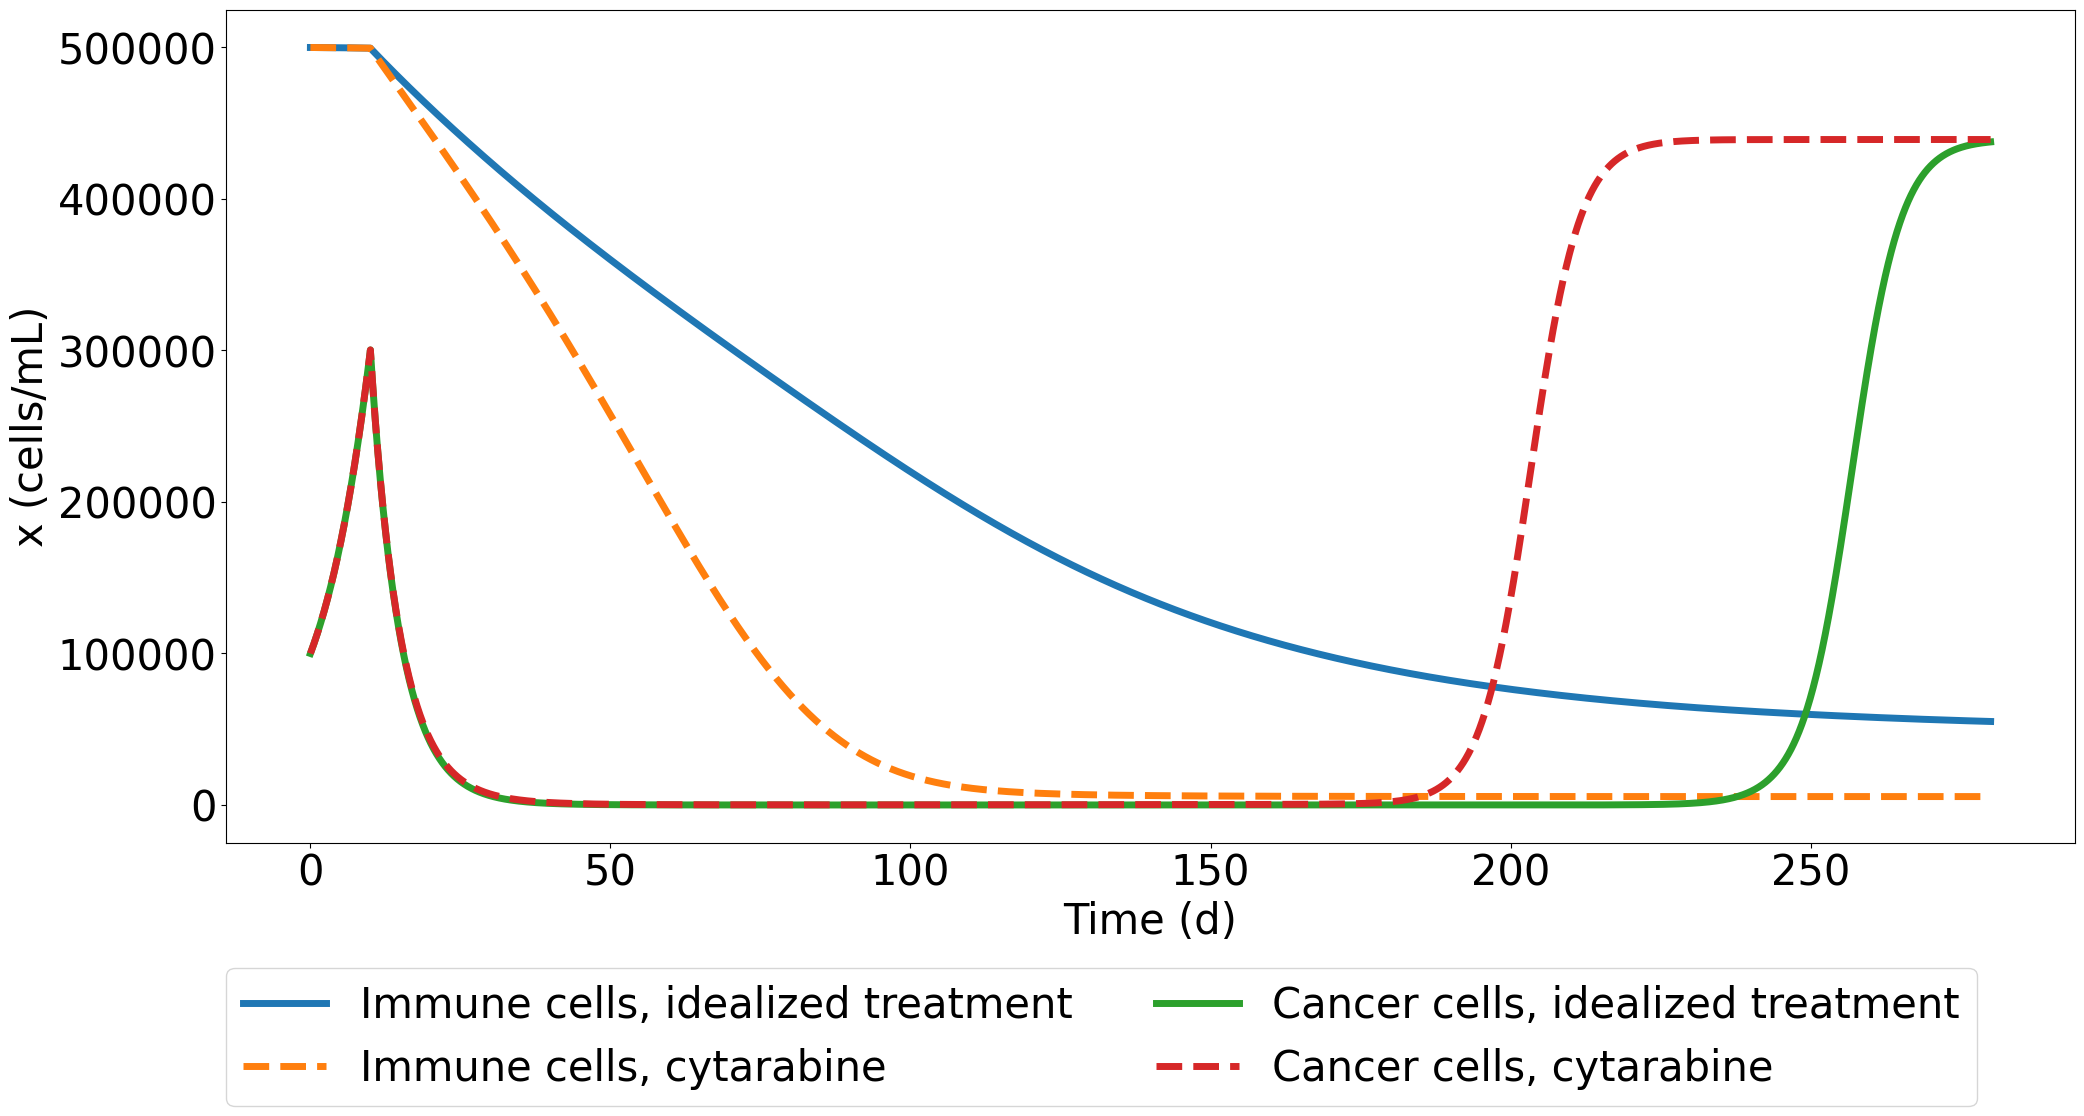

In [50]:
treatment_phases_opt = [
    ('Drug', 270, mu_C, d_max_V, 0, 'C', False),
]
treatment_phases = [
    ('Drug', 270, mu_C, d_max_C, 0, 'C', False),
]


t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases_opt, daysBeforeTreatment, parameters)
t_real, _, density_real, immune_real, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(22, 12))
plt.plot(t, immune, label='Immune cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, immune_real, label='Immune cells, cytarabine', linewidth=5.0, linestyle='dashed')
plt.plot(t, density, label='Cancer cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, density_real, label='Cancer cells, cytarabine', linewidth=5.0, linestyle='dashed')


plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('CytarabineVenetoclax_noRecovery.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Azactidine with the toxicity of venetoclax

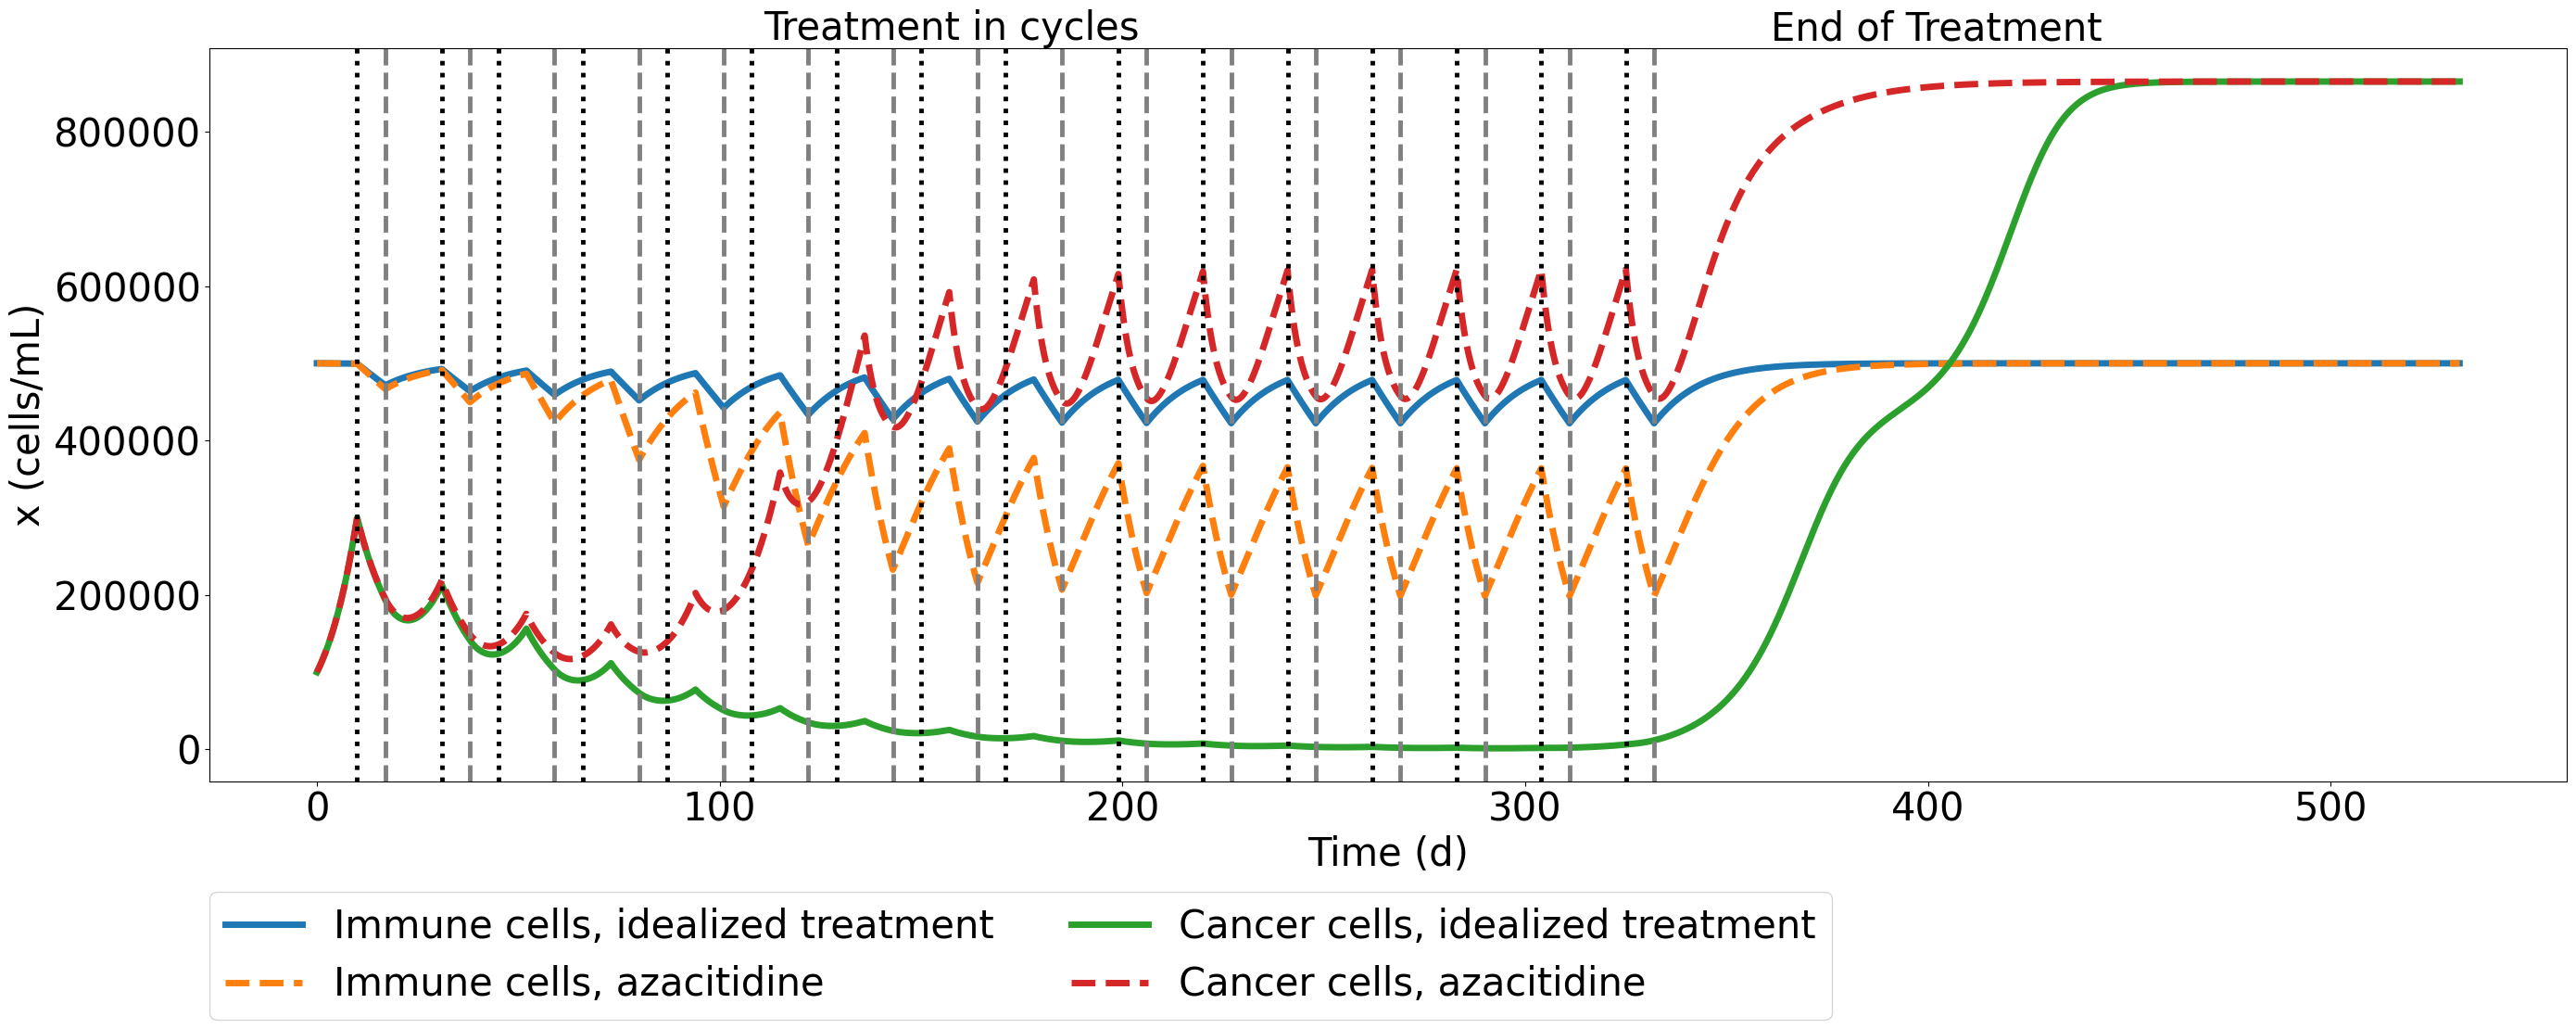

In [51]:
treatment_phases_opt = [
    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_V, 0, 'A', False),
    ('Cell recovery', 200, mu_A, d, 10, 'A', True),
]

treatment_phases = [
    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 14, mu_A, d, 10, 'A', True),

    ('Drug', 7, mu_A, d_max_A, 0, 'A', False),
    ('Cell recovery', 200, mu_A, d, 10, 'A', True),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases_opt, daysBeforeTreatment, parameters)
t_real, _, density_real, immune_real, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(28.5, 12))
plt.plot(t, immune, label='Immune cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, immune_real, label='Immune cells, azacitidine', linewidth=5.0, linestyle='dashed')
plt.plot(t, density, label='Cancer cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, density_real, label='Cancer cells, azacitidine', linewidth=5.0, linestyle='dashed')

# Annotate treatment phases 
phase_labels = ['Treatment in cycles', 'End of Treatment']
phase_starts = [daysBeforeTreatment + 100,
                daysBeforeTreatment + 350]

# Set y-position slightly above max y-value
y_pos = max(max(density), max(density_real), max(immune)) * 1.05

# Add labels just after each phase starts
for label, xpos in zip(phase_labels, phase_starts):
    plt.text(xpos + 1, y_pos, label, ha='left', va='bottom', fontsize=30)

plt.axvline(daysBeforeTreatment, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 7, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 21, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 28, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 35, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 49, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 56, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 70, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 77, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 91, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 98, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 112, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 119, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 133, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 140, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 154, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 161, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 175, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 189, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 196, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 210, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 217, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 231, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 238, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 252, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 259, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 273, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 280, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 294, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 301, color = 'gray', linewidth=3.5, linestyle='dashed')
plt.axvline(daysBeforeTreatment + 315, color = 'black', linewidth=3.5, linestyle='dotted')
plt.axvline(daysBeforeTreatment + 322, color = 'gray', linewidth=3.5, linestyle='dashed')


plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('AzacitidineVenetoclax_recovery.pdf', format='pdf', bbox_inches='tight')
plt.show()

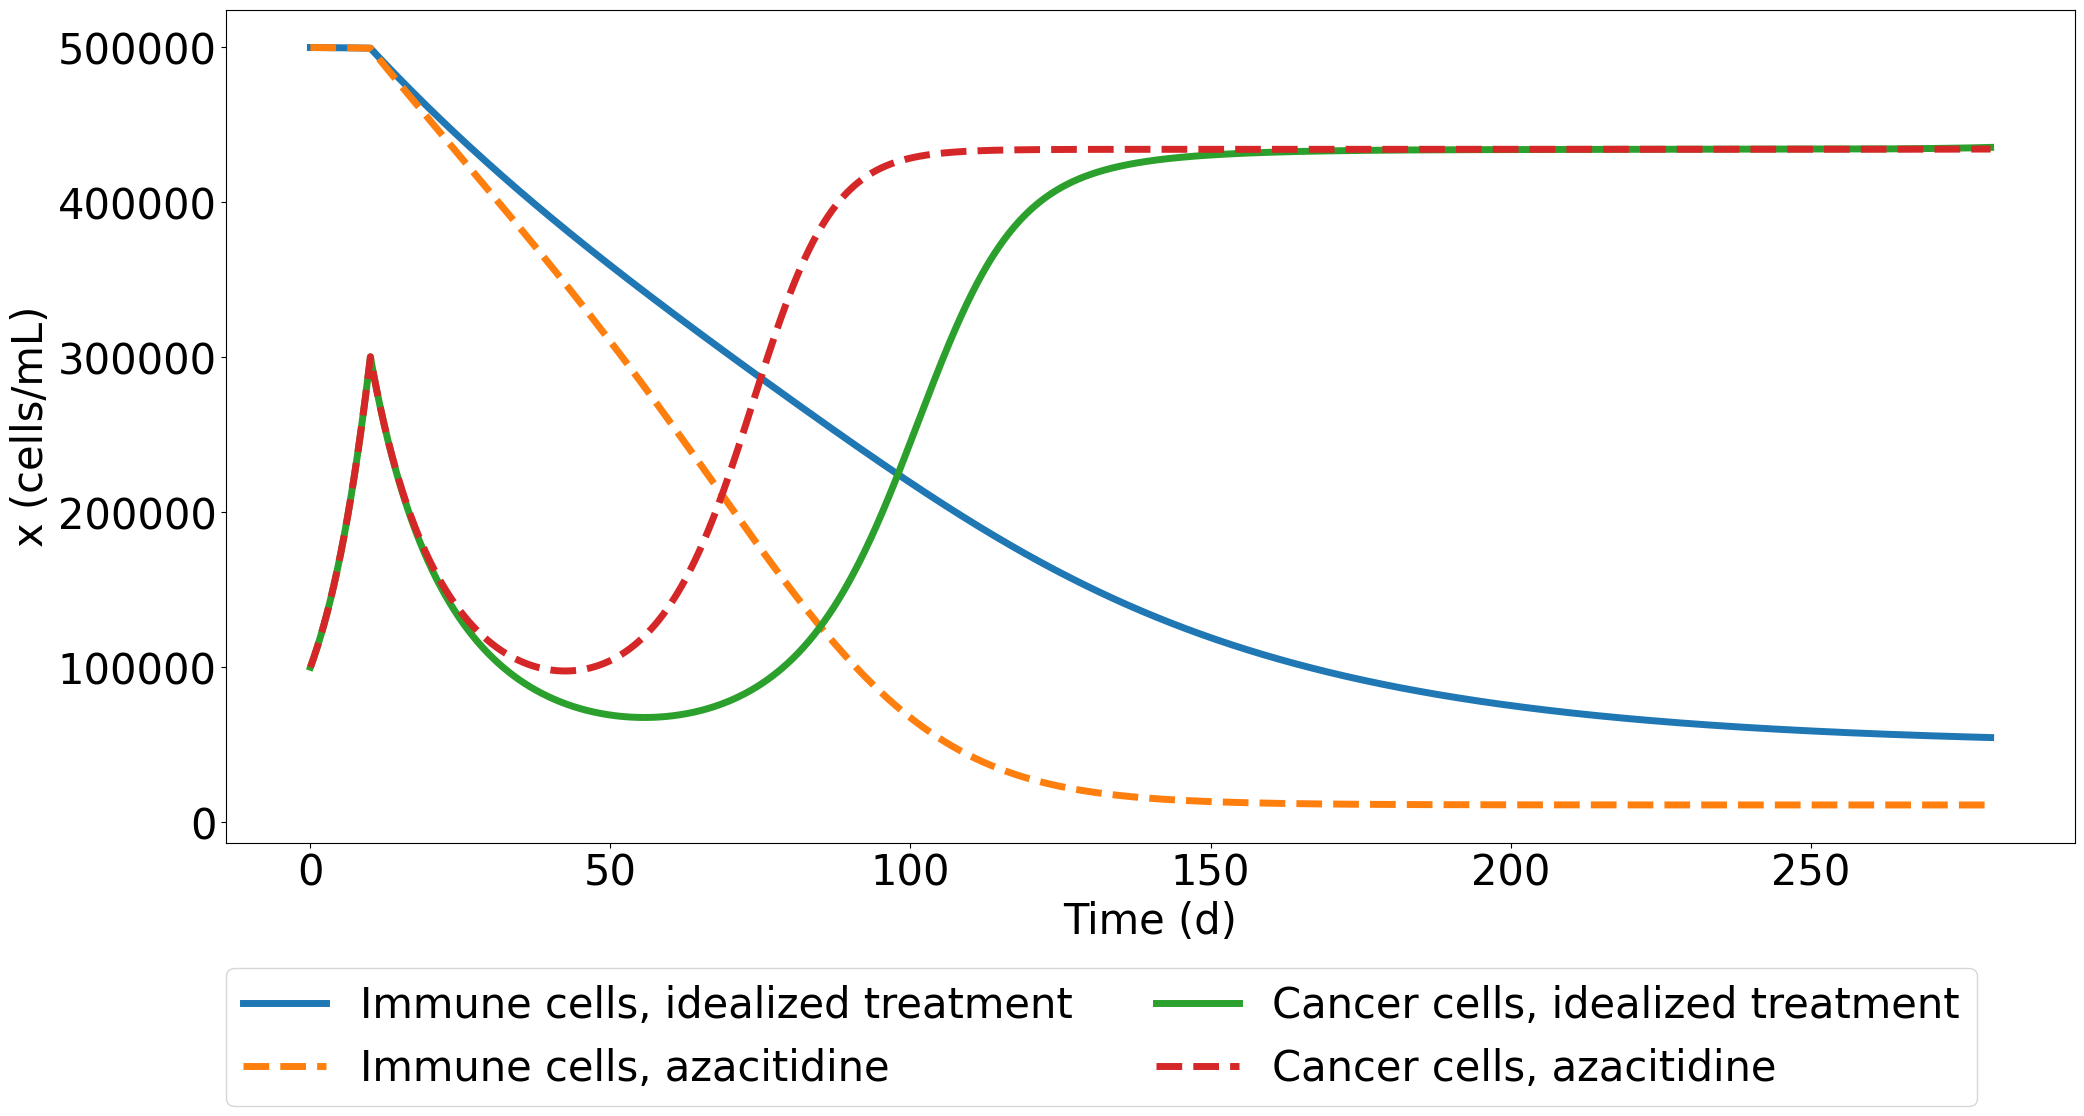

In [52]:
treatment_phases_opt = [
    ('Drug', 270, mu_A, d_max_V, 0, 'A', False),
]
treatment_phases = [
    ('Drug', 270, mu_A, d_max_A, 0, 'A', False),
]


t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases_opt, daysBeforeTreatment, parameters)
t_real, _, density_real, immune_real, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

plt.figure(figsize=(22, 12))
plt.plot(t, immune, label='Immune cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, immune_real, label='Immune cells, azacitidine', linewidth=5.0, linestyle='dashed')
plt.plot(t, density, label='Cancer cells, idealized treatment', linewidth=5.0)
plt.plot(t_real, density_real, label='Cancer cells, azacitidine', linewidth=5.0, linestyle='dashed')


plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('AzacitidineVenetoclax_noRecovery.pdf', format='pdf', bbox_inches='tight')
plt.show()

If the drug is given constantly, with no cell recovery, it will eventually grow back up when a sufficient amount of the immune cells are eliminated. Shows that a high efficacy and low toxicity works well. However, even when the toxicity is low it is important to let the immune system recover. In the model I have now, the cancer cell population will grow again if a sufficient amount of the immune cells is killed. 

### QuANTUM-First trial, quizartinib resistance like cytarabine

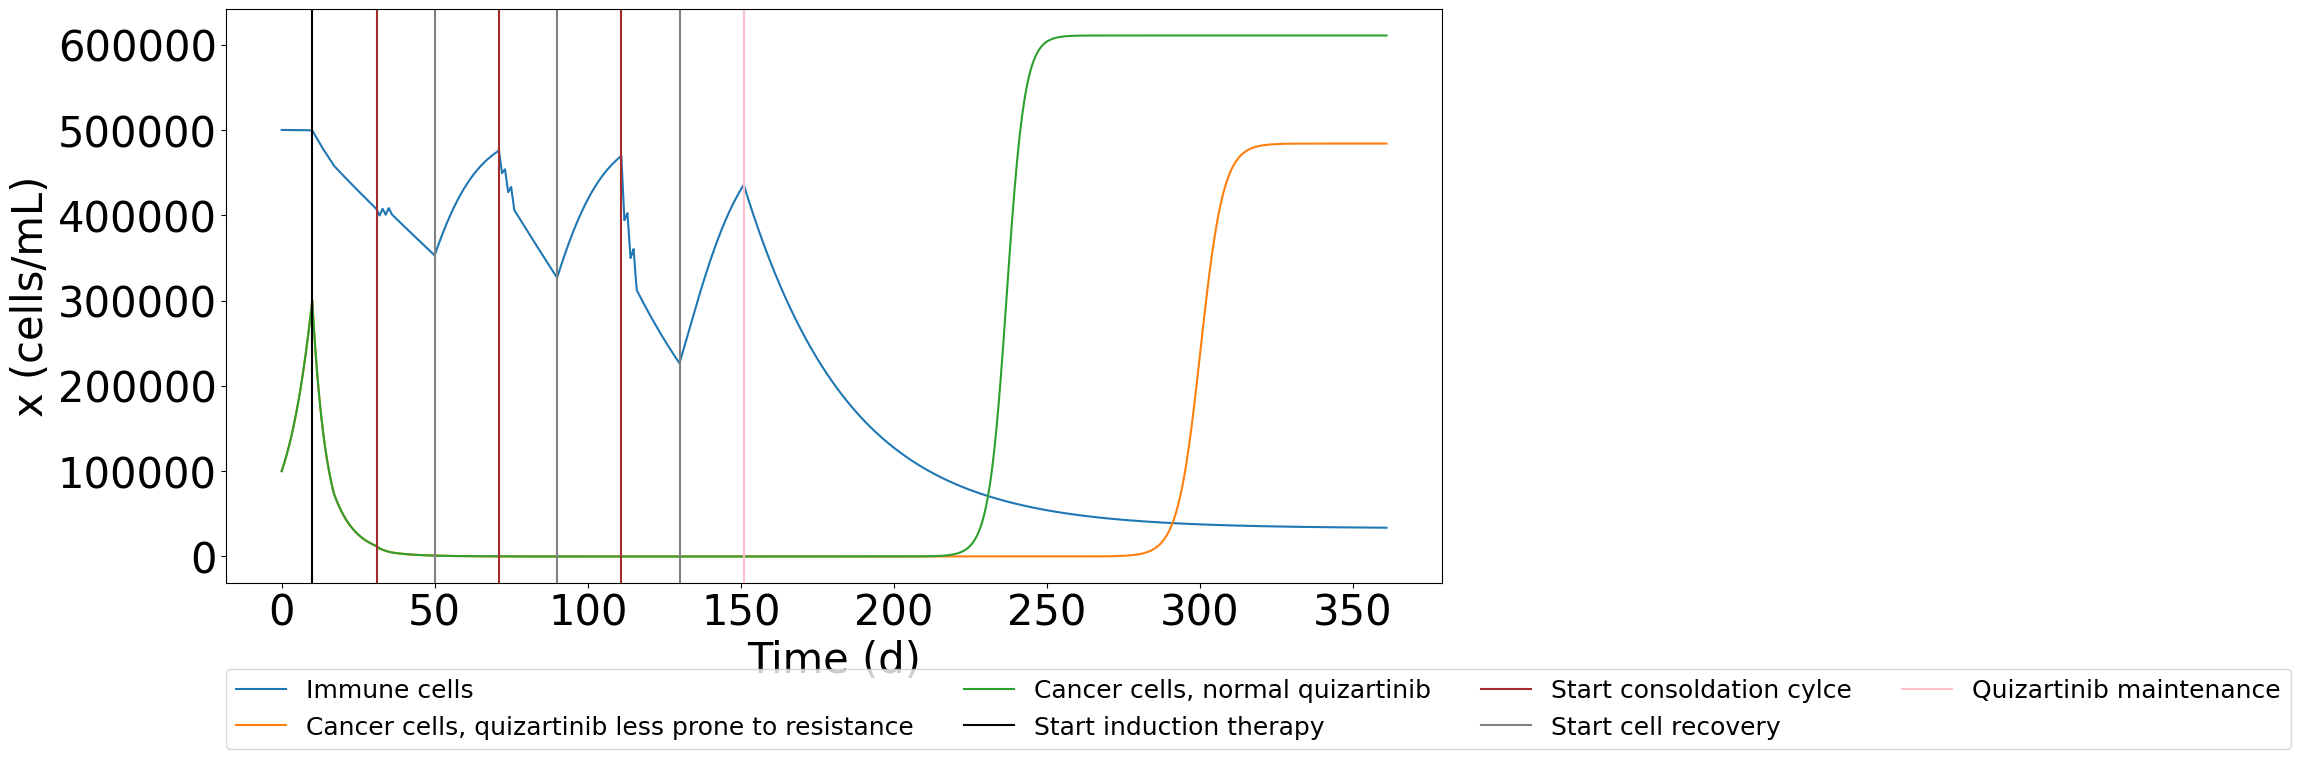

In [53]:
parameters_quizartinibChange = [K, x0, r, n, y0, nImmune_upper, g, c, m, d, s, mu_Q, mu_C, mu_A, mu_V, a, b_C, b_C, b_A, b_V, p_C, p_C, p_A, p_V, tau, h]

treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 210, mu_quizartinib, d_max_Q, 0, 'Q', False),
]

_, _, popDensity_quizartinibChange, _, _, _, _, _, _, _ = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters_quizartinibChange)
t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(20, 8))
plt.plot(t, immune, label='Immune cells')
plt.plot(t, popDensity_quizartinibChange, label = 'Cancer cells, quizartinib less prone to resistance')
plt.plot(t, density, label='Cancer cells, normal quizartinib')

plt.axvline(daysBeforeTreatment, color='black', label = 'Start induction therapy')
plt.axvline(daysBeforeTreatment + 21, color = 'brown', label = 'Start consoldation cylce')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', label = 'Start cell recovery')
plt.axvline(daysBeforeTreatment + 61, color = 'brown')
plt.axvline(daysBeforeTreatment + 80, color = 'gray')
plt.axvline(daysBeforeTreatment + 101, color = 'brown')
plt.axvline(daysBeforeTreatment + 120, color = 'gray')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', label = 'Quizartinib maintenance')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 18})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.show()

The change in b and p makes it grow less and become resistant at a later time.

### Quizartinib 1/5 of the toxicity

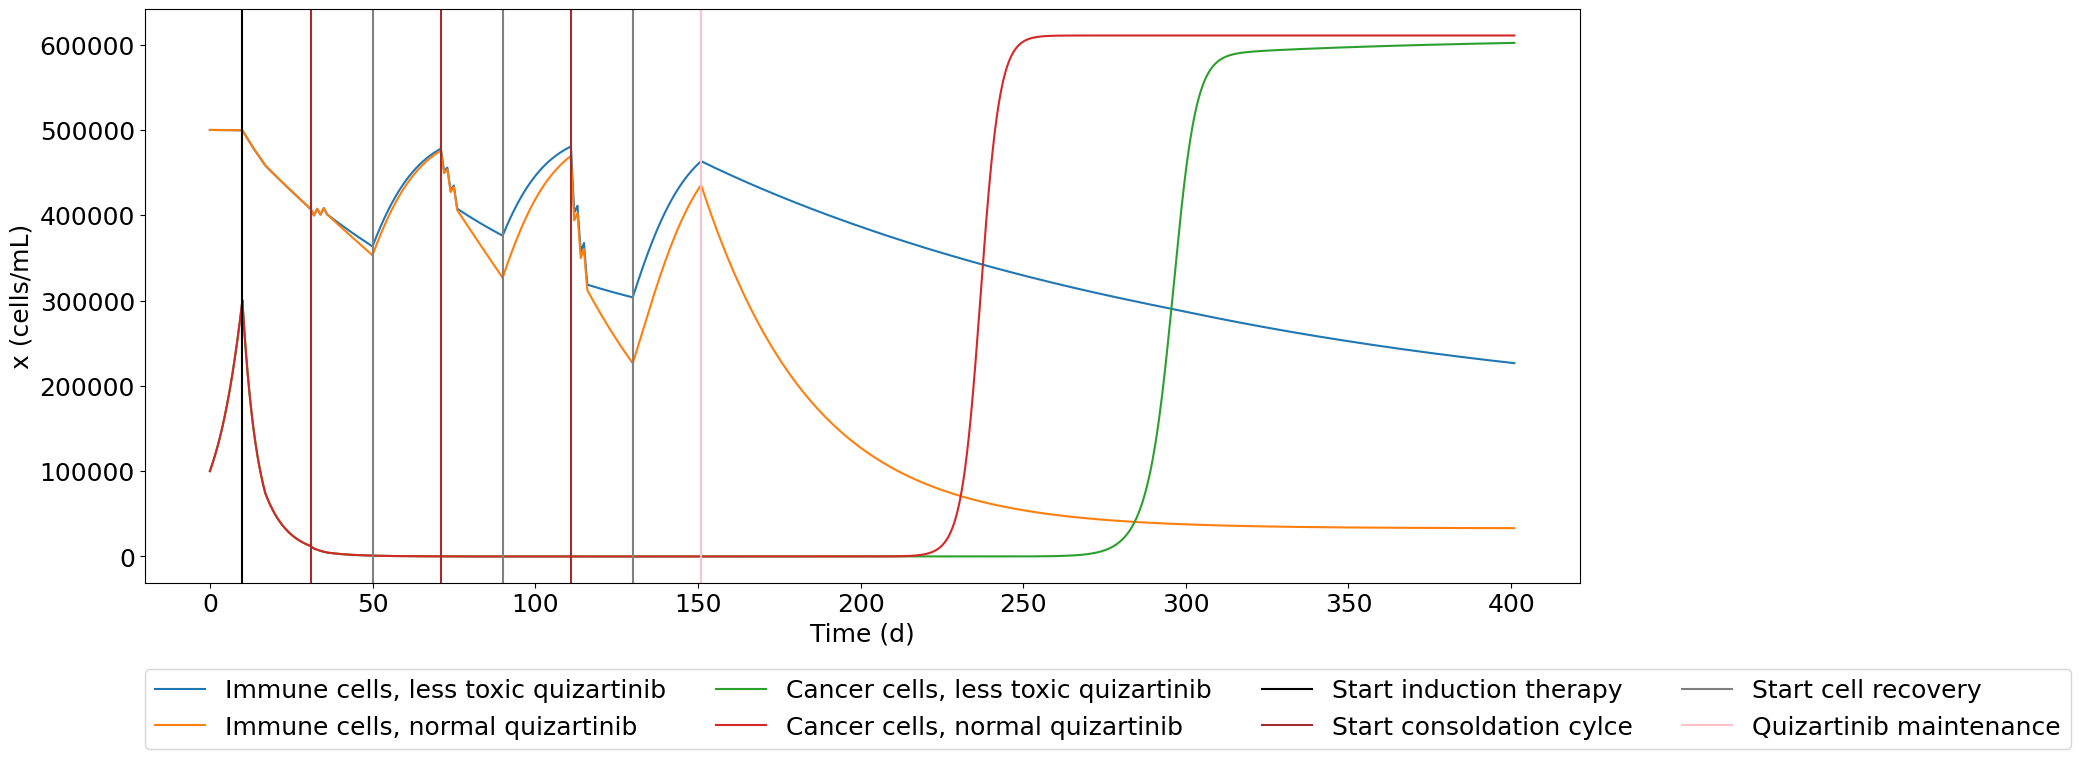

In [54]:
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 250, mu_quizartinib, d_max_Q, 0, 'Q', False),
]

treatment_phases_lessToxic = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_combination, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, 1/5*d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, 1/5*d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_cq, d_max_CQ, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_cytarabine, d, 14, 'C', True),
    ('Cytarabine', 1, mu_cytarabine, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_quizartinib, 1/5*d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_quizartinib, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 250, mu_quizartinib, 1/5*d_max_Q, 0, 'Q', False),
]

_, _, popDensity_quizartinibChange, immune_quizartinibChange, _, _, _, _, _, _ = simulate_treatment(treatment_phases_lessToxic, daysBeforeTreatment, parameters)
t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(20, 8))
plt.plot(t, immune_quizartinibChange, label='Immune cells, less toxic quizartinib')
plt.plot(t, immune, label='Immune cells, normal quizartinib')
plt.plot(t, popDensity_quizartinibChange, label = 'Cancer cells, less toxic quizartinib')
plt.plot(t, density, label='Cancer cells, normal quizartinib')

plt.axvline(daysBeforeTreatment, color='black', label = 'Start induction therapy')
plt.axvline(daysBeforeTreatment + 21, color = 'brown', label = 'Start consoldation cylce')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', label = 'Start cell recovery')
plt.axvline(daysBeforeTreatment + 61, color = 'brown')
plt.axvline(daysBeforeTreatment + 80, color = 'gray')
plt.axvline(daysBeforeTreatment + 101, color = 'brown')
plt.axvline(daysBeforeTreatment + 120, color = 'gray')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', label = 'Quizartinib maintenance')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 18})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.show()

### No treatment

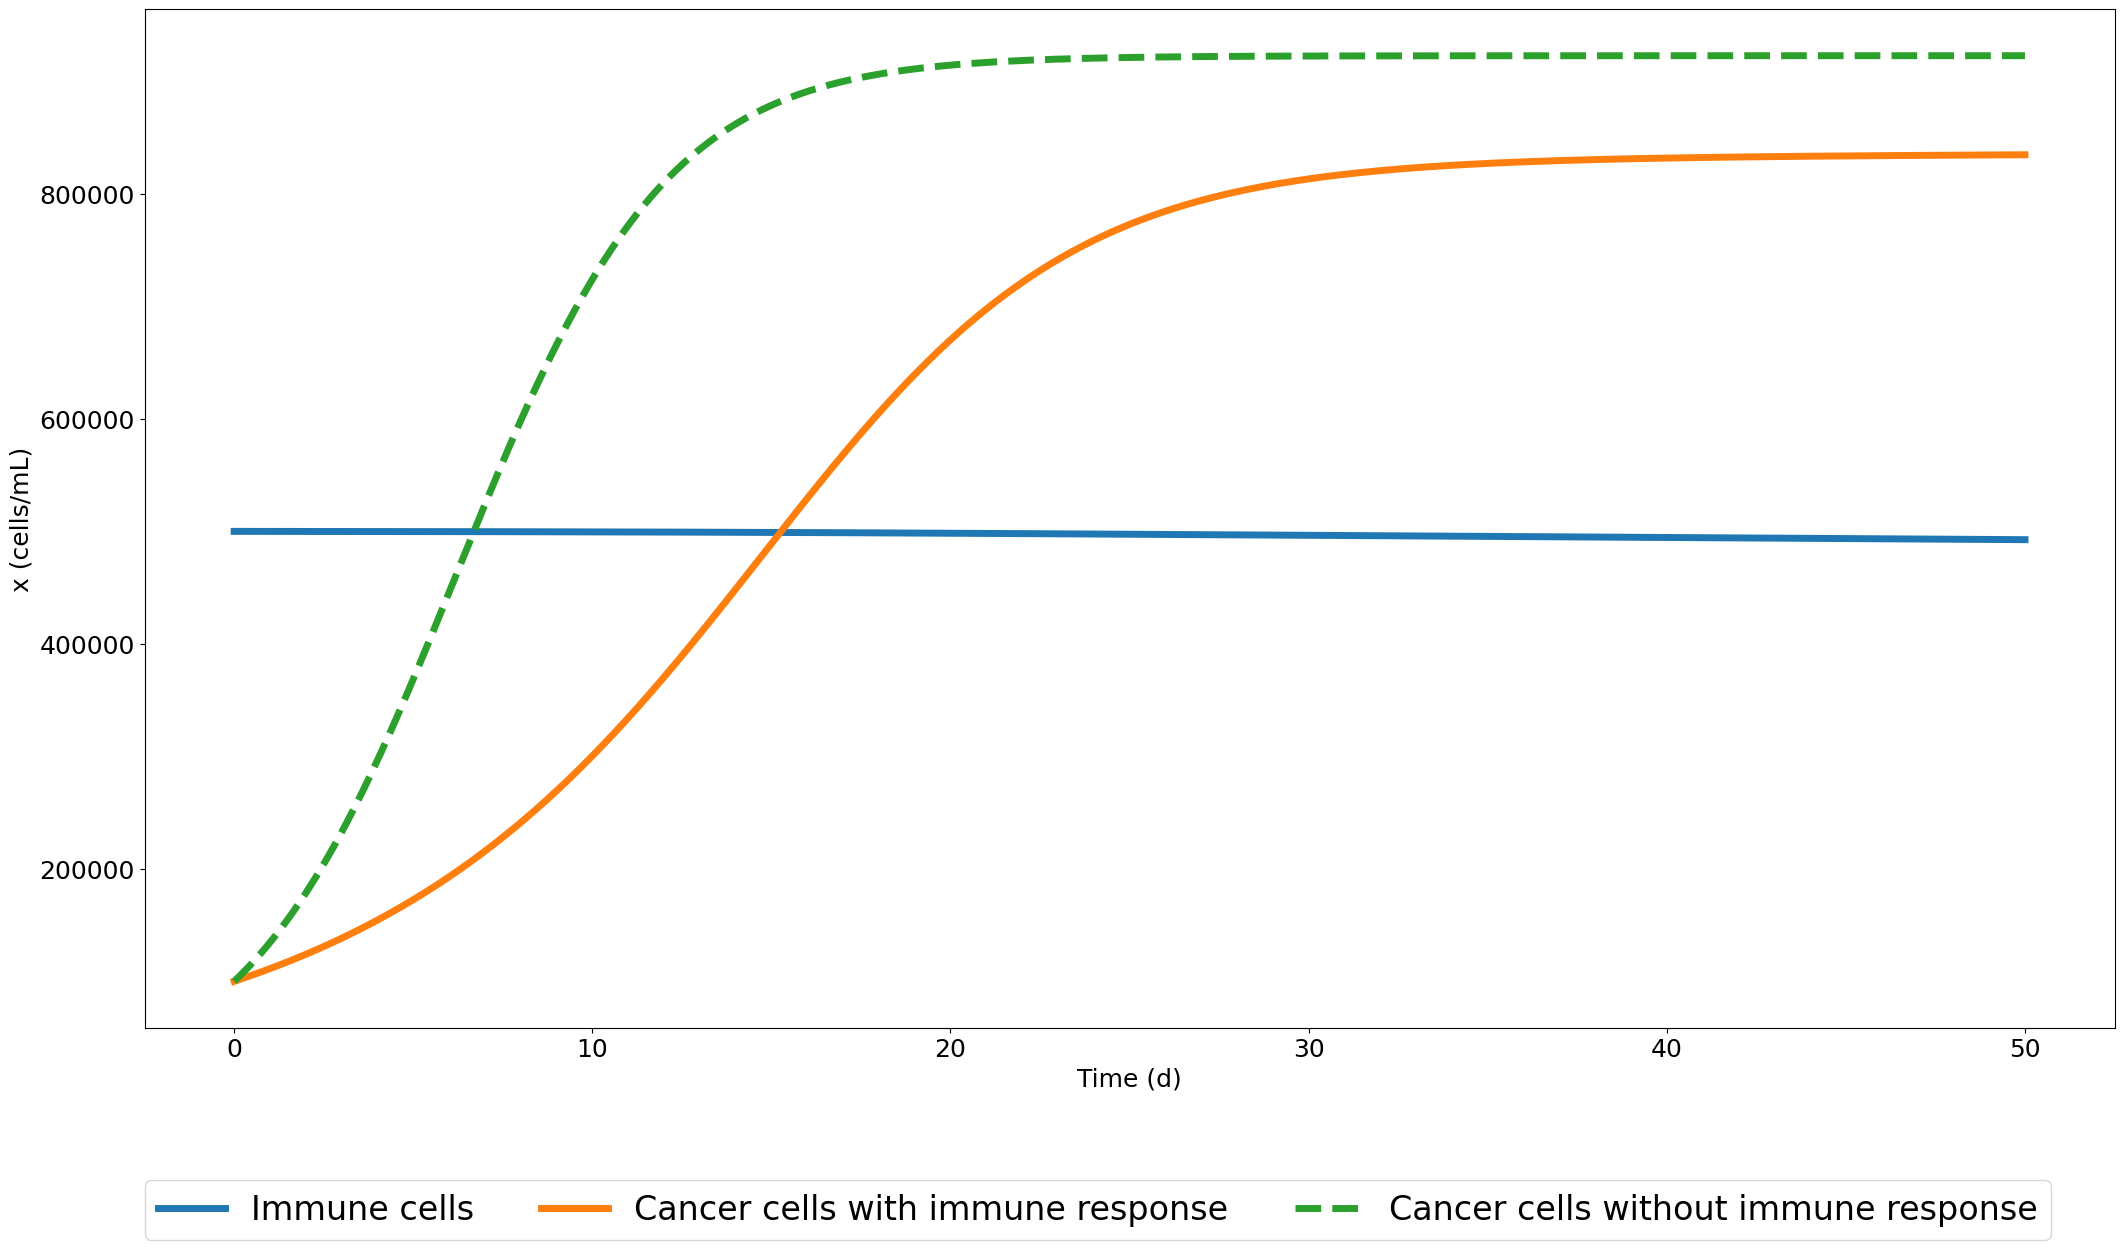

In [55]:
t_show_no_treatment = np.arange(0, 50 + dt, dt)

popDensity_immune_x_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_show_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,0]
popDensity_immune_y_no_treatment = odeint(growthRate_immune_toxicity, [x0,y0], t_show_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,1]

popDensity_x_no_treatment = odeint(growthRate, x0, t_show_no_treatment, args=(K, mu_no_drug, r))

plt.figure(figsize=(23, 13))
plt.plot(t_show_no_treatment, popDensity_immune_y_no_treatment, label = 'Immune cells', linewidth=5.0)
plt.plot(t_show_no_treatment, popDensity_immune_x_no_treatment, label='Cancer cells with immune response', linewidth=5.0)
plt.plot(t_show_no_treatment, popDensity_x_no_treatment, label='Cancer cells without immune response', linewidth=5.0, linestyle='dashed')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 24})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0, fontsize=24)
plt.tight_layout()
plt.savefig('NoTreatment_immuneResponse_normal.pdf', format='pdf', bbox_inches='tight')
plt.show()

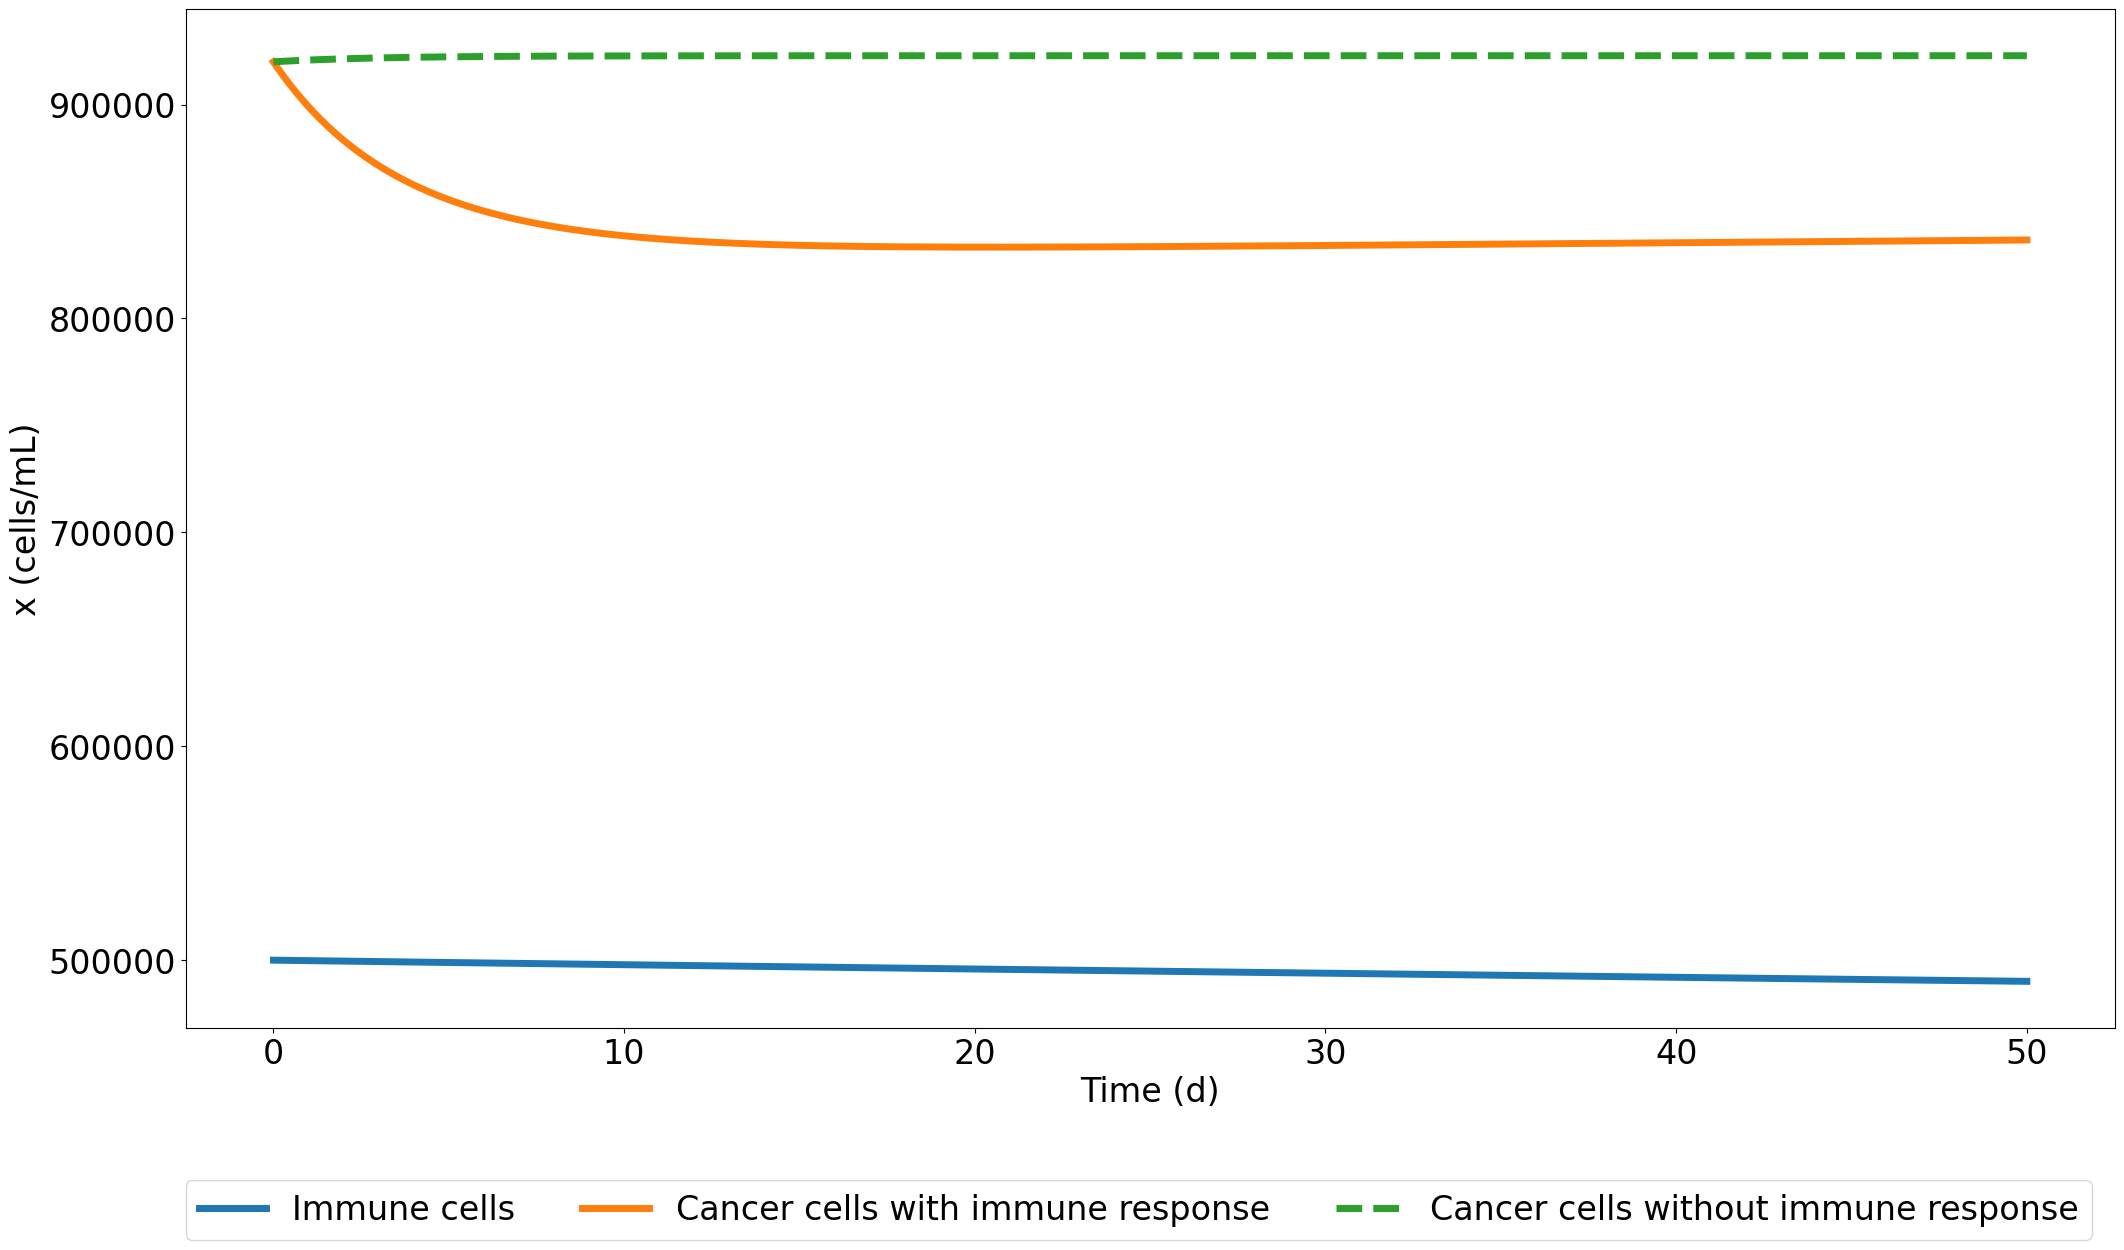

In [56]:
x0_test = 0.92e6
t_show_no_treatment = np.arange(0, 50 + dt, dt)

popDensity_immune_x_no_treatment = odeint(growthRate_immune_toxicity, [x0_test, y0], t_show_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,0]
popDensity_immune_y_no_treatment = odeint(growthRate_immune_toxicity, [x0_test, y0], t_show_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,1]

popDensity_x_no_treatment = odeint(growthRate, x0_test, t_show_no_treatment, args=(K, mu_no_drug, r))

plt.figure(figsize=(23, 13))
plt.plot(t_show_no_treatment, popDensity_immune_y_no_treatment, label = 'Immune cells', linewidth=5.0)
plt.plot(t_show_no_treatment, popDensity_immune_x_no_treatment, label='Cancer cells with immune response', linewidth=5.0)
plt.plot(t_show_no_treatment, popDensity_x_no_treatment, label='Cancer cells without immune response', linewidth=5.0, linestyle='dashed')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 24})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0, fontsize=24)
plt.tight_layout()
plt.savefig('NoTreatment_immuneResponse_highPop.pdf', format='pdf', bbox_inches='tight')
plt.show()

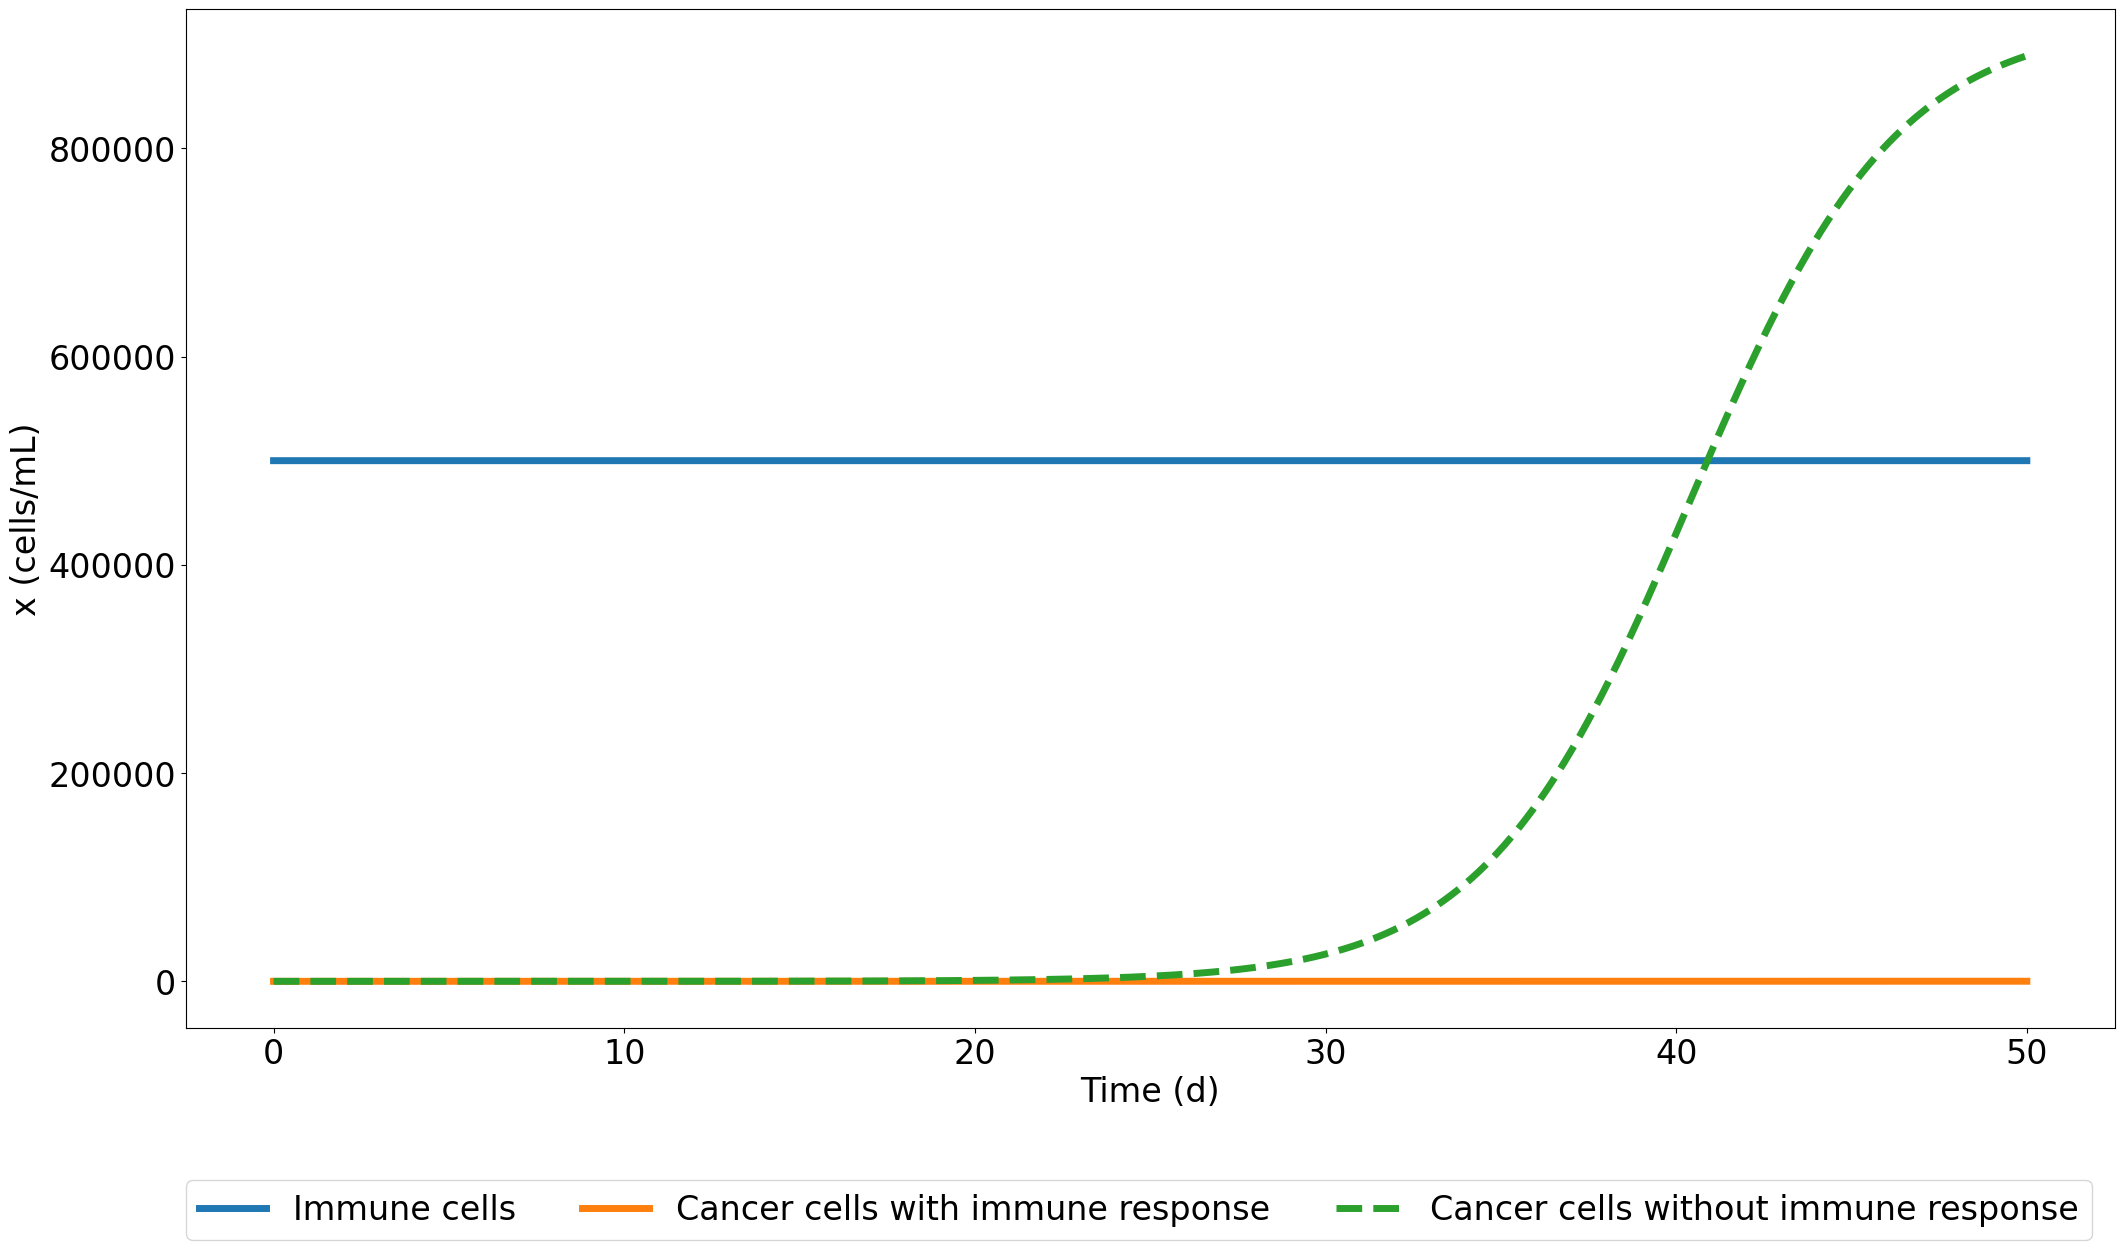

In [57]:
x0_test = 1
t_show_no_treatment = np.arange(0, 50 + dt, dt)

popDensity_immune_x_no_treatment = odeint(growthRate_immune_toxicity, [x0_test, y0], t_show_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,0]
popDensity_immune_y_no_treatment = odeint(growthRate_immune_toxicity, [x0_test, y0], t_show_no_treatment, args =(K, r, mu_no_drug, h, tau, n, c, g, m, d, d, s))[:,1]

popDensity_x_no_treatment = odeint(growthRate_immune_toxicity, [x0_test, 1e-8], t_show_no_treatment, args=(K, r, mu_no_drug, 0, 0, 1, 0, 1, 0, 0, 0, 0))[:,0]

plt.figure(figsize=(23, 13))
plt.plot(t_show_no_treatment, popDensity_immune_y_no_treatment, label = 'Immune cells', linewidth=5.0)
plt.plot(t_show_no_treatment, popDensity_immune_x_no_treatment, label='Cancer cells with immune response', linewidth=5.0)
plt.plot(t_show_no_treatment, popDensity_x_no_treatment, label='Cancer cells without immune response', linewidth=5.0, linestyle='dashed')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 24})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0, fontsize=24)
plt.tight_layout()
plt.savefig('NoTreatment_immuneResponse_lowPop.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Venetoclax and 7+3

In [58]:
mu_CAV = 0.332
mu_CV = 0.327

t = np.arange(0, 10 + dt, dt)
t_drug = np.arange(0, 7+dt,dt)

popDensity_noDrug = odeint(growthRate, x0, t_drug, args=(K, mu_no_drug, r))
popDensity_venetoclax = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_V, r))
popDensity_combination = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_CA, r))
popDensity_cytarabine = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_C, r))

popDensity_CAV = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_CAV, r))
popDensity_CV = odeint(growthRate, popDensity_noDrug[-1], t, args=(K, mu_CV, r))

print(f'survival after venetoclax: {((popDensity_venetoclax[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after cytarabine+anthracycline: {((popDensity_combination[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival cytarabine: {((popDensity_cytarabine[-1] / popDensity_noDrug[-1])[0]):.3f}')

print('-------------------')
print(f'survival after cytarabine+anthracycline + venetoclax, multiplication: {((popDensity_combination[-1] / popDensity_noDrug[-1])[0]) * ((popDensity_venetoclax[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after cytarabine+anthracycline + venetoclax, new death rate: {((popDensity_CAV[-1] / popDensity_noDrug[-1])[0]):.3f}')

print('-------------------')
print(f'survival after cytarabine + venetoclax, multiplication: {((popDensity_cytarabine[-1] / popDensity_noDrug[-1])[0]) * ((popDensity_venetoclax[-1] / popDensity_noDrug[-1])[0]):.3f}')
print(f'survival after cytarabine + venetoclax, new death rate: {((popDensity_CV[-1] / popDensity_noDrug[-1])[0]):.3f}')

survival after venetoclax: 0.987
survival after cytarabine+anthracycline: 0.389
survival cytarabine: 0.402
-------------------
survival after cytarabine+anthracycline + venetoclax, multiplication: 0.384
survival after cytarabine+anthracycline + venetoclax, new death rate: 0.384
-------------------
survival after cytarabine + venetoclax, multiplication: 0.397
survival after cytarabine + venetoclax, new death rate: 0.397


#### In QuANTUM-First

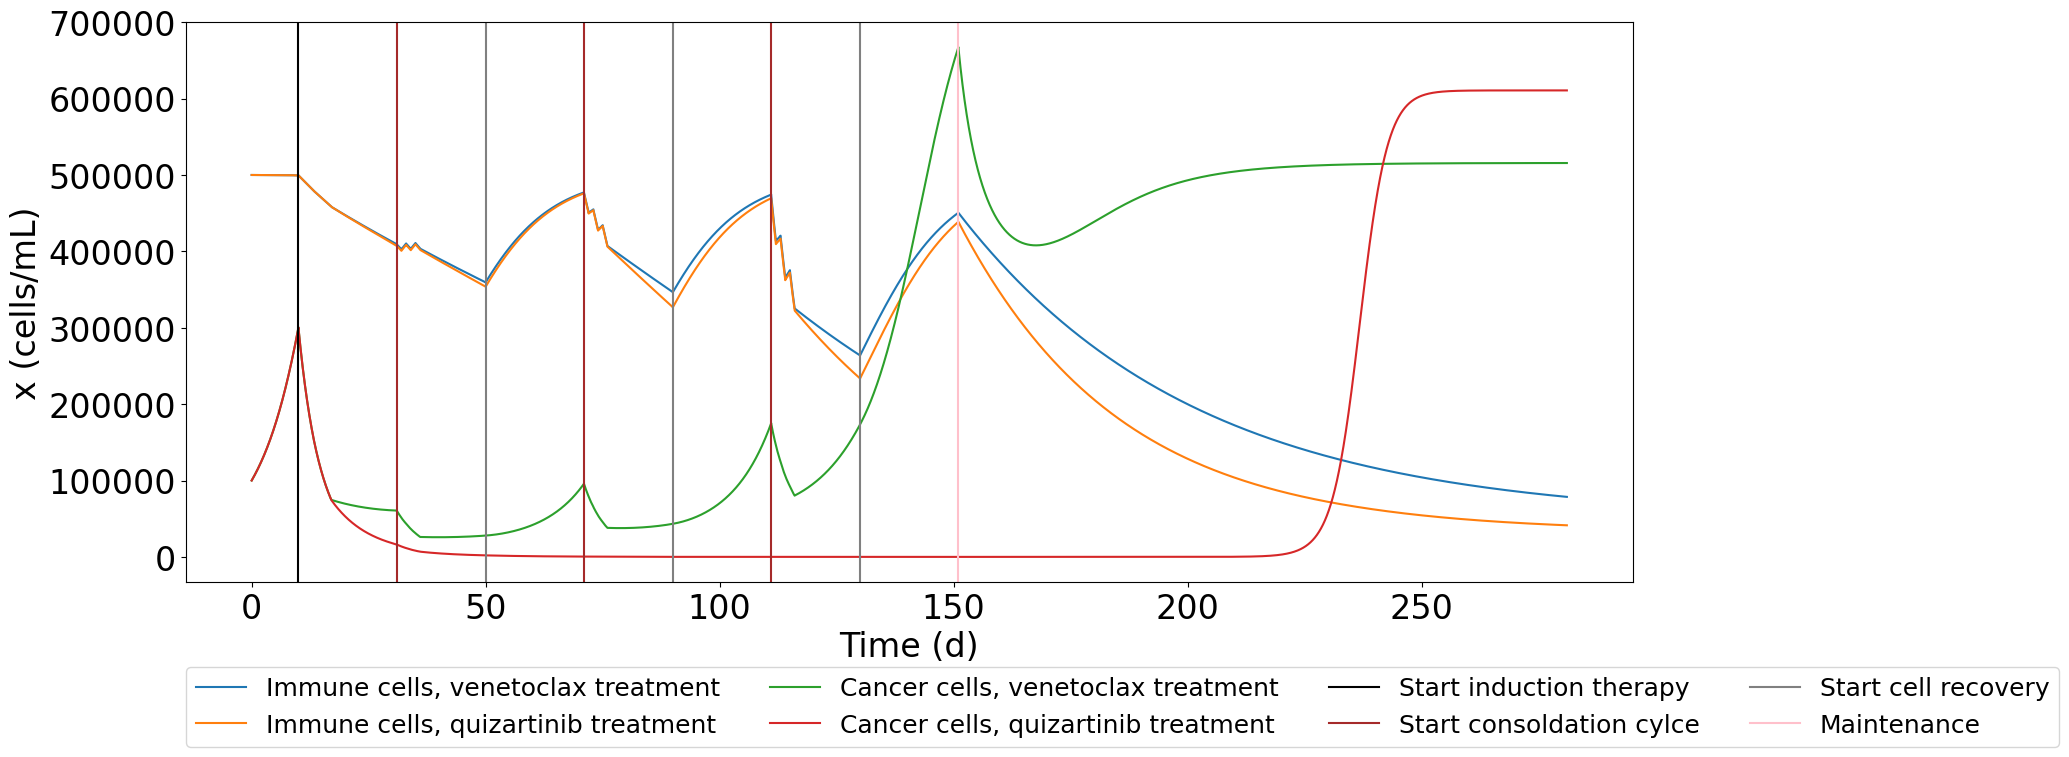

In [59]:
# Define treatment phases
treatment_phases = [
    #Induction phase
    ('Cytarabine + Anthracycline + Venetoclax', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Venetoclax', 14, mu_V, d_max_V, 0, 'V', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Venetoclax', 14, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 21, mu_V, d, 10, 'V', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Venetoclax', 14, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 21, mu_V, d, 10, 'V', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Venetoclax', 14, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 21, mu_V, d, 10, 'V', True),

    #Maintenance
    ('Venetoclax', 130, mu_V, d_max_V, 0, 'V', False),
]

treatment_phases_quiz = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 130, mu_Q, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)
_, _, density_quiz, immune_quiz, _, _, _, _, _, _ = simulate_treatment(treatment_phases_quiz, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(20, 8))
plt.plot(t, immune, label='Immune cells, venetoclax treatment')
plt.plot(t, immune_quiz, label = 'Immune cells, quizartinib treatment')
plt.plot(t, density, label='Cancer cells, venetoclax treatment')
plt.plot(t, density_quiz, label='Cancer cells, quizartinib treatment')

plt.axvline(daysBeforeTreatment, color='black', label = 'Start induction therapy')
plt.axvline(daysBeforeTreatment + 21, color = 'brown', label = 'Start consoldation cylce')
plt.axvline(daysBeforeTreatment + 40, color = 'gray', label = 'Start cell recovery')
plt.axvline(daysBeforeTreatment + 61, color = 'brown')
plt.axvline(daysBeforeTreatment + 80, color = 'gray')
plt.axvline(daysBeforeTreatment + 101, color = 'brown')
plt.axvline(daysBeforeTreatment + 120, color = 'gray')
plt.axvline(daysBeforeTreatment + 141, color = 'pink', label = 'Maintenance')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 18})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=4, borderaxespad=0)
plt.tight_layout()
plt.show()

#### The one in the article

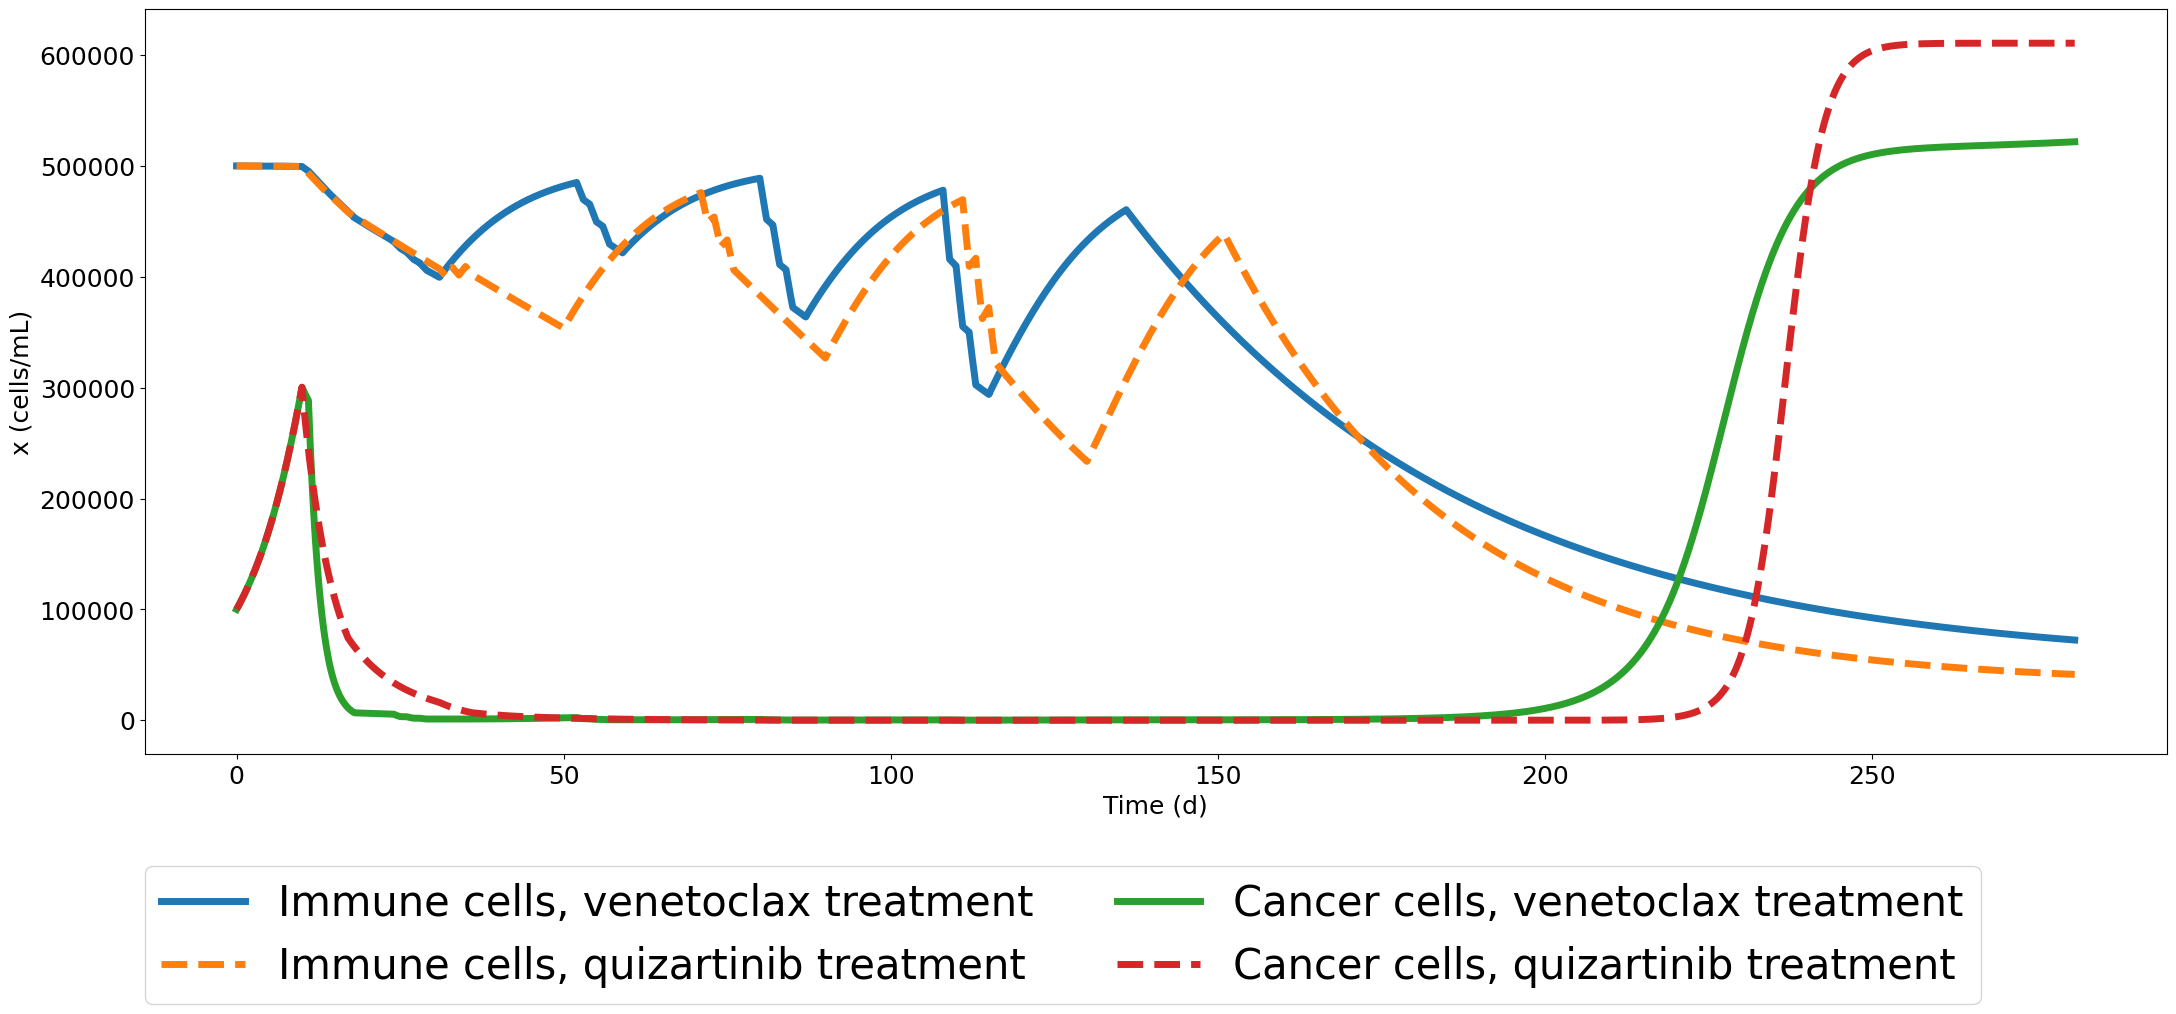

In [60]:
# Define treatment phases
d_max_CAV = d_max_CA + 0.01
d_max_CV = d_max_C + 0.01

treatment_phases = [
    #Induction phase
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Anthracycline + Venetoclax', 3, mu_CAV, d_max_CAV, 0, 'CV', False),
    ('Cytarabine + Venetoclax', 4, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 6, mu_V, d_max_V, 0, 'V', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 2, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 21, mu_V, d, 10, 'V', True),

    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 2, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 21, mu_V, d, 10, 'V', True),

    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 2, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 21, mu_V, d, 10, 'V', True),

    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 1, mu_V, d_max_V, 0, 'V', False),
    ('Cytarabine + Venetoclax', 1, mu_CV, d_max_CV, 0, 'CV', False),
    ('Venetoclax', 2, mu_V, d_max_V, 0, 'V', False),
    ('Cell recovery', 21, mu_V, d, 10, 'V', True),

    #Maintenance
    ('Venetoclax', 145, mu_V, d_max_V, 0, 'V', False),
]

treatment_phases_quantum  = [
    #Induction phase
    ('Cytarabine + Anthracycline', 3, mu_CA, d_max_CA, 0, 'C', False),
    ('Cytarabine', 4, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Cell recovery', 1, mu_C, d, 14, 'C', True),
    ('Cytarabine', 1, mu_C, d_max_C, 0, 'C', False),
    ('Quizartinib', 14, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_Q, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 130, mu_Q, d_max_Q, 0, 'Q', False),
]

treatment_phases_Q = [
    #Induction phase
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Anthracycline + Quizartinib', 3, mu_CAQ, d_max_CAQ, 0, 'CQ', False),
    ('Cytarabine + Quizartinib', 4, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 6, mu_Q, d_max_Q, 0, 'Q', False),
    #Is there a cell recovery here or does it go straight to consolidation?

    #Consolidation
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_V, d, 42, 'Q', True),

    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_V, d, 42, 'Q', True),

    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_V, d, 42, 'Q', True),

    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cytarabine + Quizartinib', 1, mu_CQ, d_max_CQ, 0, 'CQ', False),
    ('Quizartinib', 1, mu_Q, d_max_Q, 0, 'Q', False),
    ('Cell recovery', 21, mu_V, d, 42, 'Q', True),

    #Maintenance
    ('Quizartinib', 130, mu_Q, d_max_Q, 0, 'Q', False),
]

t, t_after_treatment, density, immune, sensitive, resistant_A, resistant_V, resistant_Q, resistant_C, t_values = simulate_treatment(treatment_phases, daysBeforeTreatment, parameters)
t_quantum, _, density_quantum, immune_quantum, _, _, _, _, _, _ = simulate_treatment(treatment_phases_quantum, daysBeforeTreatment, parameters)
t_q, _, density_q, immune_q, _, _, _, _, _, _ = simulate_treatment(treatment_phases_Q, daysBeforeTreatment, parameters)

# Plot results
plt.figure(figsize=(23, 11))
plt.plot(t, immune, label='Immune cells, venetoclax treatment', linewidth=5.0)
plt.plot(t_quantum, immune_quantum, label = 'Immune cells, quizartinib treatment', linewidth=5.0, linestyle='dashed')
#plt.plot(t_q, immune_q, label = 'Immune cells, quizartinib treatment')
plt.plot(t, density, label='Cancer cells, venetoclax treatment', linewidth=5.0)
plt.plot(t_quantum, density_quantum, label='Cancer cells, quizartinib treatment', linewidth=5.0, linestyle='dashed')
#plt.plot(t_q, density_q, label='Cancer cells, quizartinib treatment')

plt.xlabel('Time (d)')
plt.ylabel('x (cells/mL)')
plt.rcParams.update({'font.size': 30})
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2, borderaxespad=0, fontsize=30)
plt.tight_layout()
plt.savefig('Venetoclax7+3.pdf', format='pdf', bbox_inches='tight')
plt.show()